<a href="https://colab.research.google.com/github/fmantecam/hmvKp_raman/blob/main/identification_of_hmvKp_by_raman_spectroscopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime
import sys
from tqdm import tqdm

# Data processing and analysis
from scipy.linalg import solveh_banded
from scipy.signal import savgol_filter
from scipy.stats import norm, pearsonr
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Machine learning and preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, Normalizer
from sklearn.manifold import TSNE, MDS, Isomap, SpectralEmbedding
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Neural networks and deep learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution1D
from keras.models import load_model

# Class balancing
from imblearn.over_sampling import RandomOverSampler

# Check and mount for Google Colab
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print(f'Run on {datetime.datetime.now()} in Google Colab')
else:
    print(f'Run on {datetime.datetime.now()} on a local machine')


Mounted at /content/drive
Run on 2024-02-06 07:53:39.272922 in Google Colab


# helper functions

In [2]:
class WhittakerSmoother(object):
    def __init__(self, signal, smoothness_param, deriv_order=1):
        """
        Whittaker Smoother.
        Input:
            signal: Array-like, the input signal to be smoothed.
            smoothness_param: Float, parameter controlling the smoothness.
            deriv_order: Integer, the order of the derivative used in smoothing.
        """
        self.y = signal
        assert deriv_order > 0, 'deriv_order must be an int > 0'
        # Compute the fixed derivative of identity (D).
        d = np.zeros(deriv_order*2 + 1, dtype=int)
        d[deriv_order] = 1
        d = np.diff(d, n=deriv_order)
        n = self.y.shape[0]
        k = len(d)
        s = float(smoothness_param)
        # Create upper triangular banded matrix for smoothing operation.
        diag_sums = np.vstack([
            np.pad(s*np.cumsum(d[-i:]*d[:i]), ((k-i,0),), 'constant')
            for i in range(1, k+1)])
        upper_bands = np.tile(diag_sums[:,-1:], n)
        upper_bands[:,:k] = diag_sums
        for i, ds in enumerate(diag_sums):
            upper_bands[i, -i-1:] = ds[::-1][:i+1]
        self.upper_bands = upper_bands

    def smooth(self, w):
        """
        Perform the smoothing operation.
        Input:
            w: Array-like, weights for the smoothing process.
        Output:
            Array-like, smoothed signal.
        """
        foo = self.upper_bands.copy()
        foo[-1] += w  # last row is the diagonal
        return solveh_banded(foo, w * self.y, overwrite_ab=True, overwrite_b=True)


def als_baseline(intensities, asymmetry_param=0.0005, smoothness_param=1e6,
                 max_iters=20, conv_thresh=1e-6, verbose=False):
    """
    Asymmetric least squares baseline correction.
    Input:
        intensities: Array-like, original intensities of the signal.
        asymmetry_param: Float, parameter controlling asymmetry.
        smoothness_param: Float, parameter controlling smoothness.
        max_iters: Integer, maximum number of iterations.
        conv_thresh: Float, convergence threshold.
        verbose: Boolean, flag for verbose output.
    Output:
        Array-like, baseline corrected signal.
    """
    smoother = WhittakerSmoother(intensities, smoothness_param, deriv_order=2)
    p = asymmetry_param  # Rename for concision.
    w = np.ones(intensities.shape[0])  # Initialize weights.
    for i in range(max_iters):
        z = smoother.smooth(w)
        mask = intensities > z
        new_w = p*mask + (1-p)*(~mask)
        conv = np.linalg.norm(new_w - w)
        if verbose:
            print(i+1, conv)
        if conv < conv_thresh:
            break
        w = new_w
    else:
        print('ALS did not converge in %d iterations' % max_iters)
    return z


def find_baseline(df):
    """
    Apply baseline correction to each row in a DataFrame.
    Input:
        df: DataFrame, contains the spectral data.
    Output:
        DataFrame, with baseline corrected for each spectrum.
    """
    D0_BL = df.copy()
    for i in range(len(df)):
        bl = als_baseline(df.iloc[i, :].values)
        D0_BL.iloc[i, :] = bl
    return D0_BL


def preprocess_data(X_filtered):
    """
    Preprocessing of spectral data.
    Input:
        X_filtered: DataFrame, raw spectral data.
    Output:
        DataFrame, preprocessed spectral data.
    """
    X_norm_list = []
    for _, row in X_filtered.iterrows():
        # Normalize each spectrum.
        total = np.sum(row)
        X_norm_list.append(pd.DataFrame([row / total * 2000]))

    X_norm = pd.concat(X_norm_list, ignore_index=True)

    # Apply Savitzky-Golay filter for smoothing.
    X_norm_flt = savgol_filter(X_norm, 21, 2)
    X_norm_flt = pd.DataFrame(X_norm_flt, columns=X_filtered.columns)

    # Baseline correction.
    bl = find_baseline(X_norm_flt)
    X_norm_flt = X_norm_flt - bl

    # Standardize data.
    scaler = StandardScaler()
    z_numpy = X_norm_flt.values
    z_numpy_scaled_rows = scaler.fit_transform(z_numpy.T).T
    X_norm_flt_stdz = pd.DataFrame(data=z_numpy_scaled_rows, columns=X_norm_flt.columns)

    return X_norm_flt_stdz


# 2.2 Data acquisition

In [3]:
# load CSV file into a DataFrame
X_completa = pd.read_csv("/content/drive/MyDrive/klebsiellas/klebsiellas-todos-02agosto2023.csv")

# remove label columns
X = X_completa.iloc[:,:-9]

# define Raman shifts
ramanshifts = np.arange(600, 1800, 0.5)

# Identify rows where the difference between the maximum and minimum values is less than 75
rows_with_small_range = X[(X.max(axis=1) - X.min(axis=1)) < 75]

# Preprocessing steps
# Copying the complete dataset
filtered_data = X_completa.copy()

# Extracting the phenotype label
label = 'fenotype'
y_total = pd.DataFrame(filtered_data[label], columns=[label])
y_total[label] = pd.Categorical(y_total[label])

# Defining columns to be dropped
columns_to_drop = ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number',
                   'intense', 'fenotype', 'number', 'date']

# Dropping the non-spectral columns and preprocessing the spectral data
spectral_data = filtered_data.drop(columns=columns_to_drop)
preprocessed_spectral_data = preprocess_data(spectral_data)

# Merging the preprocessed spectral data with the dropped columns
combined_spectral_data = pd.concat([preprocessed_spectral_data, filtered_data[columns_to_drop]], axis=1)

# Removing spectra with range (max - min) less than 75
spectra_without_small_range = combined_spectral_data.drop(rows_with_small_range.index)

filtered_data = spectra_without_small_range

filtered_data = spectra_without_small_range[spectra_without_small_range['date'] != 270623]
#filtered_data = filtered_data[filtered_data['fenotype'] != 'control']

# Normalize spectra by shifting each to start at 0

# Define the columns that should not be altered as they are not spectral data
columns_to_retain = ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number',
                     'intense', 'fenotype', 'number', 'date']

# Extracting only the spectral data (excluding the last 9 columns which are non-spectral)
spectral_data_only = filtered_data.drop(columns=columns_to_retain)

# Shift each spectrum so its minimum value becomes 0
# Using .apply along axis=1 for row-wise operation
normalized_spectral_data = spectral_data_only.apply(lambda row: row - row.min(), axis=1)

# Reattaching the non-spectral data columns to the normalized spectral data
normalized_spectral_data = pd.concat([normalized_spectral_data, filtered_data[columns_to_retain]], axis=1)
#if not
#normalized_spectral_data = pd.concat([spectral_data_only, filtered_data[columns_to_retain]], axis=1)

filtered_data = normalized_spectral_data

### Figure 2

Figure 2: Histogram of Raman spectrum amplitudes of Klebsiella pneumoniae isolates divided into four colour regions (a) and a random Raman spectrum for each region (b).


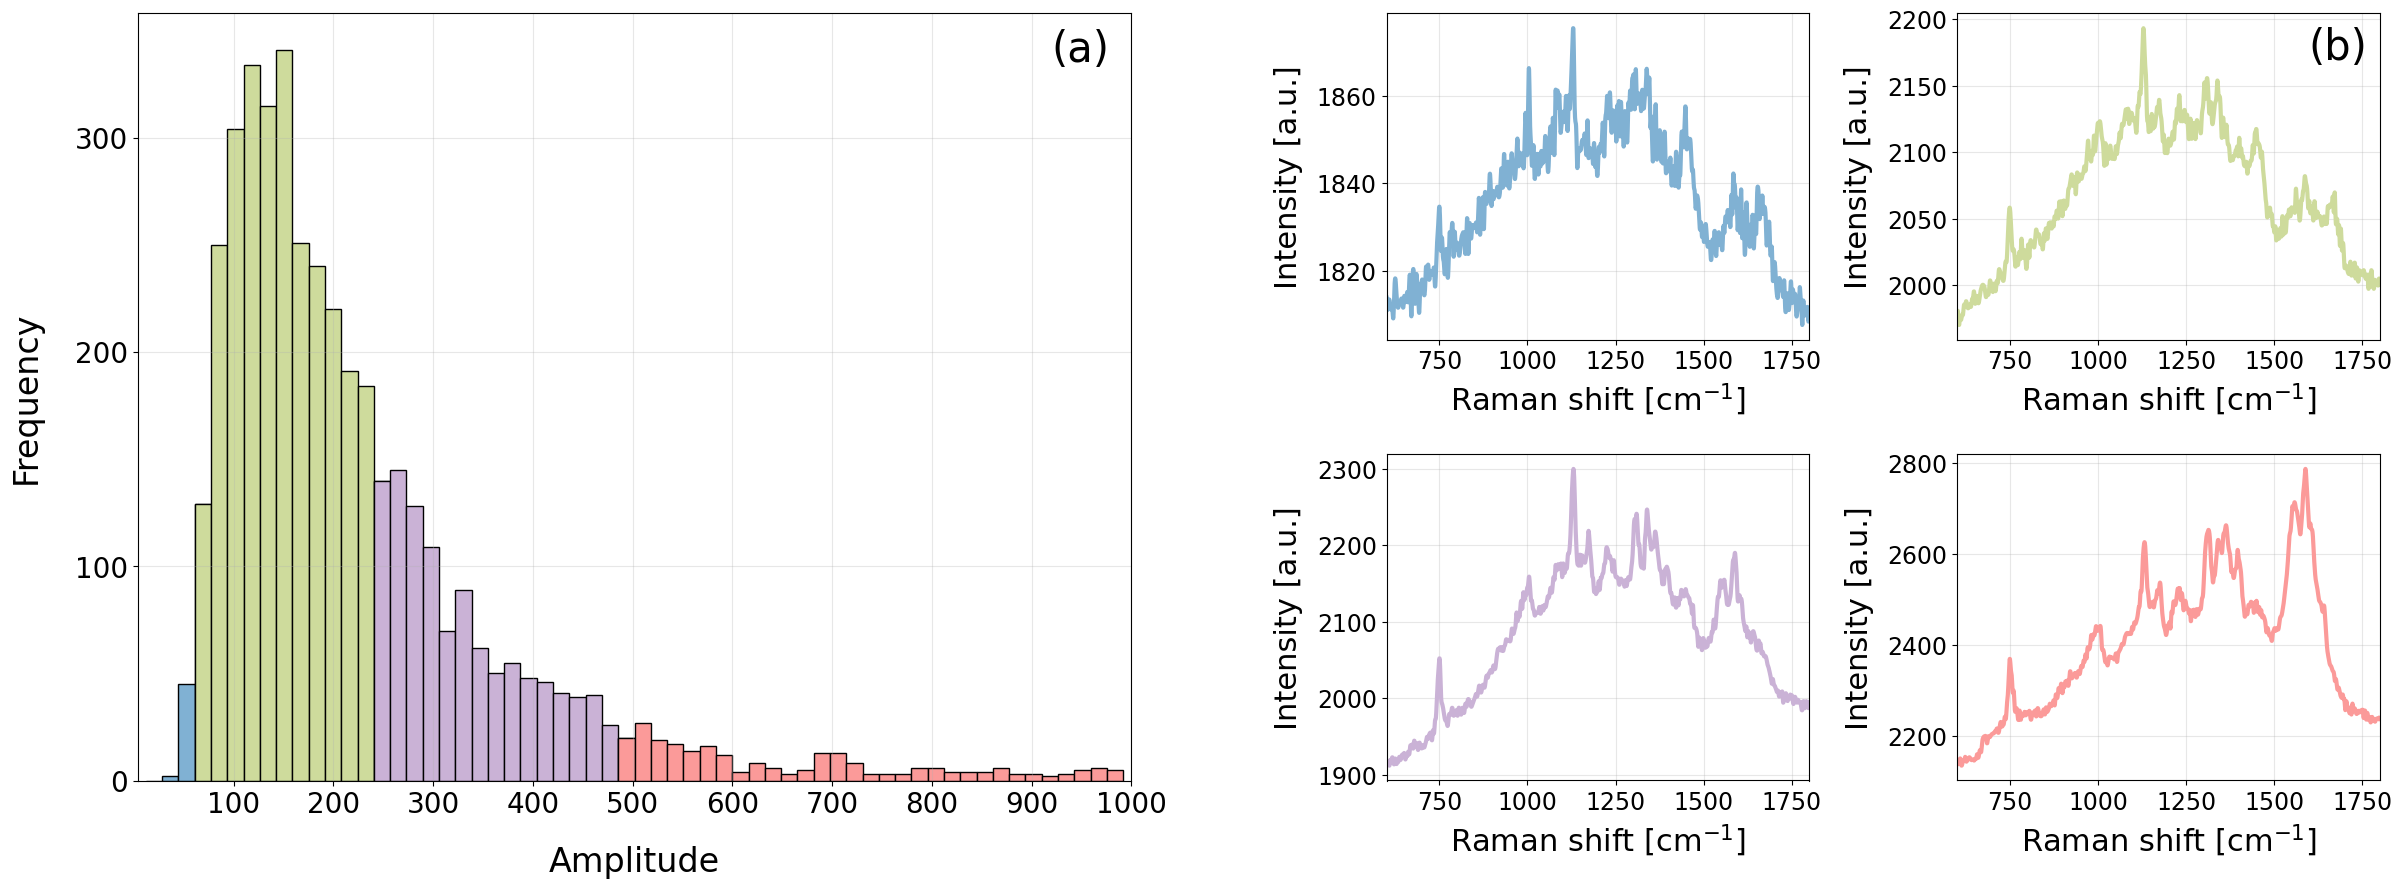

In [4]:
fig = plt.figure(figsize=(24, 9))
gs = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1, 0, 1])

# First subplot (fig2a)
ax2a = fig.add_subplot(gs[0])

# Calculate maximum amplitude
amplitud_maxima = X.max(axis=1) - X.min(axis=1)
amplitud_maxima_filtrada = amplitud_maxima[amplitud_maxima <= 1000]

# Define bin edges for histogram
bin_edges = np.linspace(20, 1000, 61)
hist, _ = np.histogram(amplitud_maxima_filtrada, bins=bin_edges)

# Generate a color palette
colors = sns.color_palette("Paired", n_colors=30)
colors2 = sns.color_palette("Set3", n_colors=30)
colors3 = sns.color_palette("tab20b", n_colors=30)

# Swap colors at index 0 and 1
colors[0], colors[1], colors[2], colors[3] = colors2[4], colors3[7], colors[8], colors[4]


# Define intervals for color assignment
intervalos_colores = [(10, 75), (75, 250), (250, 500), (500, 1000)]

# Plot histogram with color assignment
for i, (bin_start, bin_end) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    for intervalo, color in zip(intervalos_colores, colors):
        if intervalo[0] <= bin_start < intervalo[1] or intervalo[0] < bin_end <= intervalo[1]:
            ax2a.bar(bin_start, hist[i], width=np.diff(bin_edges)[i], color=color, edgecolor='black')

# Set properties for ax2a
ax2a.set_xlim(3.9, 1000)
ax2a.set_xlabel('Amplitude', fontsize=24, labelpad=20)
ax2a.set_ylabel('Frequency', fontsize=24, labelpad=23)
ax2a.xaxis.set_major_locator(plt.MultipleLocator(100))
ax2a.yaxis.set_major_locator(plt.MultipleLocator(100))
ax2a.grid(alpha=0.3)
ax2a.tick_params(labelsize=20)
ax2a.text(0.92, 0.98, '(a)', transform=ax2a.transAxes, fontsize=30, verticalalignment='top')

# Second subplot (fig2b)
ax2b = plt.Subplot(fig, gs[2])
fig.add_subplot(ax2b)

# Hide the frame of subplot fig2b
for spine in ax2b.spines.values():
    spine.set_visible(False)
ax2b.set_xticks([])
ax2b.set_yticks([])

# Create a GridSpec for the second subplot
gs2b = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[2], hspace=0.35, wspace=0.35)

# Plotting in the second subplot
for i, (bin_start, bin_end) in enumerate(intervalos_colores):
    espectros_en_rango = X_completa.iloc[:,:-9][(amplitud_maxima >= bin_start) & (amplitud_maxima < bin_end)]
    muestras_aleatorias = espectros_en_rango.sample(1)
    ax = fig.add_subplot(gs2b[i])

    for index, fila in muestras_aleatorias.iterrows():
        ax.plot(ramanshifts, fila, color=colors[i], linewidth=3)
    ax.grid(alpha=0.3)
    ax.set_xlim([600, 1800])
    ax.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=22, labelpad=6)
    ax.set_ylabel('Intensity [a.u.]', fontsize=22, labelpad=10)
    ax.tick_params(labelsize=17)

    if i == 1:
        ax.text(0.97, 0.96, '(b)', transform=ax.transAxes, fontsize=30,
                verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.savefig('fig2.svg', format='svg', dpi=300)
plt.show()

# 3.1 Class separability and Raman features

### Figure 4

Figure 4: Average Raman spectra for each Klebsiella pneumoniae serotype (K1, K2, 54 and K57) with their respective variance bands (a) and the average spectrum of the whole dataset with the position of the most relevant Raman features(b).

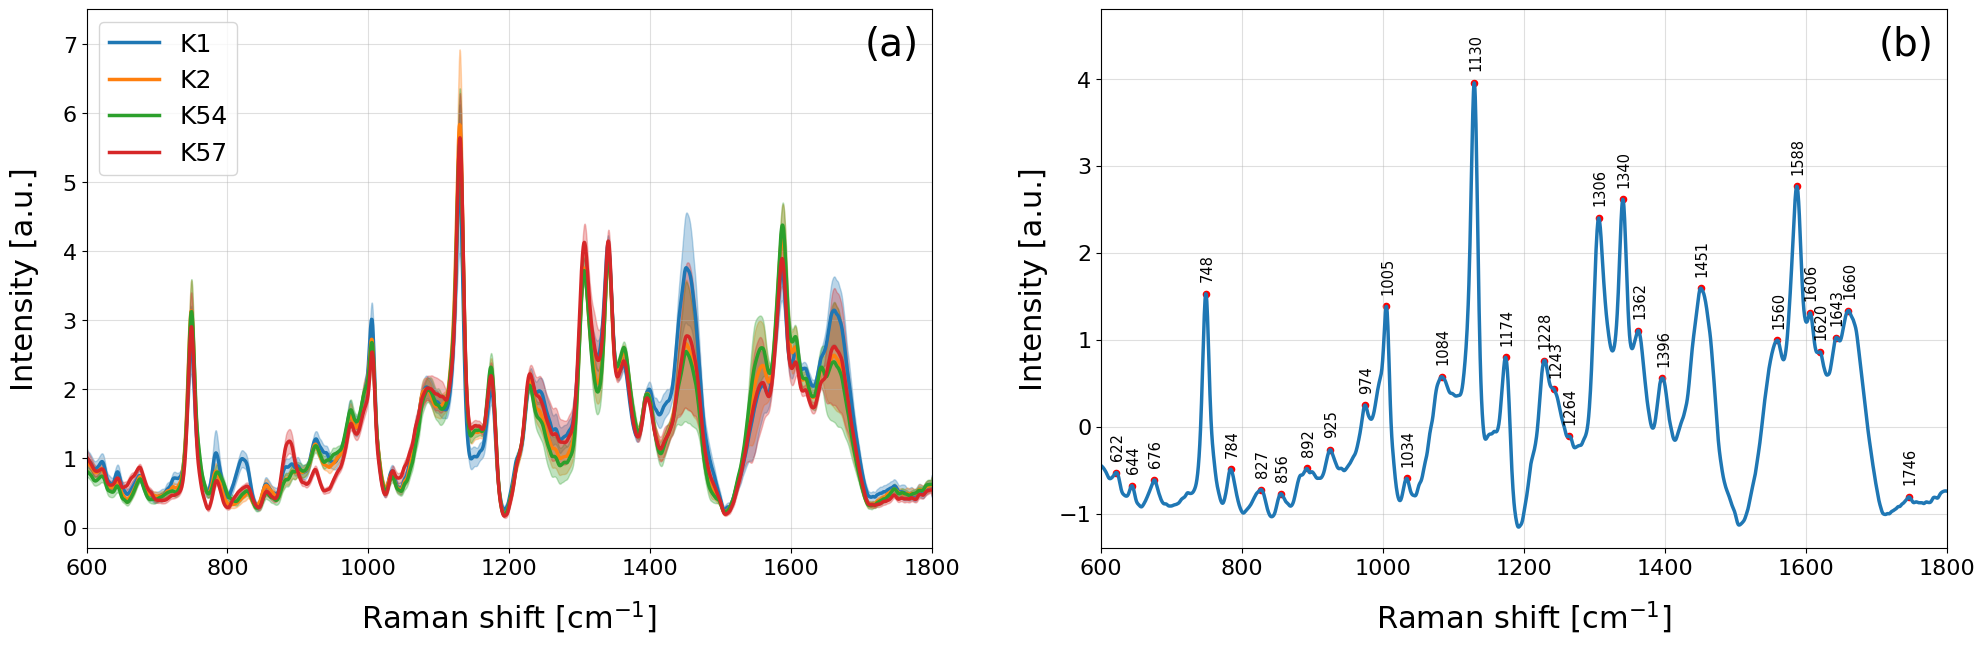

In [5]:
phenotypes = ['K1', 'K2', 'K54', 'K57']
colors = ['C0', 'C1', 'C2', 'C3']
spectra = {phenotype: np.mean(filtered_data[filtered_data['fenotype'] == phenotype].iloc[:, :-9], axis=0) for phenotype in phenotypes}
variances = {phenotype: filtered_data[filtered_data['fenotype'] == phenotype].iloc[:, :-9].var(axis=0) for phenotype in phenotypes}

# Creating a figure with two subplots
fig4, (ax4a, ax4b) = plt.subplots(1, 2, figsize=(24, 7))
alphaVal = 1
linethick = 2.5

# Plotting the spectra in the first subplot (ax4a)
for phenotype, color in zip(phenotypes, colors):
    ax4a.plot(ramanshifts, spectra[phenotype], lw=linethick, alpha=alphaVal, color=color, label=phenotype)
    # Plotting variance as filled regions
    ax4a.fill_between(ramanshifts, spectra[phenotype] - variances[phenotype], spectra[phenotype] + variances[phenotype], alpha=0.3, color=color)
ax4a.legend(loc='upper left', prop={'size': 18})
ax4a.grid(alpha=0.4)
ax4a.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=22, labelpad=15)
ax4a.set_ylabel(r'Intensity [a.u.]', fontsize=22, labelpad=17)
ax4a.set_xlim([600, 1800])
ax4a.set_ylim([-0.3, 7.5])

# Plotting the average spectrum and peaks in the second subplot (ax4b)
avg_spectrum = np.mean(spectral_data_only, axis=0)
peaks = [43, 87, 151, 297, 368, 454, 511, 584, 650, 749, 810, 867, 967, 1059, 1148, 1257, 1286, 1328, 1413, 1481, 1525, 1593, 1702, 1920, 1975, 2012, 2040, 2086, 2121, 2293]
ax4b.plot(ramanshifts, avg_spectrum, lw=linethick, alpha=alphaVal)
for peak in peaks:
    ax4b.scatter(ramanshifts[peak], avg_spectrum[peak], color='red', marker='o', alpha=1, s=20)
    ax4b.annotate(f'{ramanshifts[peak]:.0f}', (ramanshifts[peak], avg_spectrum[peak]), textcoords="offset points", xytext=(1, 11), ha='center', fontsize=10.5, rotation=90)
ax4b.grid(alpha=0.4)
ax4b.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=22, labelpad=15)
ax4b.set_ylabel(r'Intensity [a.u.]', fontsize=22, labelpad=8)
ax4b.set_xlim([600, 1800])
ax4b.set_ylim(-1.4, 4.8)

# Setting tick font sizes
ax4a.tick_params(axis='both', which='major', labelsize=16)
ax4b.tick_params(axis='both', which='major', labelsize=16)

# Adding text labels for subplots (a) and (b)
ax4a.text(0.92, 0.97, '(a)', transform=ax4a.transAxes, fontsize=28, verticalalignment='top')
ax4b.text(0.92, 0.97, '(b)', transform=ax4b.transAxes, fontsize=28, verticalalignment='top')

fig4.savefig('fig4.svg', format='svg', dpi=300)


### Figure 5

Figure 5: Pearson correlation matrix obtained for all acquired Raman spectra of Klebsiella pneumoniae bacteria (a), the same matrix with a threshold value of 0.8 (b) and a magnification of the highly correlated area (c).

In [ ]:
spectra = combined_spectral_data

In [ ]:
steps = [4]  # List of step sizes for dimensionality reduction

# Iterate over each step size to reduce dimensionality
for idx, step in enumerate(steps):
    # Calculate the number of columns after reduction
    num_reduced_columns = len(spectra.iloc[:, :-9].columns) // step

    # Initialize lists to store averaged columns and corresponding Raman shifts
    reduced_columns = []
    reduced_ramanshifts = []

    # Iterate over columns in steps to average groups of 'step' columns
    for i in range(0, len(spectra.iloc[:, :-9].columns), step):
        # Calculate the mean of each group of 'step' columns
        avg_columns = spectra.iloc[:, :-9].iloc[:, i:i+step].mean(axis=1)
        reduced_columns.append(avg_columns)
        # Calculate the mean Raman shift for each group of 'step' columns
        reduced_ramanshifts.append(np.mean(ramanshifts[i:i+step]))

    # Concatenate the averaged columns into a new DataFrame
    espectros_reduced = pd.concat(reduced_columns, axis=1)
    # Assign the mean Raman shift values as the column names of the new DataFrame
    espectros_reduced.columns = reduced_ramanshifts

In [ ]:
# Calculate the Pearson correlation matrix using pandas
correlation_matrix = espectros_reduced.corr(method='pearson')

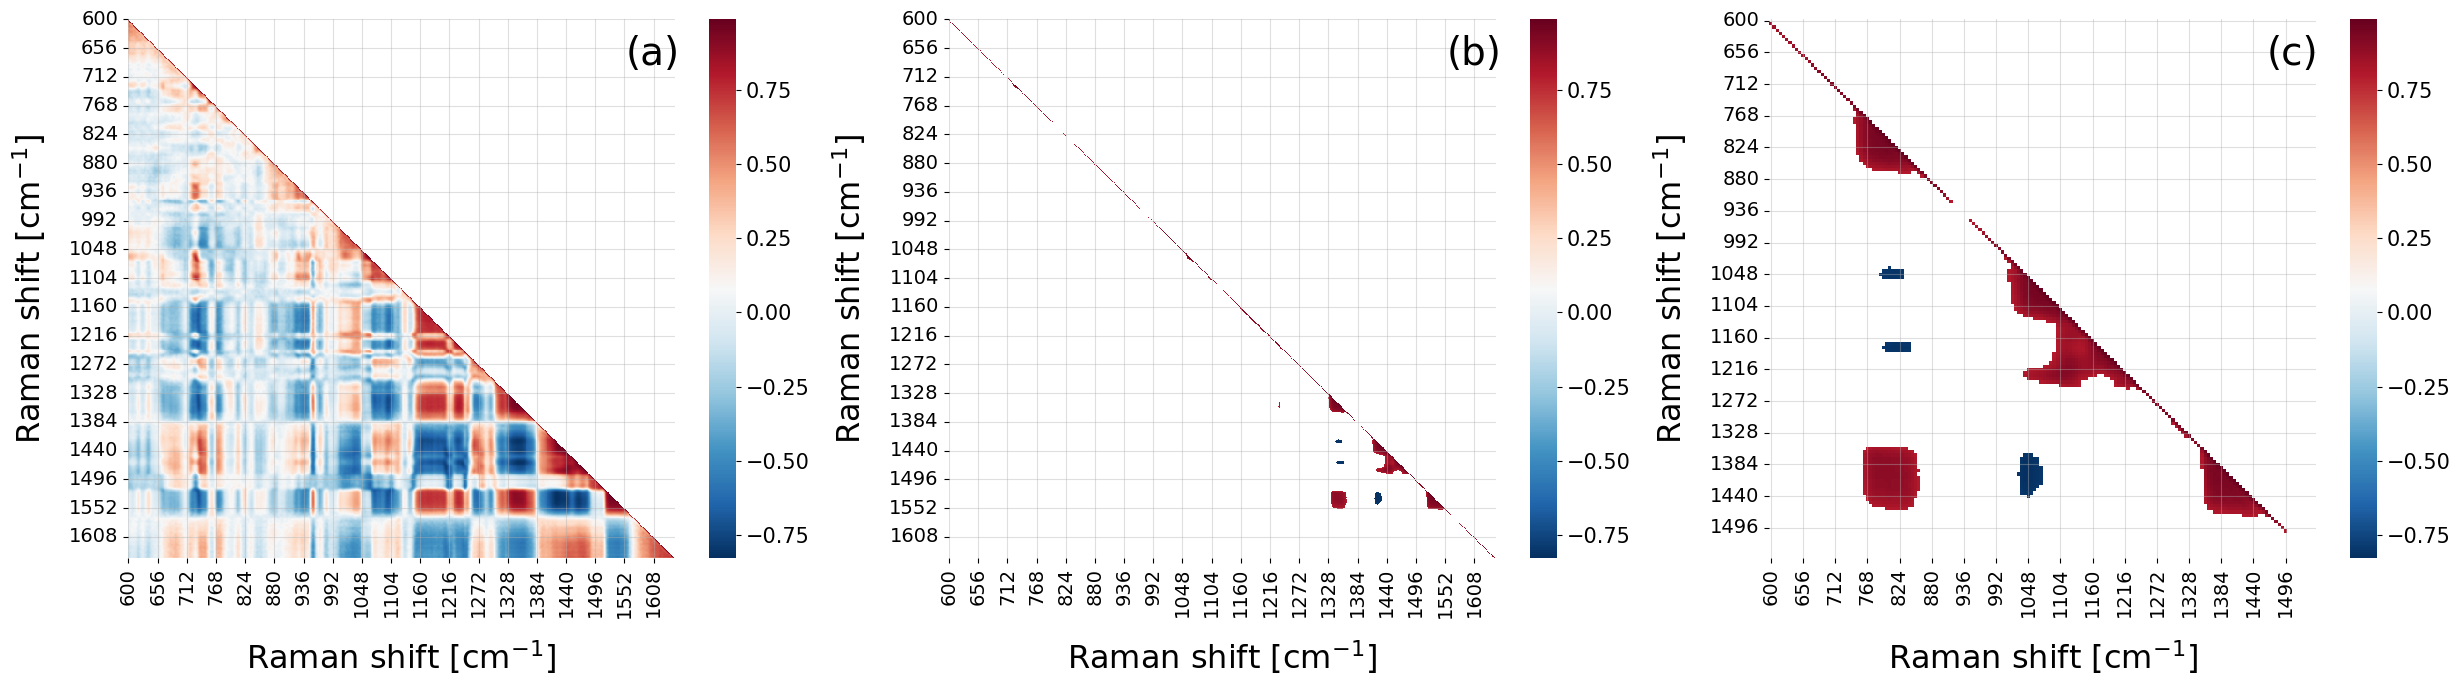

In [ ]:
fig, (ax5a, ax5b, ax5c) = plt.subplots(1, 3, figsize=(30, 7))

intervalo_xticks = 2
etiquetas_personalizadas = ["600", "656", "712", "768", "824", "880", "936", "992", "1048", "1104", "1160", "1216", "1272", "1328", "1384", "1440", "1496", "1552", "1608", "1664", "1720", "1776"]

# Function to adjust ticks, labels, and add grid
def customize_fig5(ax):
    xticks_positions = ax.get_xticks()
    nuevas_posiciones = xticks_positions[::intervalo_xticks]
    ax.set_xticks(nuevas_posiciones)
    ax.set_xticklabels(etiquetas_personalizadas[:len(nuevas_posiciones)], fontsize=14)
    ax.set_yticks(nuevas_posiciones)
    ax.set_yticklabels(etiquetas_personalizadas[:len(nuevas_posiciones)], fontsize=14)
    ax.grid(alpha=0.4)
    ax.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=23, labelpad=15)
    ax.set_ylabel(r'Raman shift [cm$^{-1}$]', fontsize=23, labelpad=15)

# figure 5a: plotting the full correlation matrix
sns.heatmap(correlation_matrix, mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), annot=False, cmap="RdBu_r", cbar=True, ax=ax5a)
cbar_ax5a = ax5a.collections[0].colorbar
cbar_ax5a.ax.tick_params(labelsize=15)
ax5a.text(0.91, 0.97, '(a)', transform=ax5a.transAxes, fontsize=28, verticalalignment='top')
customize_fig5(ax5a)

# figure 5b: thresholded Correlation Matrix
threshold = 0.8
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
filtered_matrix = np.where(np.abs(correlation_matrix) > threshold, correlation_matrix, np.nan)
sns.heatmap(filtered_matrix, mask=mask, annot=False, cmap="RdBu_r", cbar=True, ax=ax5b)
cbar_ax5b = ax5b.collections[0].colorbar
cbar_ax5b.ax.tick_params(labelsize=15)
ax5b.text(0.91, 0.97, '(b)', transform=ax5b.transAxes, fontsize=28, verticalalignment='top')
customize_fig5(ax5b)

# figure 5c: zoomed-in Correlation Matrix
correlation_matrix2 = correlation_matrix.iloc[390:560, 390:560]
filtro_intensos = np.abs(correlation_matrix2) > threshold
mask_intensos = np.triu(np.ones_like(correlation_matrix2, dtype=bool))
sns.heatmap(correlation_matrix2.where(filtro_intensos), mask=mask_intensos, annot=False, cmap="RdBu_r", cbar=True, ax=ax5c)
cbar_ax5c = ax5c.collections[0].colorbar
cbar_ax5c.ax.tick_params(labelsize=15)
customize_fig5(ax5c)
ax5c.text(0.91, 0.97, '(c)', transform=ax5c.transAxes, fontsize=28, verticalalignment='top')

# Display the plot
plt.savefig('fig5.svg', format='svg', dpi=300)
plt.show()


### Figure 6

Figure 6: Histogram of the 1450/1560 ratio (a) and 1660/1560 ratio (b) for all preprocessed Raman spectra of Klebsiella pneumoniae isolates.

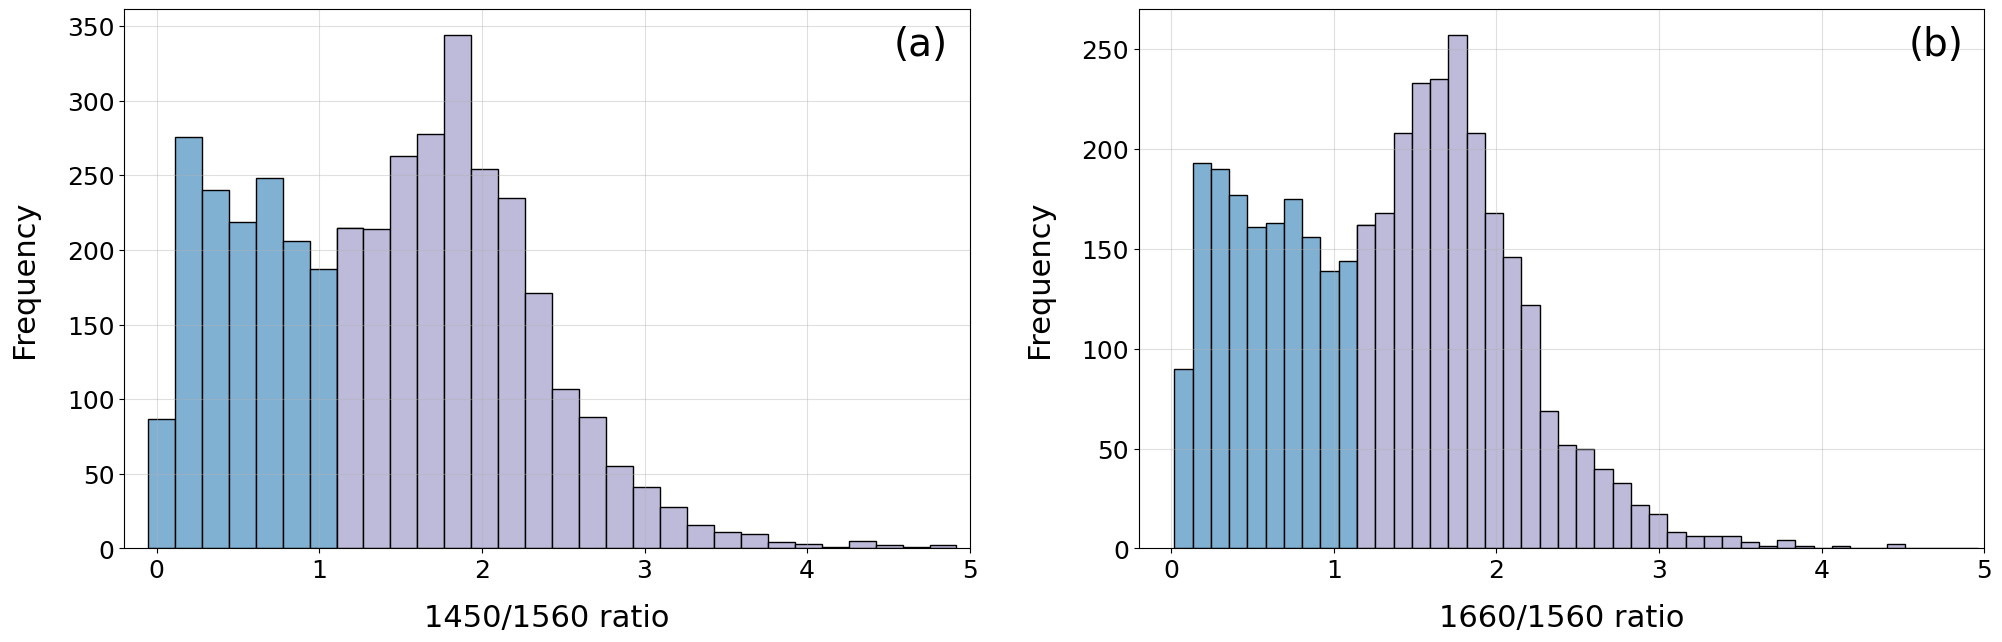

In [6]:
spectra2 = filtered_data.copy()

# Initial setup for histograms
fig6, (ax6a, ax6b) = plt.subplots(1, 2, figsize=(24, 7))
colors = sns.color_palette("Set3", n_colors=20)
colors[1], colors[0] = colors[2], colors[4]  # Adjusting colors

# Defining the ratios to be calculated
wavelength_1450, wavelength_1560, wavelength_1660 = '1450.0', '1560.0', '1660.0'
spectra2['ratio_1450_1560'] = spectra2[wavelength_1450] / spectra2[wavelength_1560]
spectra2['ratio_1660_1560'] = spectra2[wavelength_1660] / spectra2[wavelength_1560]

# Data for histograms and colors by interval
ratio_data = [
    ('ratio_1450_1560', ax6a, '1450/1560 ratio'), # Data for the first histogram
    ('ratio_1660_1560', ax6b, '1660/1560 ratio')  # Data for the second histogram
]

# Common settings for histogram intervals and colors
interval_colors = [(0, 1.2), (1.2, 5)]

# Loop through each ratio to create histograms
for ratio_name, ax, xlabel in ratio_data:
    hist, bin_edges = np.histogram(spectra2[ratio_name], bins=60)
    for i, (bin_start, bin_end) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
        for interval, color in zip(interval_colors, colors):
            if interval[0] <= bin_start < interval[1] or interval[0] < bin_end <= interval[1]:
                ax.bar(bin_start, hist[i], width=np.diff(bin_edges)[i], color=color, edgecolor='black')

    # Customizing subplot appearance
    ax.set_xlabel(xlabel, fontsize=22, labelpad=15)
    ax.set_ylabel('Frequency', fontsize=22, labelpad=20)
    ax.set_xlim(-0.2, 5)
    ax.grid(alpha=0.4)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.text(0.91, 0.97, f'({chr(97 + ratio_data.index((ratio_name, ax, xlabel)))})', transform=ax.transAxes, fontsize=28, verticalalignment='top')

# Save and show the figure
fig6.savefig('fig6.svg', format='svg', dpi=300)
plt.show()


### Figure 7

Figure 7: Average Raman spectra and variances bands for each spectra type, N1 (blue) and N2 (purple).

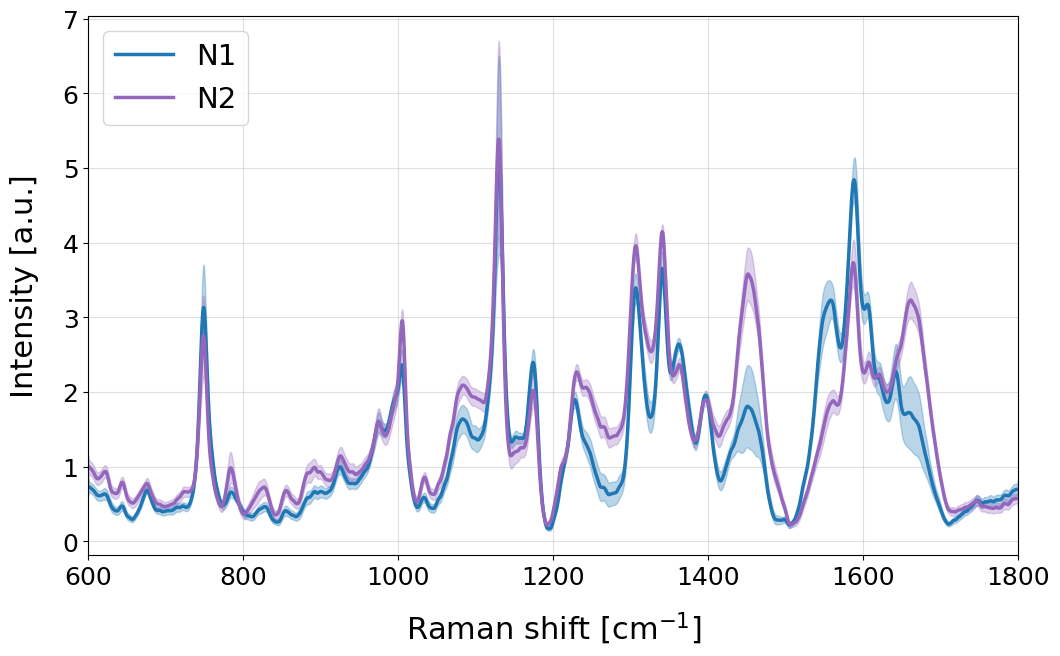

In [7]:
# Splitting the data into two categories based on the ratio_1450_1560 value
# This categorization is done to analyze spectra with intensity variations at 1450 cm^-1 relative to 1560 cm^-1.
intense_spectra = spectra2[spectra2['ratio_1450_1560'] < 1.1]
normal_spectra = spectra2[spectra2['ratio_1450_1560'] > 1.1]

# Calculating the mean spectra for each category
# The calculation excludes the last 10 columns, which do not contain spectral data.
mean_intense_spectra = intense_spectra.iloc[:, :-10].mean(axis=0, numeric_only=True)
mean_normal_spectra = normal_spectra.iloc[:, :-10].mean(axis=0, numeric_only=True)
# Calculating and plotting the variance for each category to indicate dispersion.
variance_intense_spectra = intense_spectra.iloc[:, :-10].var(axis=0, numeric_only=True)
variance_normal_spectra = normal_spectra.iloc[:, :-10].var(axis=0, numeric_only=True)

# Setting up the plot
fig, ax = plt.subplots(figsize=(12, 7))
alphaVal = 1
linethick = 2.5

# Plotting the mean spectra for both categories.
ax.plot(ramanshifts, mean_intense_spectra, lw=linethick, alpha=alphaVal, color='C0', label='N1')
ax.plot(ramanshifts, mean_normal_spectra, lw=linethick, alpha=alphaVal, color='C4', label='N2')
ax.fill_between(ramanshifts, mean_intense_spectra - variance_intense_spectra, mean_intense_spectra + variance_intense_spectra, alpha=0.3, color='C0')
ax.fill_between(ramanshifts, mean_normal_spectra - variance_normal_spectra, mean_normal_spectra + variance_normal_spectra, alpha=0.3, color='C4')
ax.legend(loc='upper left', prop={'size': 21})
# Enhancing plot aesthetics with grid, labels, and custom tick settings.
ax.grid(alpha=0.4)
ax.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=22, labelpad=15)
ax.set_ylabel('Intensity [a.u.]', fontsize=22, labelpad=17)
ax.set_xticks(np.arange(600, 2001, 200))  # Ensures the x-axis covers the specified range with proper interval
ax.set_yticks(np.arange(0, 8, 1))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlim([600, 1800])

# Saving and showing the plot
plt.savefig('fig7.svg', format='svg', dpi=300)
plt.show()



### Figure 8

Figure 8: Average Raman spectra and variance bands for each type of Klebsiella pneumoniae capsular serotype (K1, K2, 54 and K57) for both spectrum types, N1 (a) and N2 (b).

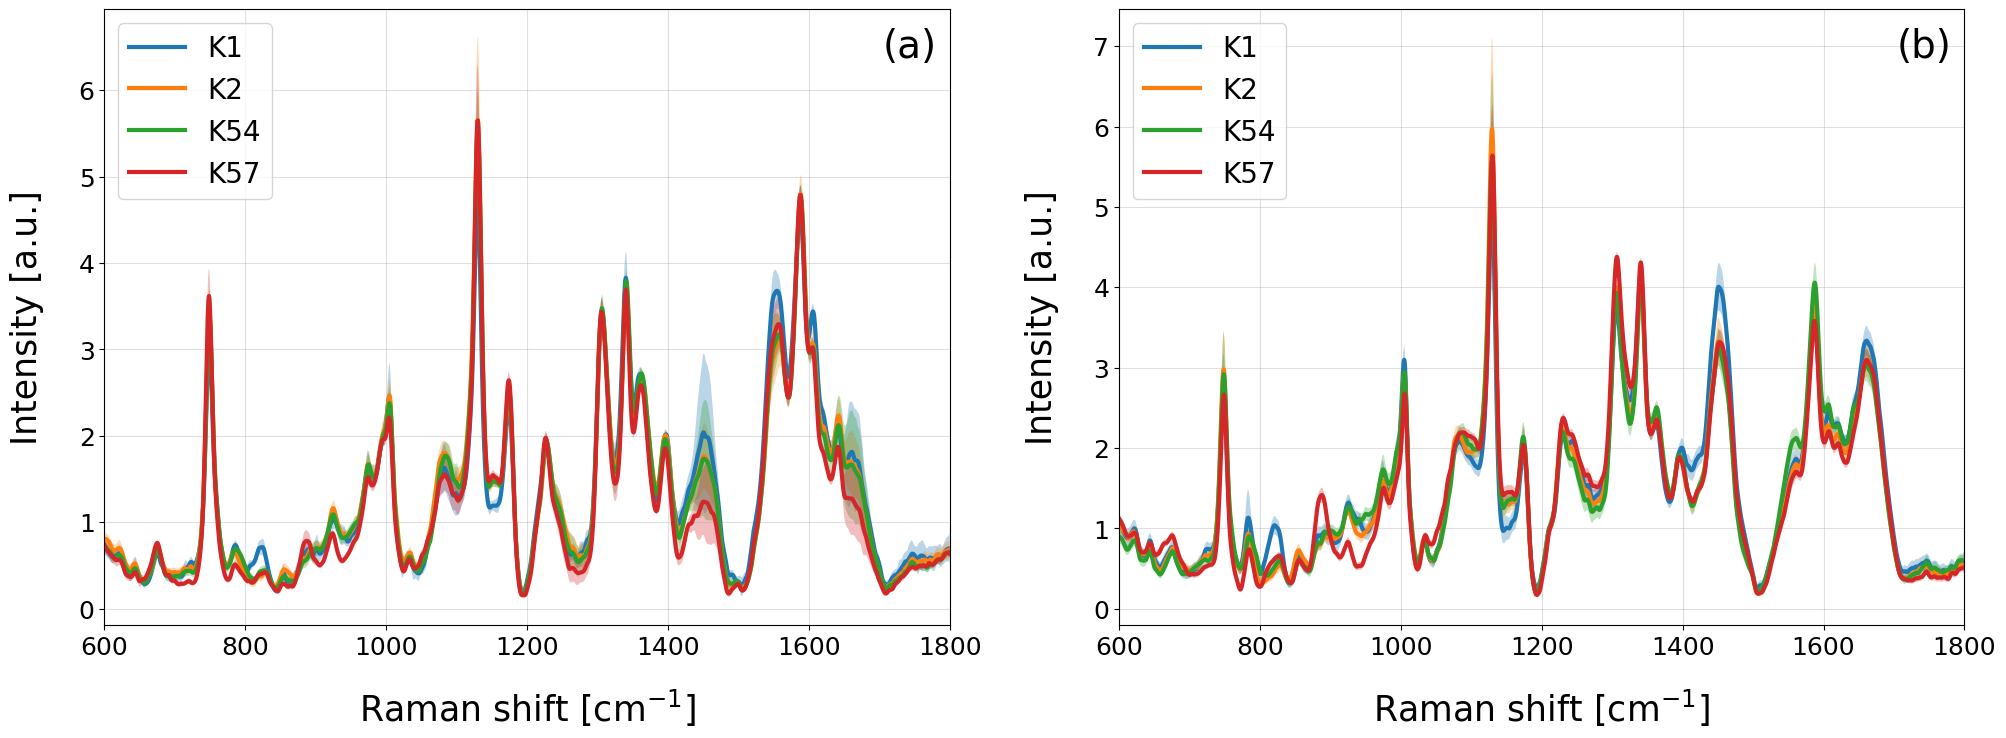

In [8]:
# Filtering spectra based on specific criteria and separating based on the 'ratio_1450_1560' value.
espectros_intensos = spectra2[(spectra2['ratio_1450_1560'] < 1.1) &
                              (spectra2['date'] != 270623) &
                              (spectra2['fenotype'] != 'control')]
espectros_normales = spectra2[(spectra2['ratio_1450_1560'] > 1.1) &
                              (spectra2['date'] != 270623) &
                              (spectra2['fenotype'] != 'control')]

label = 'fenotype'
unique_labels = ['K1', 'K2', 'K54', 'K57']  # Define unique labels for plotting

# Creating a subplot with 2 axes
fig, (ax8a, ax8b) = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

# Plotting for espectros_intensos with each label
for label2 in unique_labels:
    label_data = espectros_intensos[espectros_intensos[label] == label2]
    espectro_promedio = label_data.iloc[:, :-10].mean(axis=0, numeric_only=True)
    varianza = label_data.iloc[:, :-10].var(axis=0, numeric_only=True)
    ax8a.plot(ramanshifts, espectro_promedio, lw=3, alpha=1, label=f'{label2}')
    ax8a.fill_between(ramanshifts, espectro_promedio - varianza, espectro_promedio + varianza, alpha=0.3)

# Plotting for espectros_normales with each label
for label2 in unique_labels:
    label_data = espectros_normales[espectros_normales[label] == label2]
    espectro_promedio = label_data.iloc[:, :-10].mean(axis=0, numeric_only=True)
    varianza = label_data.iloc[:, :-10].var(axis=0, numeric_only=True)
    ax8b.plot(ramanshifts, espectro_promedio, lw=3, alpha=1, label=f'{label2}')
    ax8b.fill_between(ramanshifts, espectro_promedio - varianza, espectro_promedio + varianza, alpha=0.3)

# Setting labels, titles, legends, and formatting for ax8a and ax8b
for ax in [ax8a, ax8b]:
    ax.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=25, labelpad=20)
    ax.set_ylabel(r'Intensity [a.u.]', fontsize=25, labelpad=25)
    ax.grid(alpha=0.4)
    ax.legend(loc='upper left', prop={'size': 20})
    ax.tick_params(axis='both', labelsize=18)
    ax.set_xlim([600, 1800])

# Adding subplot labels
ax8a.text(0.92, 0.97, '(a)', transform=ax8a.transAxes, fontsize=28, verticalalignment='top')
ax8b.text(0.92, 0.97, '(b)', transform=ax8b.transAxes, fontsize=28, verticalalignment='top')

# Save and show plot
plt.savefig('fig8.svg', format='svg', dpi=300)
plt.show()


# 3.2. 1-D CNN classification models

### Figure 9

Figure 9: Confusion matrix for unseen data obtained from training a 1-D CNN model with all preprocessed spectra dataset. The overall accuracy is 86%.

In [9]:

def calculate_class_metrics_df(cm, class_labels):
    """
    Calculate class-wise metrics from a confusion matrix and return as a pandas DataFrame.

    Parameters:
    - cm: Confusion matrix (2D numpy array).
    - class_labels: List of class labels corresponding to the indices of the confusion matrix.

    Returns:
    - A pandas DataFrame with each row containing the class label and its associated metrics:
      precision, recall, F1-score, and support, all rounded to two decimal places.
    """
    # Initialize an empty list to hold each row's data as a dictionary
    rows_list = []

    for i, class_label in enumerate(class_labels):
        # Calculate precision, recall, and F1-score, handling division by zero where necessary
        precision = round(np.diag(cm)[i] / np.sum(cm, axis=0)[i], 2) if np.sum(cm, axis=0)[i] > 0 else 0
        recall = round(np.diag(cm)[i] / np.sum(cm, axis=1)[i], 2) if np.sum(cm, axis=1)[i] > 0 else 0
        f1_score = round(2 * (precision * recall) / (precision + recall), 2) if (precision + recall) > 0 else 0
        support = np.sum(cm, axis=1)[i]

        # Append the metrics for this class to the list as a dictionary
        rows_list.append({
            'Class': class_label,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1_score,
            'Support': support,
        })

    # Convert the list of dictionaries to a DataFrame
    metrics_df = pd.DataFrame(rows_list)

    return metrics_df


In [11]:
# Step 1: Data Preprocessing
## Define conditions for filtering data based on 'isolate' and 'date'
conditions = [
    (filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
    (filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
    (filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
    (filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723)
]

## Combine conditions with logical OR to create a final condition
final_condition = np.logical_or.reduce(conditions)

## Exclude 'control' samples
filtered_data = filtered_data[filtered_data['fenotype'] != 'control']

## Apply conditions to segregate unseen data and the rest
unseens = filtered_data[final_condition]
filtered_data2 = filtered_data[~final_condition]

## Define columns to be dropped
columns_to_drop = ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date']

# Step 2: Data Balancing
## Identify unique classes in the phenotype label
label = 'fenotype'
all_classes = filtered_data2[label].unique()

## Determine the size of the minority class for balancing
minority_class_size = filtered_data2[label].value_counts().min()

## Initialize DataFrame for balanced training and validation data
balanced_trainval_data = pd.DataFrame()

## Balance data by sampling
for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]
    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

## Prepare balanced dataset by dropping specified columns
balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()

# Step 3: Splitting Data into Training, Validation, and Test Sets
X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
X_test = unseens.drop(columns=columns_to_drop).copy()
y_test = unseens[label]

# Step 4: Encoding Labels
le = LabelEncoder()
num_classes_grouped = len(all_classes)
y_train_encoded = le.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_val)
y_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)

51/51 [==============================] - 2s 27ms/step
train accuracy: 0.896
13/13 [==============================] - 0s 18ms/step
val accuracy: 0.897
5/5 [==============================] - 0s 20ms/step
test accuracy: 0.863
train:
51/51 [==============================] - 1s 18ms/step


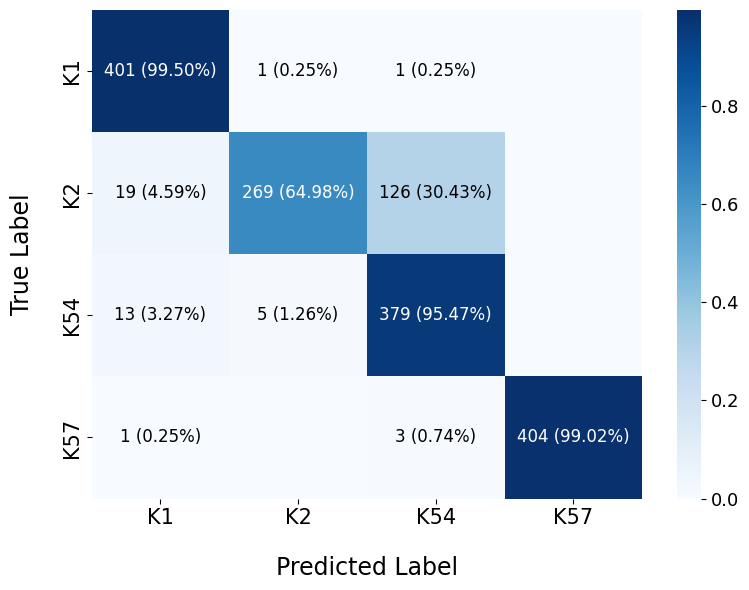

  Class  Precision  Recall  F1-Score  Support
0    K1       0.92    1.00      0.96      403
1    K2       0.98    0.65      0.78      414
2   K57       0.74    0.95      0.83      397
3   K54       1.00    0.99      0.99      408
val:
13/13 [==============================] - 0s 20ms/step


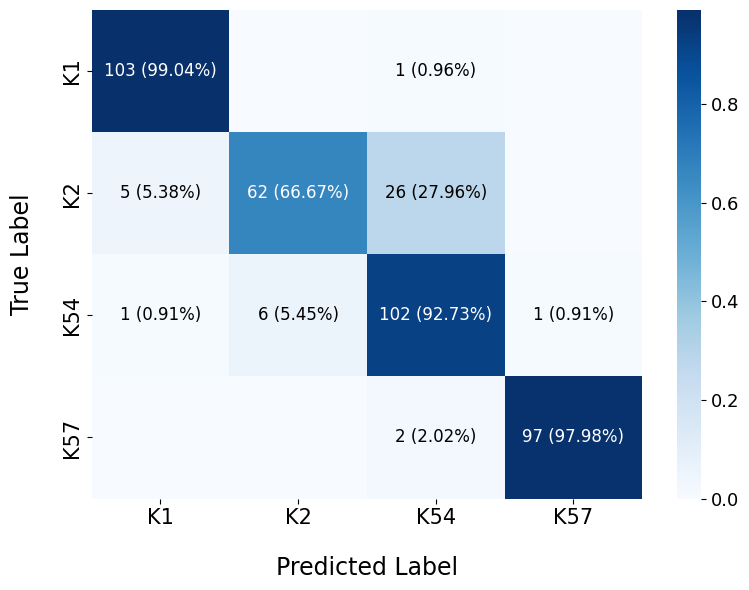

  Class  Precision  Recall  F1-Score  Support
0    K1       0.94    0.99      0.96      104
1    K2       0.91    0.67      0.77       93
2   K57       0.78    0.93      0.85      110
3   K54       0.99    0.98      0.98       99
test:
5/5 [==============================] - 0s 17ms/step


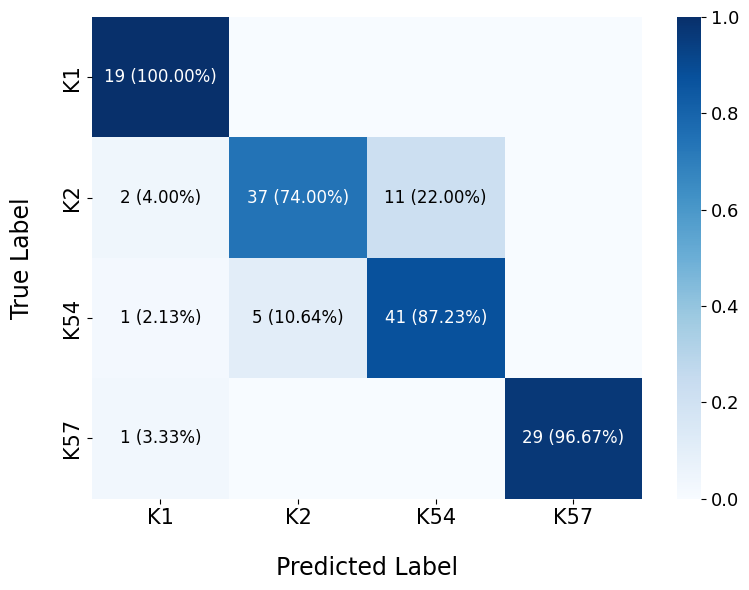

  Class  Precision  Recall  F1-Score  Support
0    K1       0.83    1.00      0.91       19
1    K2       0.88    0.74      0.80       50
2   K57       0.79    0.87      0.83       47
3   K54       1.00    0.97      0.98       30


In [12]:
# Step 5: Model Evaluation
model = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/model1_kleb_allfeatures_allfenotypes.h5')

eval_sets = [{'name': 'train', 'X': X_train, 'y': y_train},
             {'name': 'val', 'X': X_val, 'y': y_val},
             {'name': 'test', 'X': X_test, 'y': y_test}]

for eval_set in eval_sets:
    y_pred = model.predict(eval_set['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(eval_set['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{eval_set['name']} accuracy: {accuracy:.3f}")


# Step 6: Visualizing Confusion Matrices and Calculating Class-wise Metrics
class_accuracies = {'train': [], 'val': [], 'test': []}
class_metrics = []

for eval_set in eval_sets:
    print(f"{eval_set['name']}:")
    y_pred = model.predict(eval_set['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(eval_set['y'], axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize the confusion matrix

    fig9, ax9 = plt.subplots(figsize=(8, 6))
    sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=12)
    ax9.set_xlabel('Predicted Label', fontsize=17, labelpad=20)
    ax9.set_ylabel('True Label', fontsize=17, labelpad=20)
    plt.xticks( fontsize=15)
    plt.yticks(fontsize=15)
    cbar = sns_heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=13)
    plt.tight_layout()
    fig9.savefig('fig9.svg', format='svg', dpi=300)
    plt.show()

    metrics_df = calculate_class_metrics_df(cm, all_classes)
    print(metrics_df)


y-randomization

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2400, 64)          576       
                                                                 
 activation (Activation)     (None, 2400, 64)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 1200, 64)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1200, 64)          0         
                                                                 
 flatten (Flatten)           (None, 76800)             0         
                                                                 
 dense (Dense)               (None, 128)               9830528   
                                                        

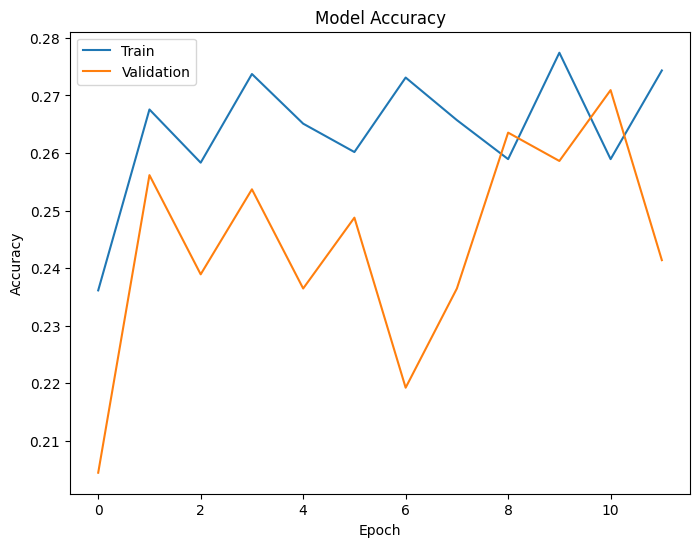

51/51 [==============================] - 3s 47ms/step
train accuracy: 0.287


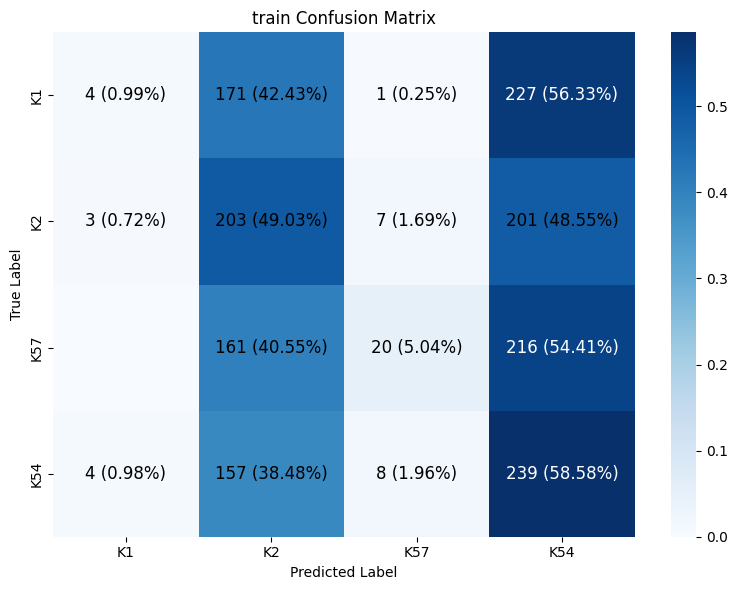

  Class  Precision  Recall  F1-Score  Support
0    K1       0.36    0.01      0.02      403
1    K2       0.29    0.49      0.36      414
2   K57       0.56    0.05      0.09      397
3   K54       0.27    0.59      0.37      408
13/13 [==============================] - 1s 64ms/step
val accuracy: 0.241


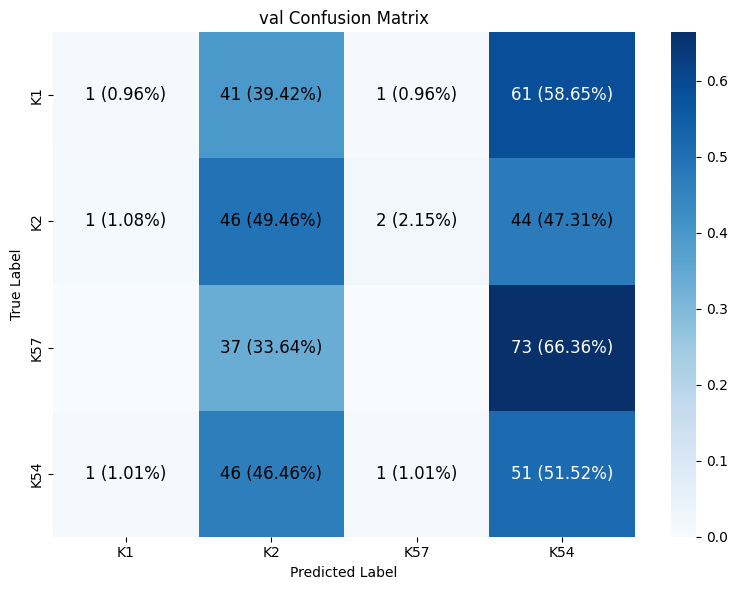

  Class  Precision  Recall  F1-Score  Support
0    K1       0.33    0.01      0.02      104
1    K2       0.27    0.49      0.35       93
2   K57       0.00    0.00      0.00      110
3   K54       0.22    0.52      0.31       99
5/5 [==============================] - 0s 58ms/step
test accuracy: 0.219


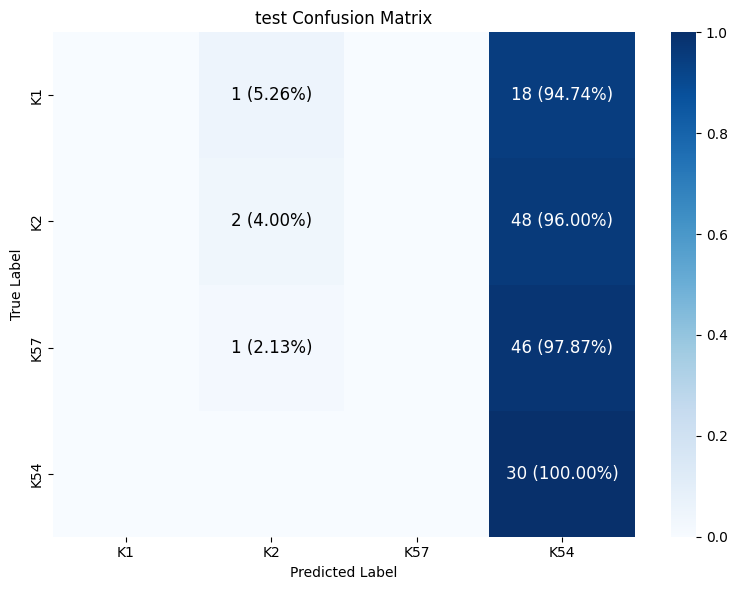

  Class  Precision  Recall  F1-Score  Support
0    K1       0.00    0.00      0.00       19
1    K2       0.50    0.04      0.07       50
2   K57       0.00    0.00      0.00       47
3   K54       0.21    1.00      0.35       30


In [ ]:
# Shuffle the labels for training, validation, and test sets to create a random permutation of data
y_perm_train = tf.random.shuffle(y_train)
y_perm_val = tf.random.shuffle(y_val)
y_perm_test = tf.random.shuffle(y_test)

# Initialize the Sequential model from Keras
model = tf.keras.models.Sequential()
# Add a 1D Convolutional layer with 64 filters, kernel size of 8, 'same' padding, and input shape based on training data
model.add(tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train.columns), 1)))
# Add a ReLU activation layer
model.add(tf.keras.layers.Activation('relu'))
# Add a Max Pooling layer with pool size of 2
model.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))
# Add a Dropout layer with a dropout rate of 25% to reduce overfitting
model.add(tf.keras.layers.Dropout(0.25))
# Flatten the output to make it suitable for the Dense layer
model.add(tf.keras.layers.Flatten())
# Add a Dense layer with 128 neurons
model.add(tf.keras.layers.Dense(128))
# Add another ReLU activation layer
model.add(tf.keras.layers.Activation('relu'))
# Add a Dropout layer with a dropout rate of 20%
model.add(tf.keras.layers.Dropout(0.2))
# Add a Dense output layer with a number of neurons equal to the number of classes, followed by a softmax activation to obtain probabilities
model.add(tf.keras.layers.Dense(num_classes_grouped))
model.add(tf.keras.layers.Activation('softmax'))
# Display the model's architecture
model.summary()

# Compile the model using Adam optimizer with a specific learning rate, categorical crossentropy as loss function, and track accuracy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model on the shuffled training data
history_yrandom1 = model.fit(X_train.to_numpy(), y_perm_train, batch_size=32, epochs=12, verbose=2, validation_data=(X_val.to_numpy(), y_perm_val))

# Plot the training and validation accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(history_yrandom1.history['accuracy'])
plt.plot(history_yrandom1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Prepare data for evaluation
calcular = [{'que': 'train', 'X': X_train, 'y': y_perm_train},
            {'que': 'val', 'X': X_val, 'y': y_perm_val},
            {'que': 'test', 'X': X_test, 'y': y_perm_test}]

# Initialize a dictionary to store class accuracies
class_accuracies = {'train': [], 'val': [], 'test': []}

# Evaluate the model on the train, validation, and test sets
for i in range(len(calcular)):
    # Predict the output
    y_pred = model.predict(calcular[i]['X'].to_numpy())
    # Convert probabilities to integer labels
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    # Calculate accuracy
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    # Generate and normalize the confusion matrix
    cm = confusion_matrix(y_true_int, y_pred_int)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Plot the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    plt.title(f"{calcular[i]['que']} Confusion Matrix")
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=all_classes, yticklabels=all_classes)
    # Annotate the heatmap with actual values and percentages
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=12)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Calculate and print class-wise metrics
    metrics_df = calculate_class_metrics_df(cm, all_classes)
    print(metrics_df)

### Figure 10

Figure 10: Confusion matrix for unseen data obtained from training a 1-D CNN model with all preprocessed spectra dataset after excluding N1 type spectra from the dataset. The overall accuracy was 81%.

In [13]:
# Filtering N1 type
# Filter to obtain rows where 'filename' matches those in 'espectros_intensos' DataFrame
coincidencias = filtered_data[filtered_data['filename'].isin(espectros_intensos['filename'])]
# Filter to obtain rows where 'filename' does not match any in 'coincidencias', effectively removing matched spectra
filtered_spectra_sin_coincidencias = filtered_data[~filtered_data['filename'].isin(coincidencias['filename'])]

In [20]:
final_condition

array([False, False, False, ..., False, False, False])

33/33 [==============================] - 1s 25ms/step
train accuracy: 0.901
9/9 [==============================] - 0s 24ms/step
val accuracy: 0.931
5/5 [==============================] - 0s 24ms/step
test accuracy: 0.807
train:
33/33 [==============================] - 1s 24ms/step


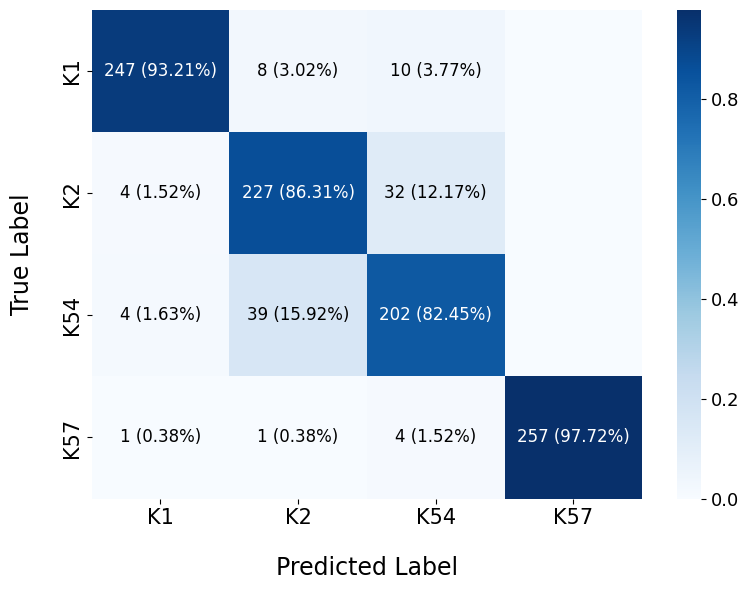

  Class  Precision  Recall  F1-Score  Support
0    K1       0.96    0.93      0.94      265
1    K2       0.83    0.86      0.84      263
2   K57       0.81    0.82      0.81      245
3   K54       1.00    0.98      0.99      263
val:
9/9 [==============================] - 0s 24ms/step


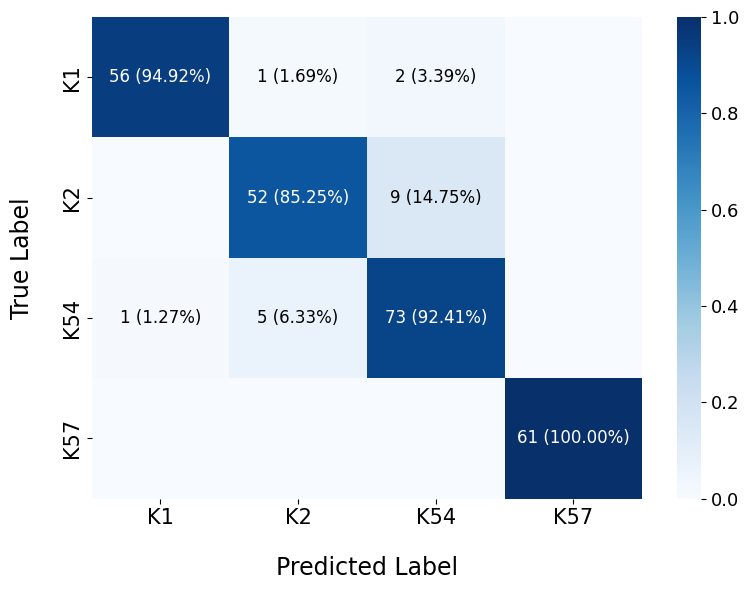

  Class  Precision  Recall  F1-Score  Support
0    K1       0.98    0.95      0.96       59
1    K2       0.90    0.85      0.87       61
2   K57       0.87    0.92      0.89       79
3   K54       1.00    1.00      1.00       61
test:
5/5 [==============================] - 0s 32ms/step


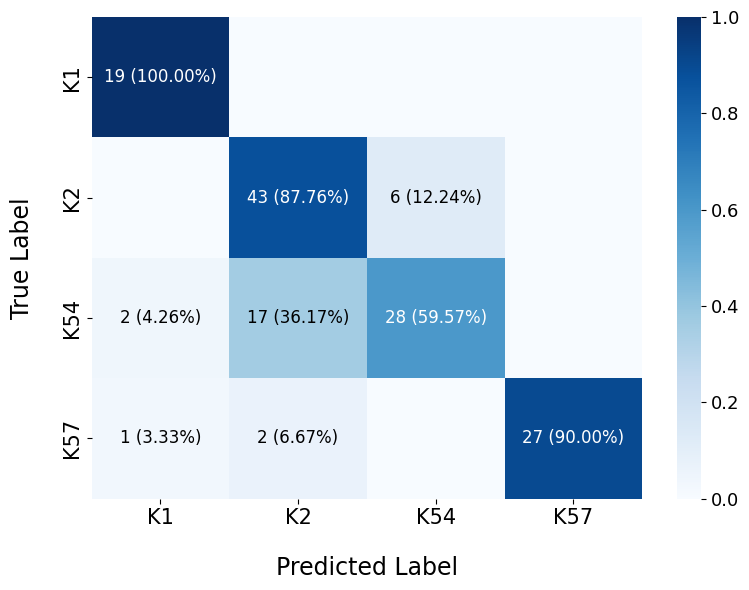

  Class  Precision  Recall  F1-Score  Support
0    K1       0.86    1.00      0.92       19
1    K2       0.69    0.88      0.77       49
2   K57       0.82    0.60      0.69       47
3   K54       1.00    0.90      0.95       30


In [22]:
# Load the pre-trained model. This model is expected to have been trained on a dataset with diverse features and phenotypes but excluding intensely sampled spectra.
model = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/model2_kleb_allfeatures_alfenotypes_quitandointensos.h5')

# Identify spectra that do not contain intense samples based on predefined conditions, thereby segregating the dataset for analysis without these intense samples.

## Define conditions for filtering data based on 'isolate' and 'date'
conditions = [
    (filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
    (filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
    (filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
    (filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723)
]

## Combine conditions with logical OR to create a final condition
final_condition = np.logical_or.reduce(conditions)

## Exclude 'control' samples
filtered_data = espectros_normales[espectros_normales['fenotype'] != 'control']

## Apply conditions to segregate unseen data and the rest
unseens_withoutintense = filtered_data[final_condition]
filtered_data2_withoutintense = filtered_data[~final_condition]


# To address potential class imbalance within the dataset, implement a data balancing technique. This ensures that each class is represented equally in the training and validation datasets, enhancing model fairness and performance.
all_classes = espectros_normales[label].unique()
minority_class_size = espectros_normales[label].value_counts().min()
balanced_trainval_data = pd.DataFrame()

for class_name in all_classes:
    class_samples = espectros_normales[espectros_normales[label] == class_name]
    # If a class exceeds the size of the minority class, randomly sample down to the size of the minority class to achieve balance.
    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval_withoutintense = balanced_trainval_data[label]

# Remove non-feature columns from the dataset as they are not needed for model training or predictions.
columns_to_drop2 = ['filename','isolate','specie','mucoide','spectrum_number', 'intense', 'fenotype', 'number', 'date', 'ratio_1450_1560', 'ratio_1660_1560']
balanced_trainval_data_withoutintense = balanced_trainval_data.drop(columns=columns_to_drop2).copy()

# Split the balanced dataset into training and validation sets, ensuring a portion of the data is reserved for model validation to evaluate performance on unseen data.
X_train_withoutintense, X_val_withoutintense, y_train_withoutintense, y_val_withoutintense = train_test_split(
    balanced_trainval_data_withoutintense, balanced_y_trainval_withoutintense, test_size=0.20, random_state=1000)

# Prepare the test set using unseen data, applying the same preprocessing steps as the training and validation sets.
y_test_withoutintense = unseens_withoutintense[label]
X_test_withoutintense = unseens_withoutintense.drop(columns=columns_to_drop2).copy()

# Apply label encoding to convert categorical labels into a format suitable for model training and evaluation. This includes converting to one-hot encoding for compatibility with the model's output layer.
num_classes_grouped = len(all_classes)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_withoutintense)
y_train_withoutintense = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_test_withoutintense)
y_test_withoutintense = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_val_withoutintense)
y_val_withoutintense = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

# Define evaluation sets for streamlined evaluation across training, validation, and test sets.
eval_sets = [{'name': 'train', 'X': X_train_withoutintense, 'y': y_train_withoutintense},
             {'name': 'val', 'X': X_val_withoutintense, 'y': y_val_withoutintense},
             {'name': 'test', 'X': X_test_withoutintense, 'y': y_test_withoutintense}]

# Model evaluation loop: For each set, predict the outcomes, calculate accuracy, and print the results. This quantifies model performance across different data segments.
for eval_set in eval_sets:
    y_pred = model.predict(eval_set['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(eval_set['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{eval_set['name']} accuracy: {accuracy:.3f}")

# Further evaluate model performance using confusion matrices for a detailed understanding of true vs. predicted labels, alongside computing class-wise metrics for in-depth analysis.
for eval_set in eval_sets:
    print(f"{eval_set['name']}:")
    y_pred = model.predict(eval_set['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(eval_set['y'], axis=1)

    # Compute and normalize the confusion matrix for clearer interpretation of model predictions across all classes.
    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize the confusion matrix for percentage representation

    # Visualization of the normalized confusion matrix using a heatmap for intuitive analysis of model performance across classes.
    fig10, ax10 = plt.subplots(figsize=(8, 6))
    sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues',
                              xticklabels=le.inverse_transform(np.arange(num_classes_grouped)),
                              yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    # Annotate each cell with the absolute and percentage values for detailed insights into class-specific performance.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=12)
    ax10.set_xlabel('Predicted Label', fontsize=17, labelpad=20)
    ax10.set_ylabel('True Label', fontsize=17, labelpad=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    cbar = sns_heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=13)
    plt.tight_layout()
    fig10.savefig('fig10.svg', format='svg', dpi=300)
    plt.show()

    # Compute and display class-wise metrics from the confusion matrix to evaluate precision, recall, and F1-score among others.
    metrics_df = calculate_class_metrics_df(cm, all_classes)
    print(metrics_df)


y-randomization

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2400, 64)          576       
                                                                 
 activation_6 (Activation)   (None, 2400, 64)          0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1200, 64)          0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 1200, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 76800)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               9830528   
                                                      

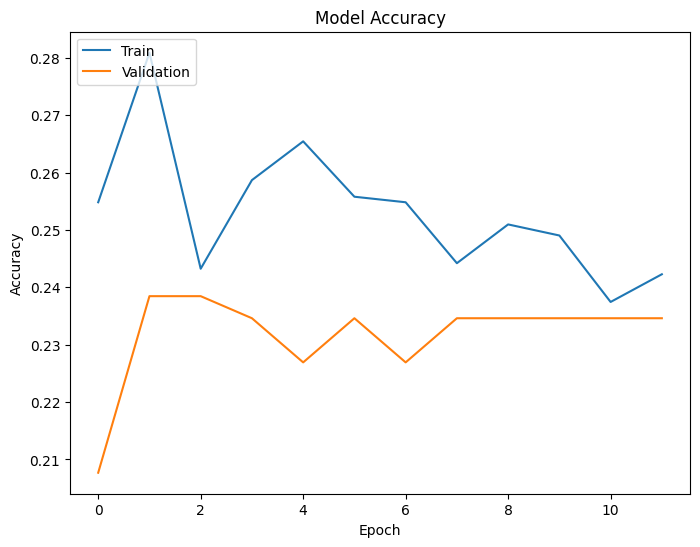

33/33 [==============================] - 2s 52ms/step
train accuracy: 0.254


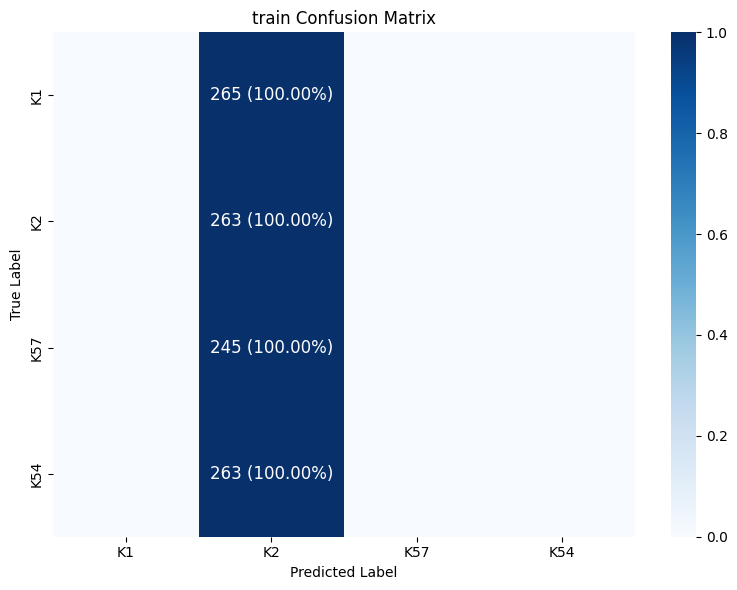

  Class  Precision  Recall  F1-Score  Support
0    K1       0.00     0.0       0.0      265
1    K2       0.25     1.0       0.4      263
2   K57       0.00     0.0       0.0      245
3   K54       0.00     0.0       0.0      263
9/9 [==============================] - 1s 59ms/step
val accuracy: 0.235


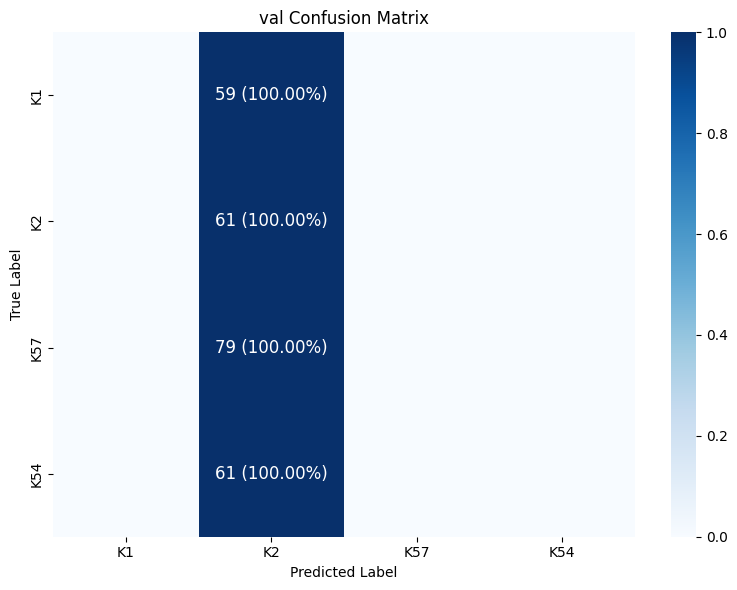

  Class  Precision  Recall  F1-Score  Support
0    K1       0.00     0.0      0.00       59
1    K2       0.23     1.0      0.37       61
2   K57       0.00     0.0      0.00       79
3   K54       0.00     0.0      0.00       61
5/5 [==============================] - 0s 59ms/step
test accuracy: 0.338


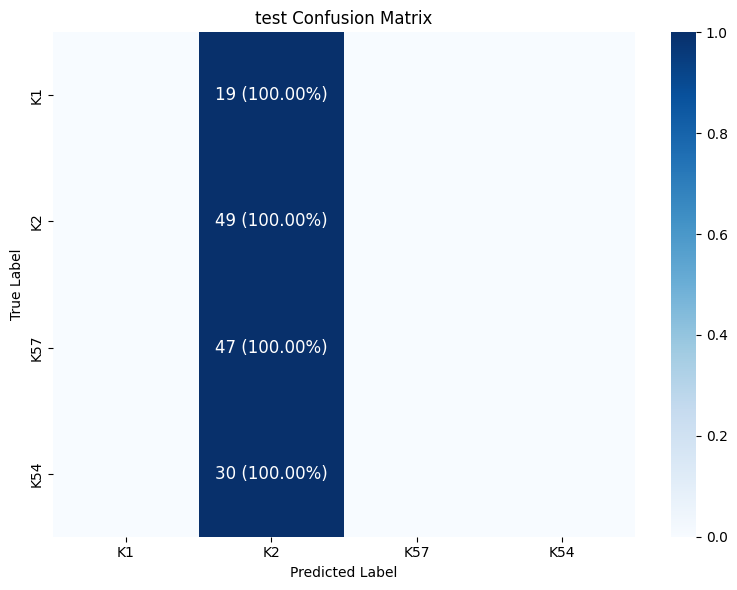

  Class  Precision  Recall  F1-Score  Support
0    K1       0.00     0.0      0.00       19
1    K2       0.34     1.0      0.51       49
2   K57       0.00     0.0      0.00       47
3   K54       0.00     0.0      0.00       30


In [ ]:
# Shuffle the labels for training, validation, and test sets to create a random permutation of data
y_perm_train_withoutintense = tf.random.shuffle(y_train_withoutintense)
y_perm_val_withoutintense = tf.random.shuffle(y_val_withoutintense)
y_perm_test_withoutintense = tf.random.shuffle(y_test_withoutintense)

# Initialize the Sequential model from Keras
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train_withoutintense.columns), 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes_grouped))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

# Compile the model using Adam optimizer with a specific learning rate, categorical crossentropy as loss function, and track accuracy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model on the shuffled training data
history_yrandom2 = model.fit(X_train_withoutintense.to_numpy(), y_perm_train_withoutintense, batch_size=32, epochs=12, verbose=2, validation_data=(X_val_withoutintense.to_numpy(), y_perm_val_withoutintense))

# Plot the training and validation accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(history_yrandom2.history['accuracy'])
plt.plot(history_yrandom2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Prepare data for evaluation
calcular = [{'que': 'train', 'X': X_train_withoutintense, 'y': y_perm_train_withoutintense},
            {'que': 'val', 'X': X_val_withoutintense, 'y': y_perm_val_withoutintense},
            {'que': 'test', 'X': X_test_withoutintense, 'y': y_perm_test_withoutintense}]

class_accuracies = {'train': [], 'val': [], 'test': []}

# Evaluate the model on the train, validation, and test sets
for i in range(len(calcular)):
    # Predict the output
    y_pred = model.predict(calcular[i]['X'].to_numpy())
    # Convert probabilities to integer labels
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    # Calculate accuracy
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    # Generate and normalize the confusion matrix
    cm = confusion_matrix(y_true_int, y_pred_int)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Plot the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    plt.title(f"{calcular[i]['que']} Confusion Matrix")
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=all_classes, yticklabels=all_classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=12)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Calculate and print class-wise metrics
    metrics_df = calculate_class_metrics_df(cm, all_classes)
    print(metrics_df)

### Figure 11

Figure 11: Y-randomization model training process for a 1-D CNN using the entire preprocessed spectra dataset (a) and Y-randomization model training excluding N1-type spectra from the dataset (b).

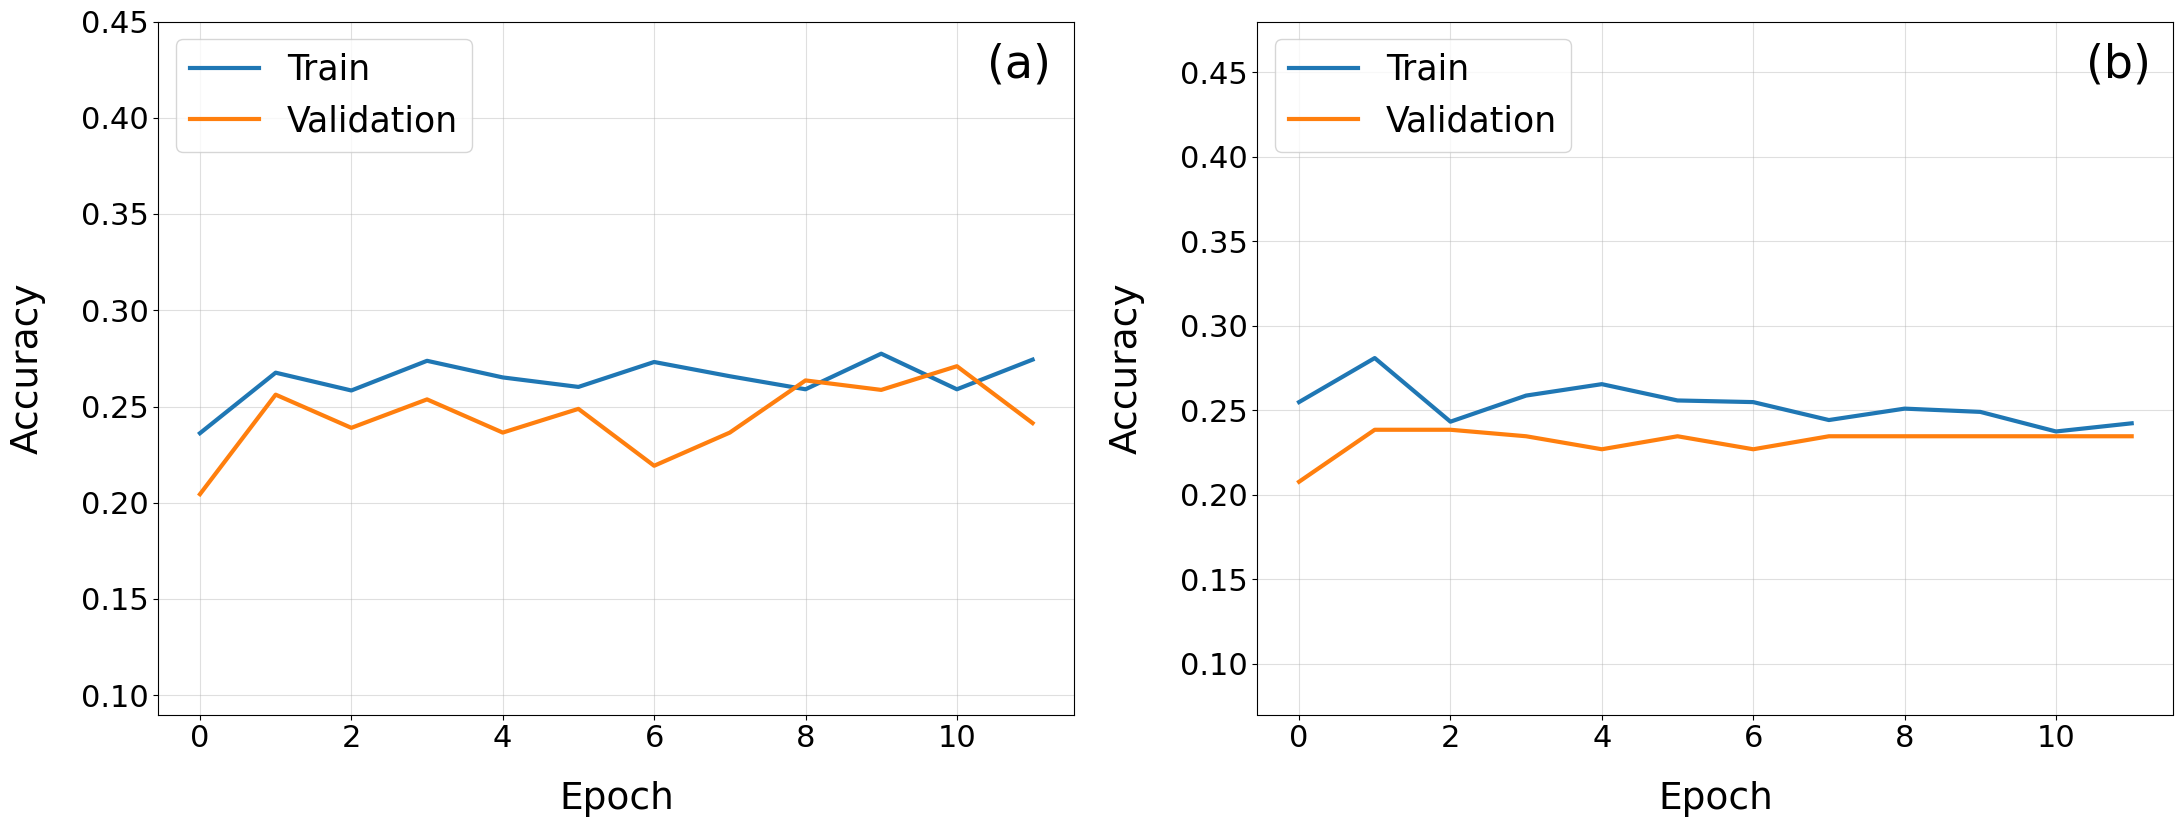

In [ ]:
# Create a figure with two subplots (ax11a and ax11b). This setup is intended for visual comparison of two training histories side by side.
fig11, (ax11a, ax11b) = plt.subplots(nrows=1, ncols=2, figsize=(26, 9))

# Define training history data for plotting in a structured way to facilitate iteration.
training_histories = [
    {'ax': ax11a, 'history': history_yrandom1.history, 'label_pos': '(a)'},
    {'ax': ax11b, 'history': history_yrandom2.history, 'label_pos': '(b)'}
]

# Common plotting parameters for consistency across both plots.
alphaVal = 1  # Opacity of the plot lines, where 1 is fully opaque.
linethick = 3  # Thickness of the plot lines.

for item in training_histories:
    ax = item['ax']  # Current subplot axis
    history = item['history']  # Training history for the current subplot
    label_pos = item['label_pos']  # Label position identifier for the subplot

    # Set the y-axis limits based on the subplot. Adjust if necessary for individual subplot specifics.
    ax.set_ylim([0.07, 0.48]) if label_pos == '(b)' else ax.set_ylim([0.09, 0.45])

    # Plot training and validation accuracy over epochs.
    ax.plot(history['accuracy'], lw=linethick, alpha=alphaVal)  # Plot training accuracy.
    ax.plot(history['val_accuracy'], lw=linethick, alpha=alphaVal)  # Plot validation accuracy.
    ax.grid(alpha=0.4)  # Add a grid to the plot with partial transparency for better readability.
    ax.set_ylabel('Accuracy', fontsize=27, labelpad=25)  # Label the y-axis as "Accuracy".
    ax.set_xlabel('Epoch', fontsize=27, labelpad=20)  # Label the x-axis as "Epoch".
    ax.legend(['Train', 'Validation'], loc='upper left', prop={'size': 25})  # Add a legend to distinguish training from validation data.
    ax.tick_params(axis='both', which='major', labelsize=22)  # Adjust the size of the tick labels for clarity.
    ax.text(0.905, 0.97, label_pos, transform=ax.transAxes, fontsize=33, verticalalignment='top')  # Annotate the subplot for reference.

fig11.savefig('fig11.svg', format='svg', dpi=300)
plt.show()


### Figure 13

Figure 13: Confusion matrix for the unseen data obtained from training a 1-D CNN model with all preprocessed spectra grouping K2 and K54 serotypes into a single class, ‘K2-K54’, (a) and a confusion matrix obtained from training the same 1-D CNN only with K2 and K54 serotypes (b). The overall accuracies achieved were 99% and 93%, respectively.

In [23]:
model = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/model3_kleb_allfeatures_3classes.h5')
model_bin = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/model4_kleb_allfeatures_binaryk2k54.h5')

5/5 [==============================] - 0s 26ms/step
test accuracy: 0.993
    Class  Precision  Recall  F1-Score  Support
0      K1       0.99    1.00      0.99      1.0
1  K2-K54       1.00    0.99      0.99      1.0
2     K57       1.00    1.00      1.00      1.0
4/4 [==============================] - 0s 21ms/step
test accuracy (binary): 0.928
  Class  Precision  Recall  F1-Score  Support
0    K2       0.94    0.92      0.93      1.0
1   K54       0.92    0.94      0.93      1.0


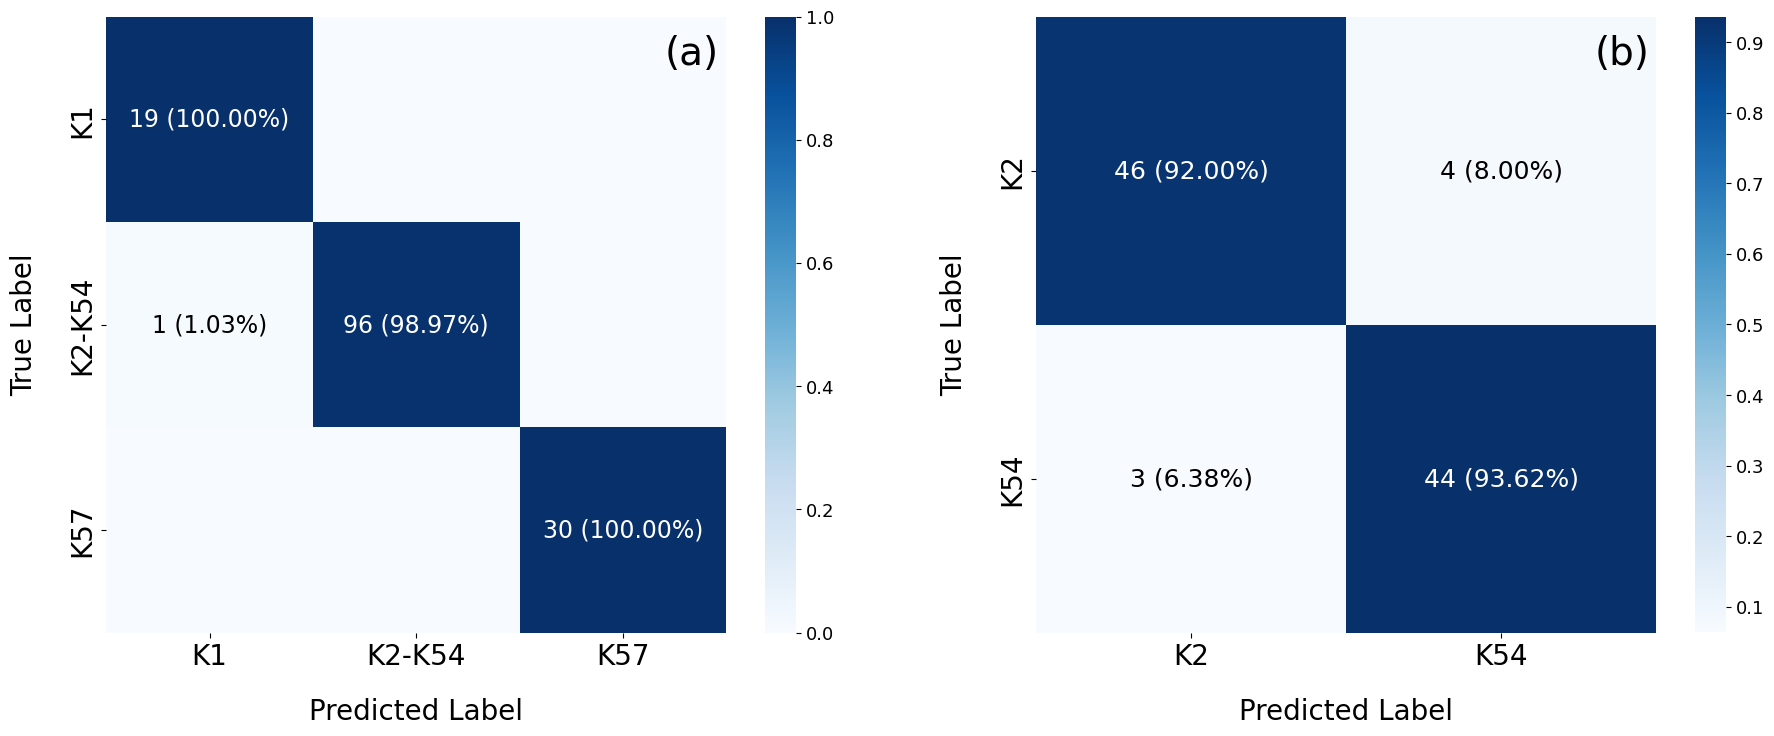

In [59]:
# Load trained models
model = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/model3_kleb_allfeatures_3classes.h5')
model_bin = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/model4_kleb_allfeatures_binaryk2k54.h5')

# Creating a subplot with 2 axes for later visualizations
fig13, (ax13a, ax13b) = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))
ax13a.text(0.9, 0.97, '(a)', transform=ax13a.transAxes, fontsize=28, verticalalignment='top')
ax13b.text(0.9, 0.97, '(b)', transform=ax13b.transAxes, fontsize=28, verticalalignment='top')

# Grouping phenotype K2 and K54 into a single category 'K2-K54' for analysis
filtered_data = filtered_data.copy()
filtered_data.loc[:, 'fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2-K54' if x in ['K2', 'K54'] else x)

# Filter the data to only include the binary classes of interest
binary_classes = ['K2-K54', 'K54-K2']
binary_data = filtered_data[filtered_data['fenotype_grouped'].isin(binary_classes)]

# Separating unseen data based on specific isolates measured on different days
conditions = [
(filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
(filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
]

# Combine all conditions to filter out unseen data
final_condition = conditions[0]
for condition in conditions[1:]:
    final_condition = final_condition | condition

# Exclude unseen data to form the train/validation dataset
unseens = filtered_data[final_condition]
# train/val dataset
filtered_data2 = filtered_data[~final_condition]


# Columns that are not features for the model training
columns_to_drop =  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date', 'fenotype_grouped']

# The label for classification
label = 'fenotype_grouped'

# Balancing the dataset by ensuring each class has the same number of samples
all_classes = filtered_data2[label].unique()

minority_class_size = filtered_data2[label].value_counts().min()

# Preparing the data for model training and evaluation
balanced_binary_data_trainval = pd.DataFrame()
balanced_trainval_data = pd.DataFrame()

for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]

    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()

# Splitting the balanced data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()

num_classes_grouped = len(all_classes)

# Encoding the labels for model training
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_val)
y_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

# Evaluating the model performance on test data
calcular = [
            {'que': 'test', 'X': X_test, 'y': y_test}]

class_accuracies = { 'test': []}

# Loop over the 'calcular' list to evaluate the model on test data
for i in range(len(calcular)):
    # Predict the outcomes for the given dataset
    y_pred = model.predict(calcular[i]['X'])
    # Convert predictions and true labels to their class indices
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    # Calculate the accuracy of predictions
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    # Compute the confusion matrix and normalize it
    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Plotting the normalized confusion matrix
    sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', ax=ax13a,
                              xticklabels=le.inverse_transform(np.arange(num_classes_grouped)),
                              yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    # Annotate the heatmap with the number of samples and percentages
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
                ax13a.text(j + 0.5, i + 0.5, text, ha='center', va='center', color=text_color, fontsize=17)
    cbar = sns_heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=13)

    # Calculate and print class-wise metrics
    metrics_df = calculate_class_metrics_df(cm_normalized, all_classes)
    print(metrics_df)


# Check if specific phenotypes exist in the dataset to adjust for binary classification
if 'K2-K54' in binary_data['fenotype_grouped'].values or 'K54-K2' in binary_data['fenotype_grouped'].values:
    all_classes_bin = 2  # number of classes for binary classification

    # Define conditions to filter unseen data based on isolate and date
    conditions = [
        (binary_data['isolate'] == 'kp382') & (binary_data['date'] == 120723),
        (binary_data['isolate'] == 'Kp188') & (binary_data['date'] == 120723),
    ]

    # Combine conditions to form a final condition for unseen data
    final_condition = conditions[0]
    for condition in conditions[1:]:
        final_condition = final_condition | condition

    # Filter unseen and training/validation data based on the final condition
    binary_data_unseens = binary_data[final_condition]
    binary_data_trainval = binary_data[~final_condition]

    # Label for classification
    label = 'fenotype'
    # Define classes for binary classification
    all_classes_ = ['K2', 'K54']

    # Balance the dataset to have equal number of samples for each class
    # Find the size of the minority class
    minority_class_size = binary_data_trainval[label].value_counts().min()
    balanced_binary_data_trainval = pd.DataFrame()
    for class_name in all_classes_:
        class_samples = binary_data[binary_data[label] == class_name]
        # Sample or use all samples to balance the dataset
        if class_samples.shape[0] > minority_class_size:
            reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, reduced_samples])
        else:
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, class_samples])

    # Prepare labels and features for training/validation
    balanced_y_trainval = balanced_binary_data_trainval[label]
    balanced_binary_data_trainval = balanced_binary_data_trainval.drop(columns=columns_to_drop).copy()

    # Split data into training and validation sets
    X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(balanced_binary_data_trainval, balanced_y_trainval, test_size=0.20, random_state=1000)

    # Prepare test set
    y_test_bin = binary_data_unseens['fenotype']
    X_test_bin = binary_data_unseens.drop(columns=columns_to_drop)

    # Encode labels
    le = LabelEncoder()
    y_train_encoded_bin = le.fit_transform(y_train_bin)
    y_train_bin = tf.keras.utils.to_categorical(y_train_encoded_bin, num_classes=2)
    y_test_encoded_bin = le.transform(y_test_bin)
    y_test_bin = tf.keras.utils.to_categorical(y_test_encoded_bin, num_classes=2)
    y_val_encoded_bin = le.transform(y_val_bin)
    y_val_bin = tf.keras.utils.to_categorical(y_val_encoded_bin, num_classes=2)

    # Predict and evaluate model on binary classification task
    for data_label, X, y in [('test', X_test_bin, y_test_bin)]:
        y_pred_bin = model_bin.predict(X)
        y_pred_int_bin = np.argmax(y_pred_bin, axis=1)
        y_true_int_bin = np.argmax(y, axis=1)
        accuracy_bin = accuracy_score(y_true_int_bin, y_pred_int_bin)
        print(f"{data_label} accuracy (binary): {accuracy_bin:1.3f}")
        # Calculate and normalize confusion matrix
        cm_bin = confusion_matrix(y_true_int_bin, y_pred_int_bin, labels=np.arange(all_classes_bin))
        cm_normalized_bin = cm_bin.astype('float') / cm_bin.sum(axis=1, keepdims=True)

        # Generate a heatmap visualization for the normalized confusion matrix.
        sns_heatmap2 = sns.heatmap(cm_normalized_bin, annot=False, fmt='.2%', cmap='Blues', ax=ax13b,
                                  xticklabels=le.inverse_transform(np.arange(all_classes_bin)),
                                  yticklabels=le.inverse_transform(np.arange(all_classes_bin)))

        # Iterate through each cell of the confusion matrix to add text annotations.
        for i in range(cm_bin.shape[0]):
            for j in range(cm_bin.shape[1]):
                value = cm_bin[i, j]  # Retrieve the raw count of predictions.
                # Check if the cell value is non-zero and not NaN before annotating.
                if value != 0 and not np.isnan(cm_normalized_bin[i, j]):
                    # Format the text to include both raw count and percentage.
                    text = f"{value} ({cm_normalized_bin[i, j] * 100:.2f}%)"
                    # Choose text color for readability based on the background.
                    text_color = "white" if cm_normalized_bin[i, j] > 0.5 else "black"
                    # Place the text annotation in the cell.
                    ax13b.text(j + 0.5, i + 0.5, text, ha='center', va='center',
                              color=text_color, fontsize=18)

        # Customize the colorbar to match the label size for consistency.
        cbar2 = sns_heatmap2.collections[0].colorbar
        cbar2.ax.tick_params(labelsize=13)
        # Calculate and print class-wise metrics
        metrics_df = calculate_class_metrics_df(cm_normalized_bin, all_classes_)
        print(metrics_df)

# Setting labels, titles, legends, and formatting for ax13a and ax13b
for ax in [ax13a, ax13b]:
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlabel('Predicted Label', fontsize=20, labelpad=20)
    ax.set_ylabel('True Label', fontsize=20, labelpad=22)

fig13.savefig('fig13.svg', format='svg', dpi=300)
plt.show()

### Figure 14

Figure 14: Y-randomization model training process for a 1-D CNN grouping K2 and K54 serotypes into a single class (a), and Y-randomization model training only with K2 and K54 serotypes (b).

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 2400, 64)          576       
                                                                 
 activation_3 (Activation)   (None, 2400, 64)          0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 1200, 64)          0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 1200, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 76800)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               9830528   
                                                      

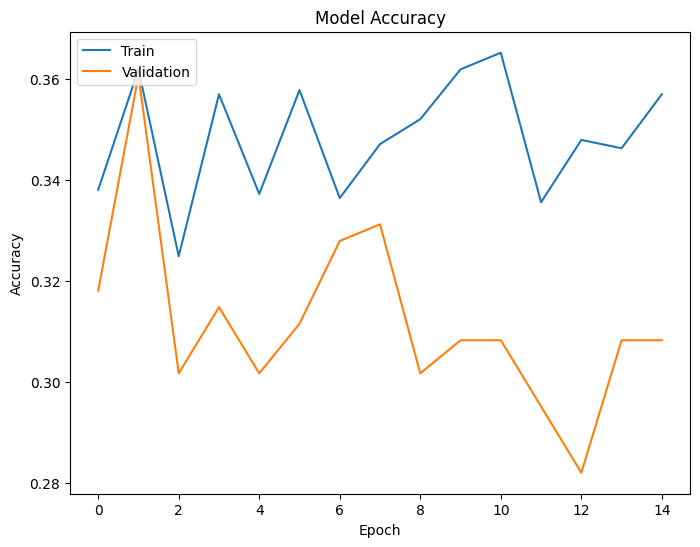

38/38 [==============================] - 1s 35ms/step
train accuracy: 0.342


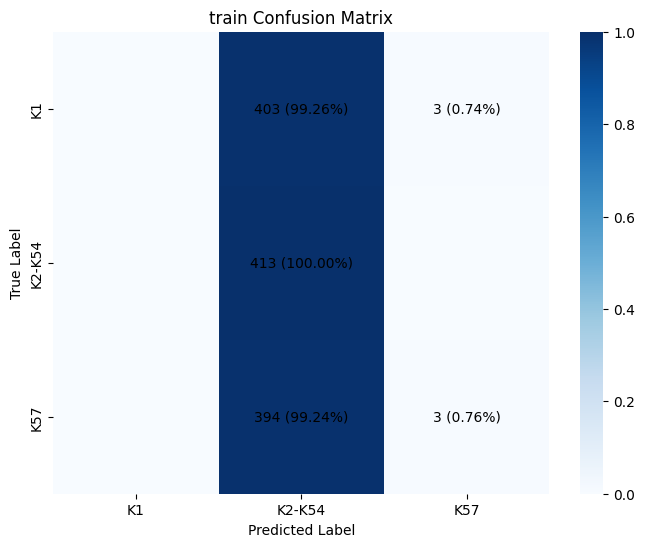

10/10 [==============================] - 1s 36ms/step
val accuracy: 0.308


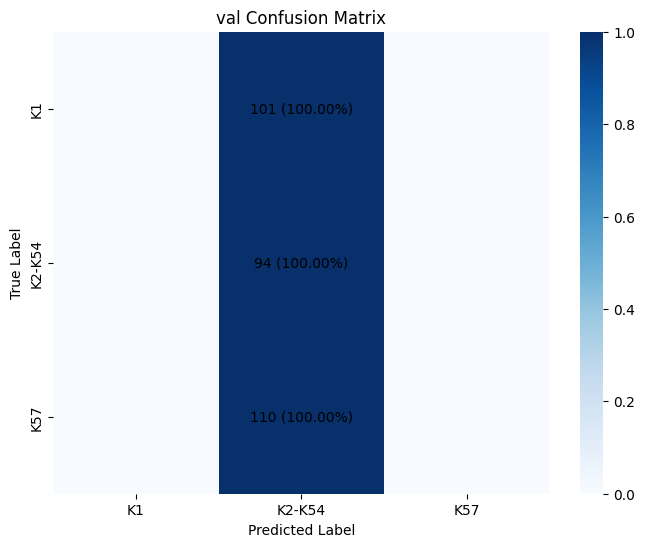

5/5 [==============================] - 0s 26ms/step
test accuracy: 0.664


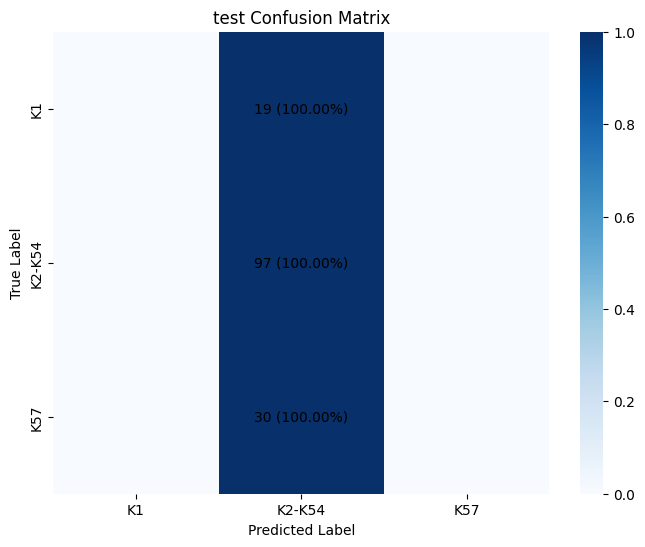

Epoch 1/15
28/28 - 5s - loss: 0.6961 - accuracy: 0.4989 - val_loss: 0.6931 - val_accuracy: 0.5045 - 5s/epoch - 181ms/step
Epoch 2/15
28/28 - 5s - loss: 0.6939 - accuracy: 0.4967 - val_loss: 0.6942 - val_accuracy: 0.4911 - 5s/epoch - 166ms/step
Epoch 3/15
28/28 - 5s - loss: 0.6930 - accuracy: 0.5156 - val_loss: 0.6936 - val_accuracy: 0.4911 - 5s/epoch - 173ms/step
Epoch 4/15
28/28 - 5s - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.4911 - 5s/epoch - 164ms/step
Epoch 5/15
28/28 - 4s - loss: 0.6934 - accuracy: 0.4989 - val_loss: 0.6930 - val_accuracy: 0.5357 - 4s/epoch - 151ms/step
Epoch 6/15
28/28 - 4s - loss: 0.6930 - accuracy: 0.5145 - val_loss: 0.6932 - val_accuracy: 0.4911 - 4s/epoch - 146ms/step
Epoch 7/15
28/28 - 5s - loss: 0.6929 - accuracy: 0.5301 - val_loss: 0.6938 - val_accuracy: 0.4911 - 5s/epoch - 171ms/step
Epoch 8/15
28/28 - 4s - loss: 0.6928 - accuracy: 0.5145 - val_loss: 0.6932 - val_accuracy: 0.4911 - 4s/epoch - 146ms/step
Epoch 9/15
28/28 - 5s - 

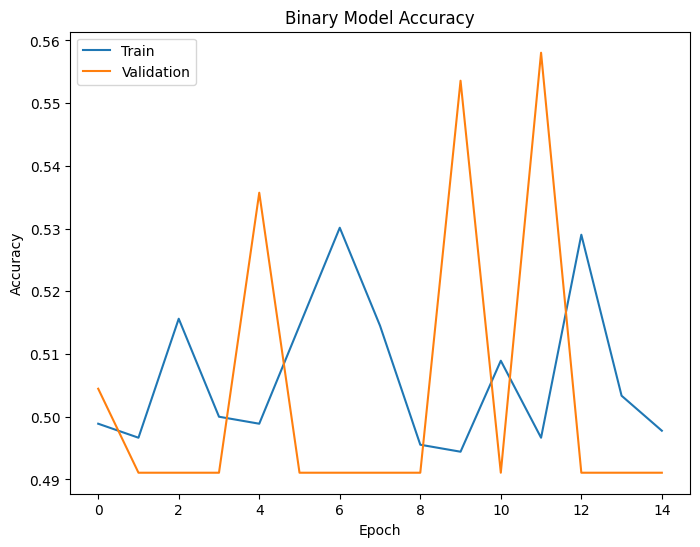

28/28 [==============================] - 1s 28ms/step
train accuracy: 0.502


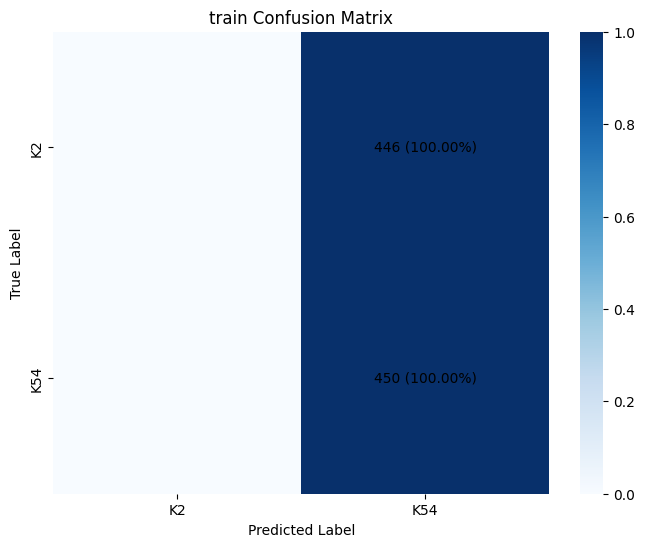

7/7 [==============================] - 0s 30ms/step
val accuracy: 0.491


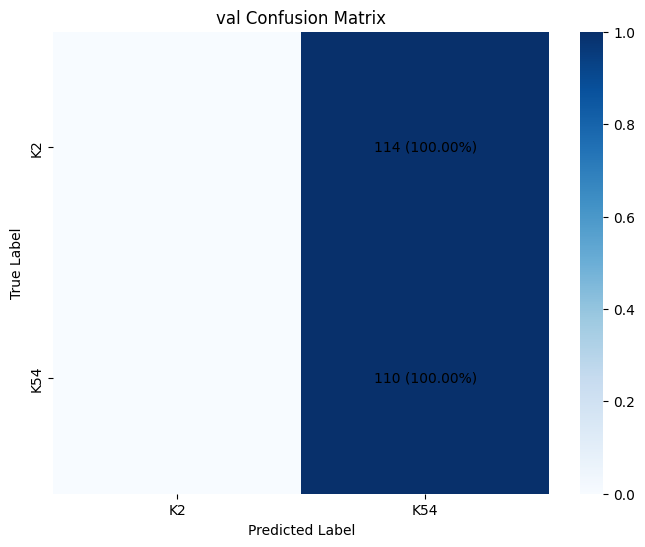

4/4 [==============================] - 0s 20ms/step
test accuracy: 0.485


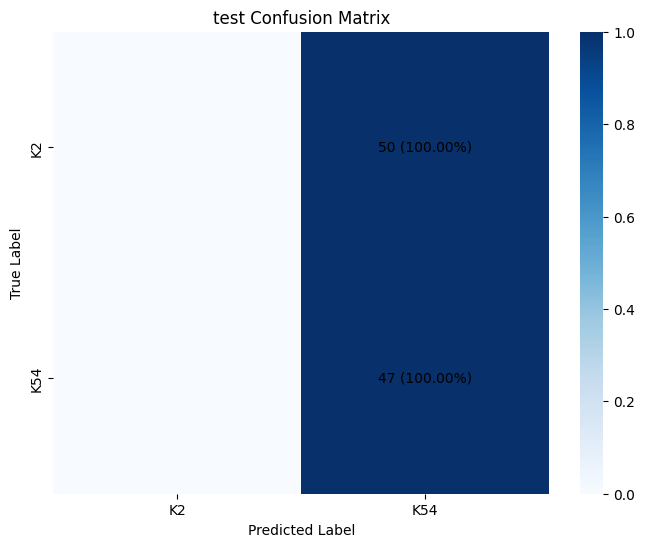

In [67]:
# Randomly shuffle the labels for training, validation, and test sets
y_perm_train = tf.random.shuffle(y_train, seed=1000)
y_perm_val = tf.random.shuffle(y_val, seed=1000)
y_perm_test = tf.random.shuffle(y_test, seed=1000)

# Define the CNN model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train.columns), 1), activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes_grouped, activation='softmax')
])

# Compile the model with the Adam optimizer and categorical crossentropy loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model with the randomly shuffled labels
history = model.fit(
    X_train.to_numpy(), y_perm_train,
    batch_size=32, epochs=15, verbose=2,
    validation_data=(X_val.to_numpy(), y_perm_val)
)

# Plot training and validation accuracy over epochs to visualize the learning process
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation')  # Plot validation accuracy
plt.title('Model Accuracy')  # Title of the plot
plt.ylabel('Accuracy')  # Y-axis label
plt.xlabel('Epoch')  # X-axis label
plt.legend(loc='upper left')  # Legend location
plt.show()  # Display the plot

# Define datasets for evaluation: training, validation, and testing
calcular = [{'que': 'train', 'X': X_train, 'y': y_perm_train},
            {'que': 'val', 'X': X_val, 'y': y_perm_val},
            {'que': 'test', 'X': X_test, 'y': y_perm_test}]

class_accuracies = {'train': [], 'val': [], 'test': []}  # Initialize dictionary to store accuracies

# Iterate through each dataset to evaluate the model
for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])  # Predict outputs for the dataset
    y_pred_int = tf.argmax(y_pred, axis=1)  # Convert predictions to integer labels
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)  # Convert true labels to integer labels
    accuracy = accuracy_score(y_true_int, y_pred_int)  # Calculate accuracy
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")  # Print accuracy

    # Calculate and normalize the confusion matrix
    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

    # Plot the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    plt.title(f"{calcular[i]['que']} Confusion Matrix")
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=all_classes, yticklabels=all_classes)
    # Annotate cells with the absolute number of observations and the percentage
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Check for specific binary classes in the data
if 'K2-K54' in binary_data['fenotype_grouped'].values or 'K54-K2' in binary_data['fenotype_grouped'].values:
    # Preprocessing and model setup for binary classification
    all_classes_bin = 2  # Number of classes for binary classification
    label = 'fenotype'  # Label for binary classification
    all_classes_ = ['K2', 'K54']  # Classes involved in binary classification

    # Shuffle binary labels for each dataset to ensure random distribution
    y_train_bin = tf.random.shuffle(y_train_bin, seed=1000)
    y_val_bin = tf.random.shuffle(y_val_bin, seed=1000)
    y_test_bin = tf.random.shuffle(y_test_bin, seed=1000)

    # Setup optimizer with a lower learning rate for fine-tuning binary classification
    binary_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    model_bin = tf.keras.models.Sequential(model.layers[:-1])  # Reuse layers from the main model except the last one
    model_bin.add(tf.keras.layers.Dense(2, activation='softmax'))  # Add new binary output layer
    model_bin.compile(loss='categorical_crossentropy', optimizer=binary_optimizer, metrics=['accuracy'])

    # Train the binary classification model
    binary_history = model_bin.fit(X_train_bin.to_numpy(), y_train_bin, batch_size=32, epochs=15, verbose=2, validation_data=(X_val_bin.to_numpy(), y_val_bin))

    # Plot training and validation accuracy for binary model
    plt.figure(figsize=(8, 6))
    plt.plot(binary_history.history['accuracy'], label='Train')
    plt.plot(binary_history.history['val_accuracy'], label='Validation')
    plt.title('Binary Model Accuracy')  # Title of the plot for binary model
    plt.ylabel('Accuracy')  # Y-axis label
    plt.xlabel('Epoch')  # X-axis label
    plt.legend(['Train', 'Validation'], loc='upper left')  # Legend for the plot
    plt.show()  # Display the plot

    # Similar evaluation process for binary classification as done for multi-class classification above
    calcular_bin = [{'que': 'train', 'X': X_train_bin, 'y': y_train_bin},
                    {'que': 'val', 'X': X_val_bin, 'y': y_val_bin},
                    {'que': 'test', 'X': X_test_bin, 'y': y_test_bin}]

    class_accuracies_bin = {'train': [], 'val': [], 'test': []}  # Initialize dictionary to store binary accuracies

    # Iterate through each binary dataset to evaluate the model
    for i in range(len(calcular_bin)):
        y_pred_bin = model_bin.predict(calcular_bin[i]['X'])  # Predict binary outputs
        y_pred_int_bin = np.argmax(y_pred_bin, axis=1)  # Convert binary predictions to integer labels
        y_true_int_bin = np.argmax(calcular_bin[i]['y'], axis=1)  # Convert binary true labels to integer labels
        accuracy_bin = accuracy_score(y_true_int_bin, y_pred_int_bin)  # Calculate binary accuracy
        print(f"{calcular_bin[i]['que']} accuracy: {accuracy_bin:1.3f}")  # Print binary accuracy

        # Calculate and normalize the binary confusion matrix
        cm_bin = confusion_matrix(y_true_int_bin, y_pred_int_bin, labels=np.arange(all_classes_bin))
        cm_normalized_bin = cm_bin.astype('float') / cm_bin.sum(axis=1, keepdims=True)

        # Plot the normalized binary confusion matrix
        plt.figure(figsize=(8, 6))
        plt.title(f"{calcular_bin[i]['que']} Confusion Matrix")
        sns.heatmap(cm_normalized_bin, annot=False, fmt='.2%', cmap='Blues', xticklabels=all_classes_, yticklabels=all_classes_)
        # Annotate cells with the absolute number of observations and the percentage for binary classification
        for i in range(cm_bin.shape[0]):
            for j in range(cm_bin.shape[1]):
                value = cm_bin[i, j]
                if value != 0 and not np.isnan(cm_normalized_bin[i, j]):
                    text = f"{value} ({cm_normalized_bin[i, j] * 100:.2f}%)"
                    plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

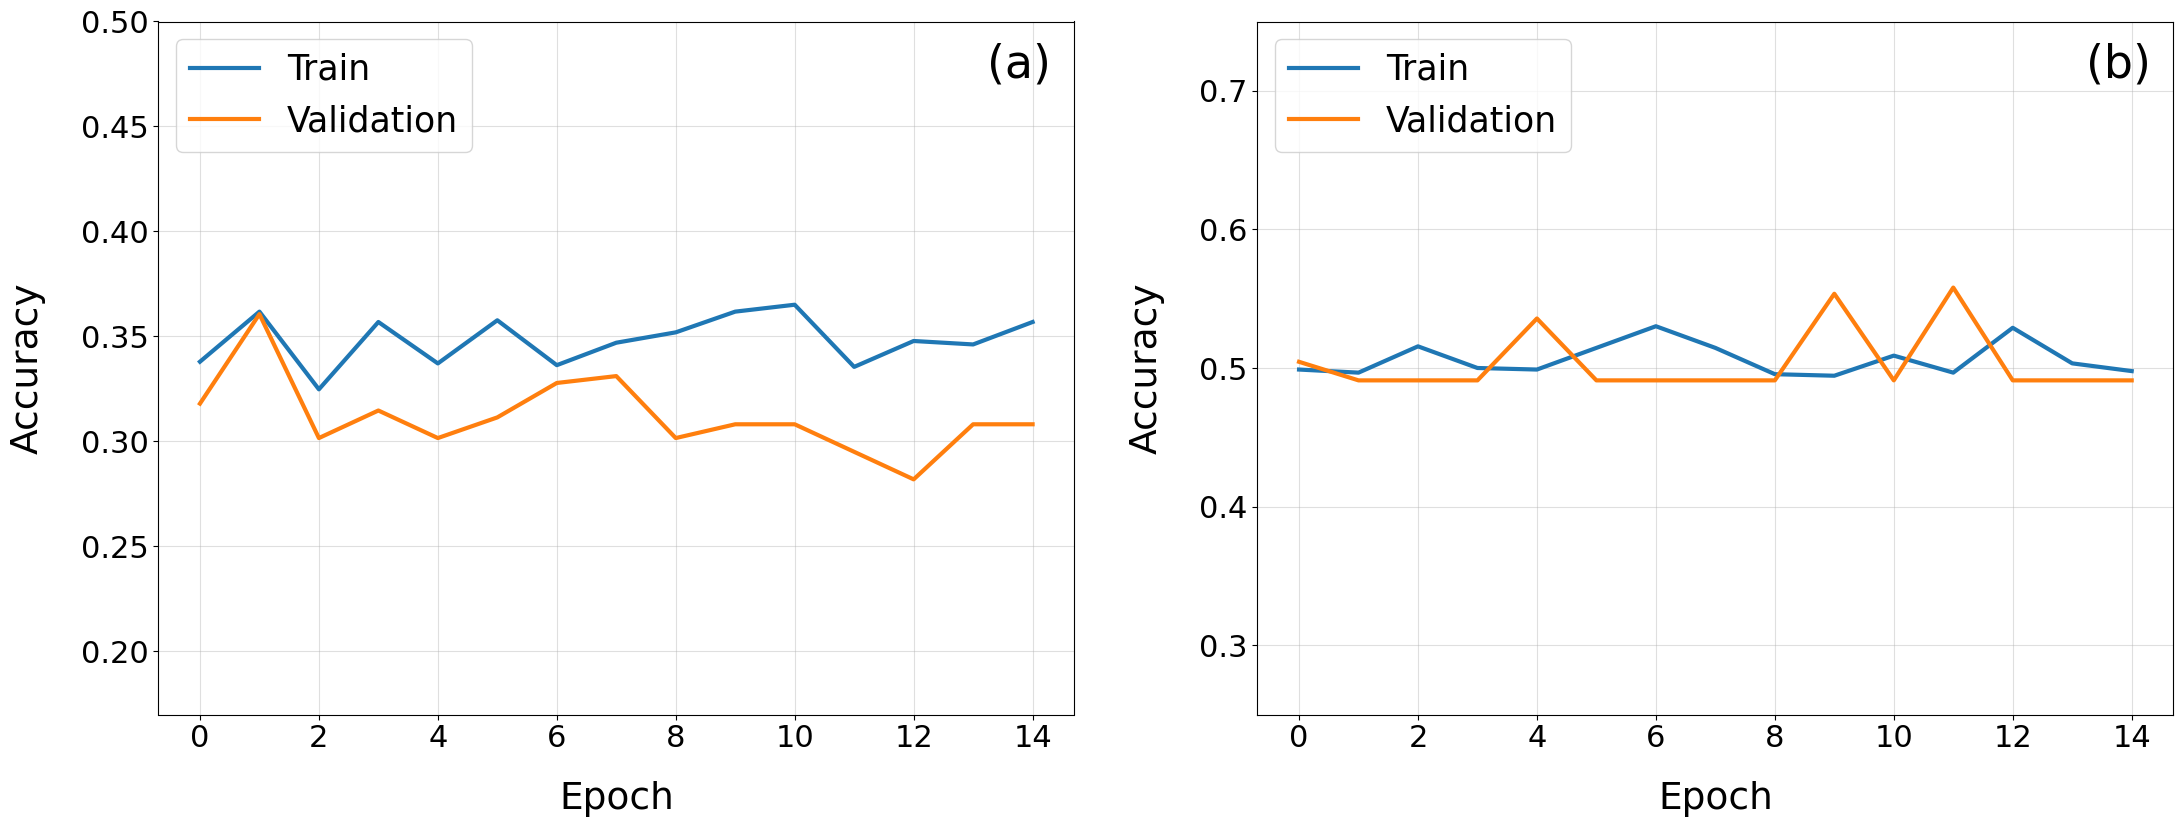

In [68]:
# Create a figure with two subplots side by side (1 row, 2 columns) with a specific figure size
fig14, (ax14a, ax14b) = plt.subplots(nrows=1, ncols=2, figsize=(26, 9))

# Define common styling parameters for the plots
alphaVal = 1  # Opacity of the plot lines
linethick = 3  # Thickness of the plot lines

# Plotting training and validation accuracy on the first subplot (ax14a)
ax14a.set_ylim([0.17, 0.50])  # Set the y-axis limits for ax14a
ax14a.plot(history.history['accuracy'], lw=linethick, alpha=alphaVal)  # Plot training accuracy
ax14a.plot(history.history['val_accuracy'], lw=linethick, alpha=alphaVal)  # Plot validation accuracy
ax14a.grid(alpha=0.4)  # Add grid to the plot with a specific opacity
ax14a.set_ylabel('Accuracy', fontsize=27, labelpad=25)  # Set the y-axis label with specific font size and label padding
ax14a.set_xlabel('Epoch', fontsize=27, labelpad=20)  # Set the x-axis label
ax14a.legend(['Train', 'Validation'], loc='upper left', prop={'size': 25})  # Add legend with custom properties
ax14a.tick_params(axis='both', which='major', labelsize=22)  # Customize the tick parameters for both axes
ax14a.text(0.905, 0.97, '(a)', transform=ax14a.transAxes, fontsize=33, verticalalignment='top')  # Add text annotation within ax14a

# Plotting training and validation accuracy for the binary model on the second subplot (ax14b)
ax14b.set_ylim([0.25, 0.75])  # Set the y-axis limits for ax14b
ax14b.plot(binary_history.history['accuracy'], lw=linethick, alpha=alphaVal)  # Plot binary training accuracy
ax14b.plot(binary_history.history['val_accuracy'], lw=linethick, alpha=alphaVal)  # Plot binary validation accuracy
ax14b.grid(alpha=0.4)  # Add grid with specific opacity
ax14b.set_ylabel('Accuracy', fontsize=27, labelpad=25)  # Set y-axis label
ax14b.set_xlabel('Epoch', fontsize=27, labelpad=20)  # Set x-axis label
ax14b.legend(['Train', 'Validation'], loc='upper left', prop={'size': 25})  # Add legend with custom size
ax14b.tick_params(axis='both', which='major', labelsize=22)  # Customize tick parameters
ax14b.text(0.905, 0.97, '(b)', transform=ax14b.transAxes, fontsize=33, verticalalignment='top')  # Add text annotation within ax14b

fig14.savefig('fig14.svg', format='svg', dpi=300)
plt.show()

# 3.3. Dimensionality reduction

### Figure 15

Figure 15: Dimensionality reduction of Raman spectra by averaging consecutive features.

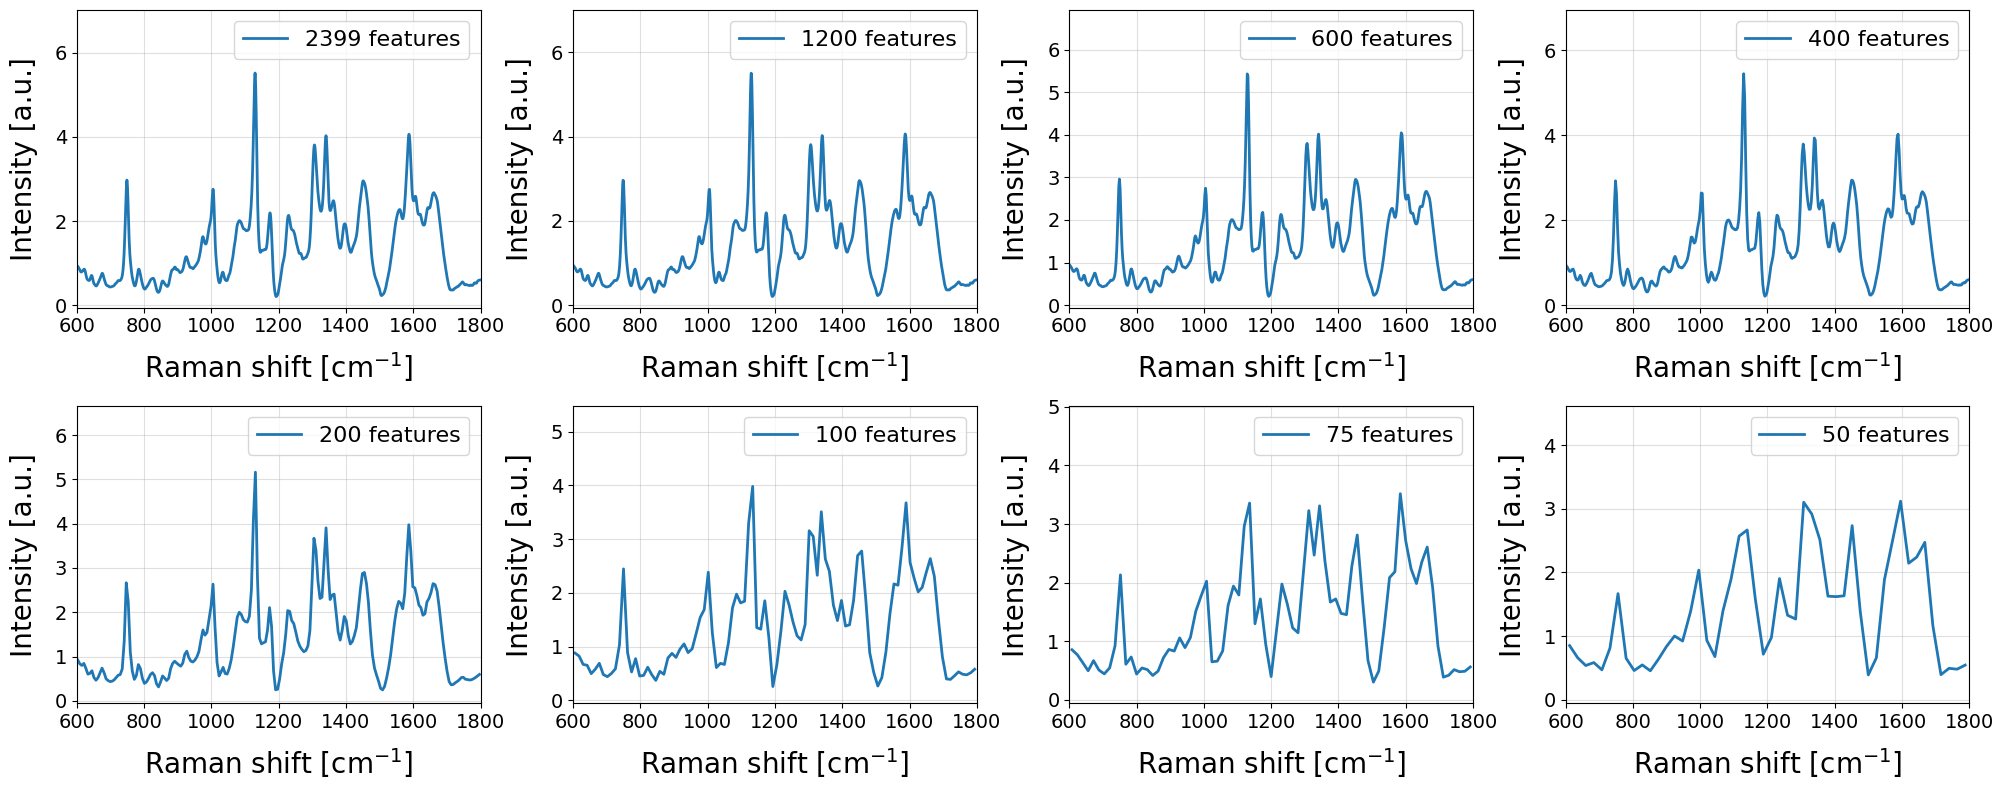

In [ ]:
# Define the step sizes for dimensionality reduction
steps = [1, 2, 4, 6, 12, 24, 32, 48]

# Initialize a figure with subplots arranged in a 2x4 grid
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.ravel()

# Pre-processing to exclude non-feature columns
spectral_data = filtered_data.iloc[:, :-10]

for idx, step in enumerate(steps):
    # Calculate the reduced number of features
    num_reduced_features = np.ceil(len(spectral_data.columns) / step).astype(int)

    # Initialize lists to store reduced data
    reduced_spectra = []
    reduced_ramanshifts = []

    # Perform averaging over the specified step size
    for i in range(0, len(spectral_data.columns), step):
        averaged_spectrum = spectral_data.iloc[:, i:i+step].mean(axis=1)
        reduced_spectra.append(averaged_spectrum)
        reduced_ramanshifts.append(np.mean(ramanshifts[i:i+step]))

    # Combine reduced spectra into a DataFrame
    reduced_df = pd.concat(reduced_spectra, axis=1)
    reduced_df.columns = reduced_ramanshifts

    # Plotting the mean spectrum for the current step size
    axs[idx].plot(reduced_ramanshifts, reduced_df.mean(axis=0), label=f'{num_reduced_features} features', lw=2)
    axs[idx].legend(loc='upper right', fontsize=16)
    axs[idx].grid(alpha=0.4)
    axs[idx].set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=20, labelpad=10)
    axs[idx].set_ylabel(r'Intensity [a.u.]', fontsize=20, labelpad=12)
    axs[idx].set_xlim([600, 1800])
    axs[idx].tick_params(axis='both', which='major', labelsize=14)
    axs[idx].set_ylim([ax.get_ylim()[0], reduced_df.mean(axis=0).max() + 1.5])

plt.tight_layout()
plt.savefig('dimensionality_reduction.svg', format='svg', dpi=300)
plt.show()

In [ ]:
# Set the step size for reducing the number of features
steps = [4]

# Loop through each step size (though there is only one in this case)
for idx, step in enumerate(steps):
    # Calculate the number of columns after reduction
    num_reduced_columns = len(filtered_data.iloc[:, :-9].columns) // step

    # Initialize lists to store the reduced columns and Raman shifts
    reduced_columns = []
    reduced_ramanshifts = []

    # Iterate over the columns in steps and average the data within each step
    for i in range(0, len(filtered_data.iloc[:, :-9].columns), step):
        # Average columns in the range [i, i+step)
        avg_columns = filtered_data.iloc[:, :-9].iloc[:, i:i + step].mean(axis=1)
        reduced_columns.append(avg_columns)

        # Calculate the average Raman shift for the current range
        reduced_ramanshifts.append(np.mean(ramanshifts[i:i + step]))

    # Concatenate the reduced columns to form a new DataFrame
    filtered_data_reduced = pd.concat(reduced_columns, axis=1)

    # Set the new column names to be the averaged Raman shifts
    filtered_data_reduced.columns = reduced_ramanshifts

# Add additional columns to the reduced data from the original dataset
filtered_data_reduced[columns_to_drop] = filtered_data[columns_to_drop]

### Figure 16

Figure 16: Accuracy variations in 1-D CNN models as Raman spectra dimensionality decreases. Three cases are considered, color-coded as follows: classifying into 4 serotypes (K1, K2, K54, K57) in blue, grouping K2 and K54 (K1, K2-54, K7) in orange, and binary classification (K2 vs. K54) in green.

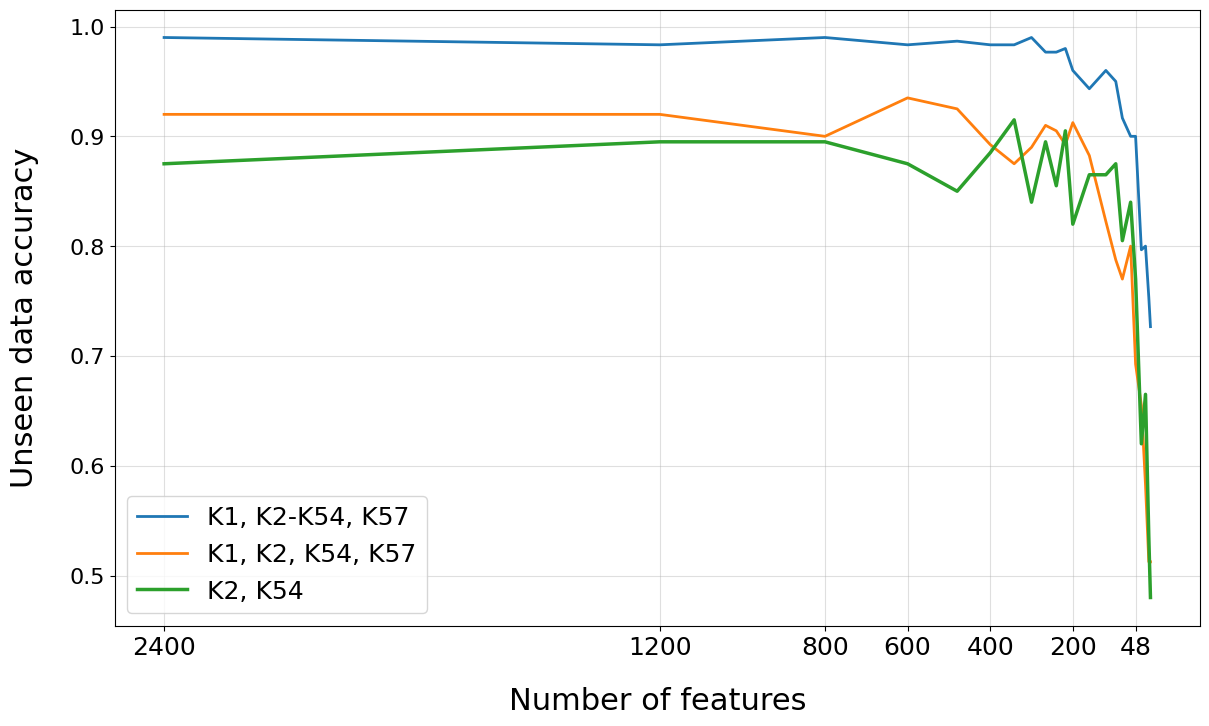

In [ ]:
# Loading test accuracy values
test_accuracy_values = pd.read_csv('/content/drive/MyDrive/klebsiellas/test_accuracy_values.csv')

# Defining the initial number of features and calculating the number of features
# for different reduction steps based on division
features_step_1 = 2400
steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 25, 30, 40, 50, 70, 100, 150, 200]
num_features_list = [features_step_1 // step for step in steps]
feature_steps_list2 = [(1800 - 600) / x for x in feature_steps_list]

fig, ax = plt.subplots(figsize=(14, 8))
# Plotting test accuracy values for different configurations against the number of features
plt.plot(num_features_list, test_accuracy_values['K1_K2K54_K57'][0:22], label='K1, K2-K54, K57', linewidth=2)
plt.plot(num_features_list, test_accuracy_values['K1_K2_K54_K57'][0:22], label='K1, K2, K54, K57', linewidth=2)
plt.plot(num_features_list, test_accuracy_values['onlyK2K54'][0:22], label='K2, K54', linewidth=2.5)
plt.xlabel('Number of features', fontsize=22, labelpad=20)
plt.ylabel('Unseen data accuracy', fontsize=22, labelpad=22)
plt.yticks(fontsize=16)
plt.grid(alpha=0.4)
plt.legend(loc='lower left', fontsize=18)
plt.xticks(num_features_list2, fontsize=18)
plt.gca().invert_xaxis()
plt.savefig('fig16.svg', format='svg', dpi=300)
plt.show()

### Figure 17

Figure 17: Saliency plots correspond to all possible pairs of serotypes.

In [ ]:
output_diff_df_k1k2 = pd.read_csv('/content/drive/MyDrive/klebsiellas/resultadossaliencias/output_diff_df_k1k2.csv')
output_diff_df_k1k54 = pd.read_csv('/content/drive/MyDrive/klebsiellas/resultadossaliencias/output_diff_df_k1k54.csv')
output_diff_df_k1k57 = pd.read_csv('/content/drive/MyDrive/klebsiellas/resultadossaliencias/output_diff_df_k1k57.csv')
output_diff_df_k2k54 = pd.read_csv('/content/drive/MyDrive/klebsiellas/resultadossaliencias/output_diff_df_k2k54.csv')
output_diff_df_k2k57 = pd.read_csv('/content/drive/MyDrive/klebsiellas/resultadossaliencias/output_diff_df_k57k2.csv')
output_diff_df_k54k57 = pd.read_csv('/content/drive/MyDrive/klebsiellas/resultadossaliencias/output_diff_df_k57k54.csv')

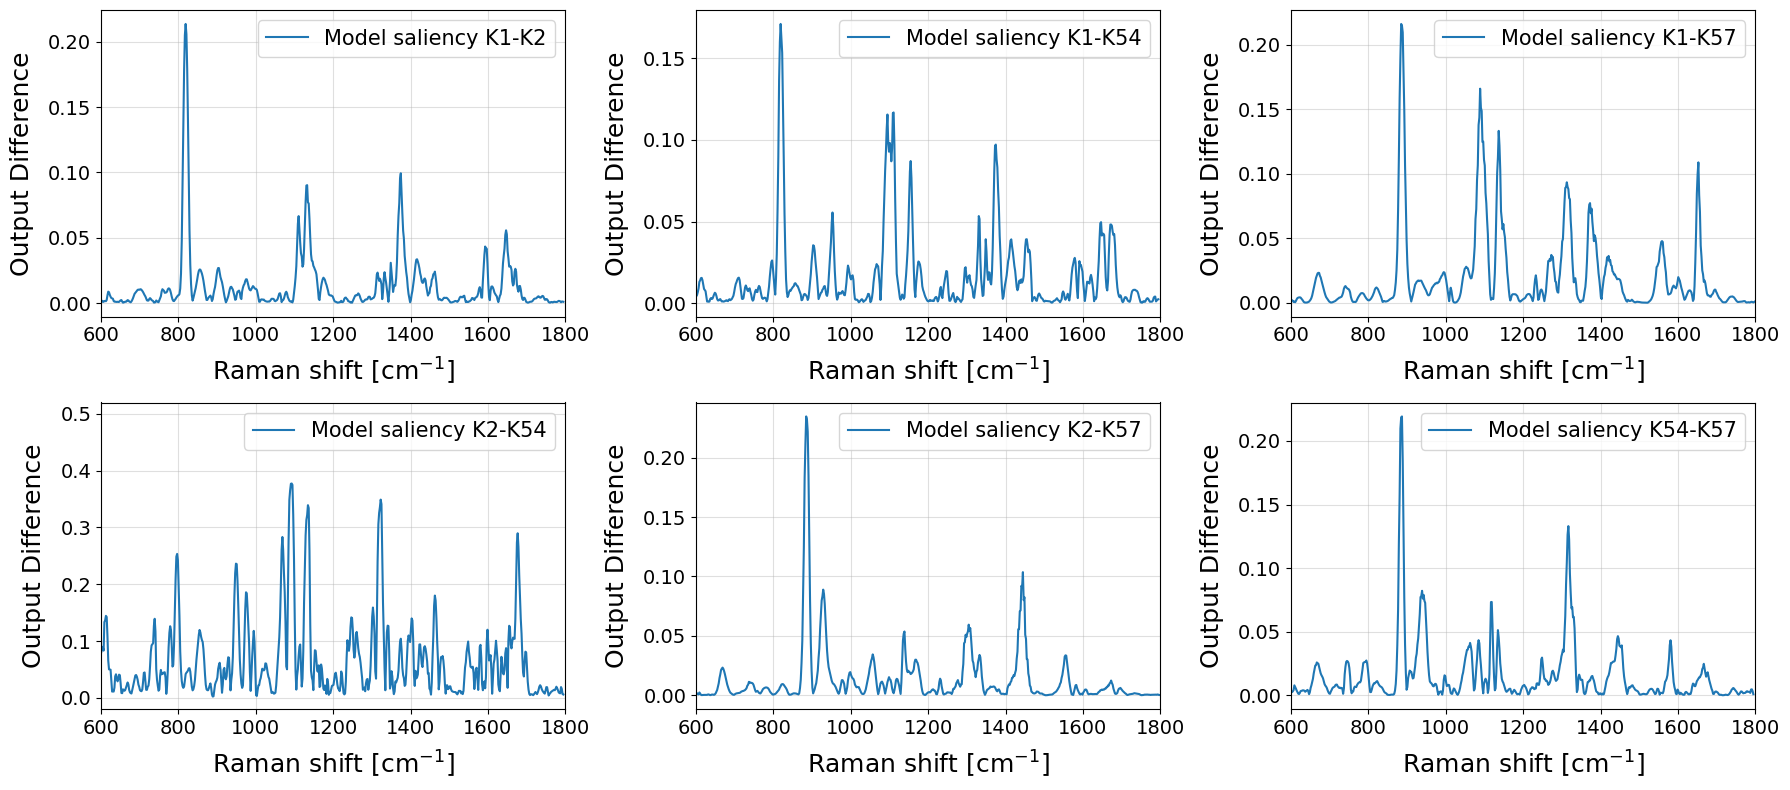

In [ ]:

fig, axs = plt.subplots(2, 3, figsize=(18, 8))

# Data and labels for each subplot
data = [
    (output_diff_df_k1k2.iloc[:, 0], output_diff_df_k1k2.iloc[:, 1], 'Model saliency K1-K2'),
    (output_diff_df_k1k54.iloc[:, 0], output_diff_df_k1k54.iloc[:, 1], 'Model saliency K1-K54'),
    (output_diff_df_k1k57.iloc[:, 0], output_diff_df_k1k57.iloc[:, 1], 'Model saliency K1-K57'),
    (output_diff_df_k2k54.iloc[:, 0], output_diff_df_k2k54.iloc[:, 1], 'Model saliency K2-K54'),
    (output_diff_df_k2k57.iloc[:, 0], output_diff_df_k2k57.iloc[:, 1], 'Model saliency K2-K57'),
    (output_diff_df_k54k57.iloc[:, 0], output_diff_df_k54k57.iloc[:, 1], 'Model saliency K54-K57')
]

# Iterate over the grid and populate with data
for ax, (x, y, label) in zip(axs.flatten(), data):
    ax.plot(x, y, color='C0', label=label, lw=1.5)
    ax.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=18, labelpad=8)
    ax.set_ylabel('Output Difference', fontsize=18, labelpad=10)
    ax.legend(loc='upper right', prop={'size': 15})
    ax.grid(True, alpha=0.4)
    ax.set_xlim([600, 1800])
    ax.tick_params(axis='both', which='major', labelsize=14)

axs[1, 0].set_ylim([-0.02, 0.52])
plt.tight_layout()
plt.savefig('fig17.svg', format='svg', dpi=300)
plt.show()


### Figure 18

Figure 18: Average contribution of each capsular serotype to the saliency: K1 (a), K2 (b), K54 (c) and K57 (d).

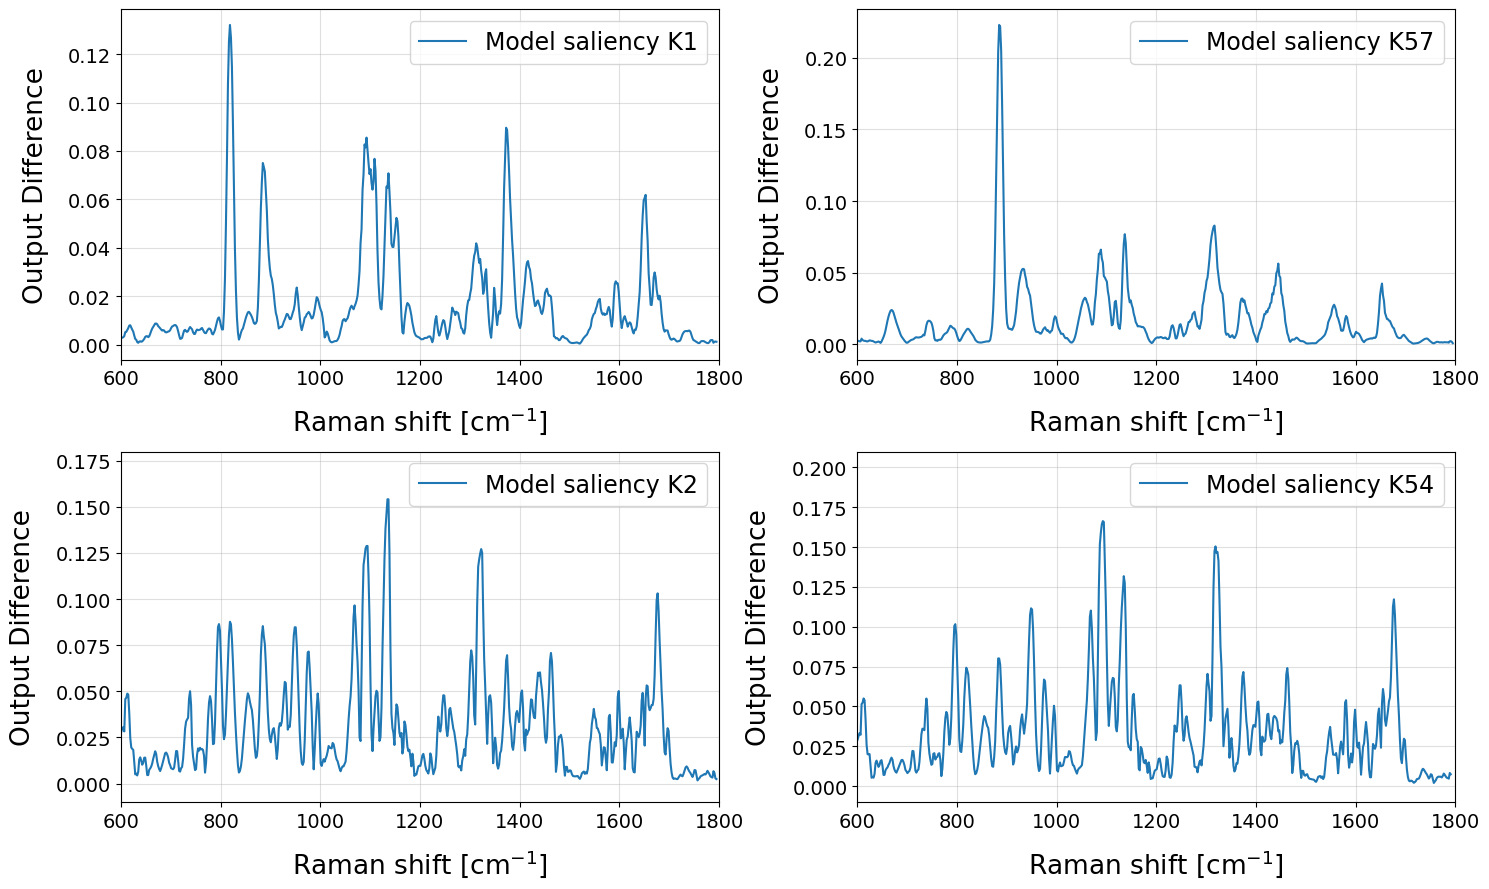

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))

# Data processing and plotting for each subplot
# For K1 average
avg_k1 = pd.DataFrame((output_diff_df_k1k2.iloc[:, 1] + output_diff_df_k1k54.iloc[:, 1] + output_diff_df_k1k57.iloc[:-2, 1]) / 3)
axs[0, 0].plot(output_diff_df_k1k2.iloc[:, 0], avg_k1, color='C0', label='Model saliency K1', lw=1.5)

# For K2 average
avg_k2 = pd.DataFrame((output_diff_df_k1k2.iloc[:, 1] + output_diff_df_k2k54.iloc[:, 1] + output_diff_df_k2k57.iloc[:-2, 1]) / 3)
axs[1, 0].plot(output_diff_df_k2k54.iloc[:, 0], avg_k2, color='C0', label='Model saliency K2', lw=1.5)

# For K57 average
avg_k57 = pd.DataFrame((output_diff_df_k1k57.iloc[:-2, 1] + output_diff_df_k54k57.iloc[:, 1] + output_diff_df_k2k57.iloc[:-2, 1]) / 3)
axs[0, 1].plot(output_diff_df_k54k57.iloc[:, 0], avg_k57, color='C0', label='Model saliency K57', lw=1.5)

# For K54 average
avg_k54 = pd.DataFrame((output_diff_df_k1k54.iloc[:-2, 1] + output_diff_df_k54k57.iloc[:, 1] + output_diff_df_k2k54.iloc[:-2, 1]) / 3)
axs[1, 1].plot(output_diff_df_k54k57.iloc[:, 0], avg_k54, color='C0', label='Model saliency K54', lw=1.5)

# Set common properties for all subplots
for ax in axs.flat:
    ax.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=19, labelpad=12)
    ax.set_ylabel('Output Difference', fontsize=19, labelpad=14)
    ax.grid(True, alpha=0.4)
    ax.set_xlim([600, 1800])
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend(loc='upper right', prop={'size': 17})



# Adjust y-limits for specific subplots if necessary
axs[1, 0].set_ylim([-0.01, 0.18])
axs[1, 1].set_ylim([-0.01, 0.21])

plt.tight_layout()
plt.savefig('fig18.svg', format='svg', dpi=300)
plt.show()


In [ ]:
def calculate_peaks_and_valleys_with_ranges(spectrum, threshold=0.04, prominence=0.025, range_width=3):
    peaks, _ = find_peaks(spectrum, height=threshold, prominence=prominence)
    peak_heights = _['peak_heights']  # Obtener las alturas de los picos

    sorted_peak_indices = sorted(range(len(peak_heights)), key=lambda k: peak_heights[k], reverse=True)
    sorted_peaks = [peaks[i] for i in sorted_peak_indices]

    peak_ranges = [(reduced_ramanshifts[peak] - range_width, reduced_ramanshifts[peak] + range_width) for peak in sorted_peaks]
    return peak_ranges


salienciask1 = (output_diff_df_k1k2.iloc[:, 1] + output_diff_df_k1k54.iloc[:, 1] + output_diff_df_k1k57.iloc[:-2, 1])/3
salienciask2 = (output_diff_df_k1k2.iloc[:, 1] + output_diff_df_k2k54.iloc[:, 1] + output_diff_df_k2k57.iloc[:-2, 1])/3

salienciask54 = (output_diff_df_k2k54.iloc[:, 1] + output_diff_df_k54k57.iloc[:, 1] + output_diff_df_k1k54.iloc[:, 1])/3

salienciask57 = (output_diff_df_k1k57.iloc[:-2, 1] + output_diff_df_k54k57.iloc[:, 1] + output_diff_df_k2k57.iloc[:-2, 1])/3


print(calculate_peaks_and_valleys_with_ranges(salienciask1.to_numpy()))
print(calculate_peaks_and_valleys_with_ranges(salienciask2.to_numpy()))
print(calculate_peaks_and_valleys_with_ranges(salienciask54.to_numpy()))
print(calculate_peaks_and_valleys_with_ranges(salienciask57.to_numpy()))


[(815.75, 821.75), (1369.75, 1375.75), (1089.75, 1095.75), (881.75, 887.75), (1133.75, 1139.75), (1649.75, 1655.75), (1309.75, 1315.75)]
[(1131.75, 1137.75), (1091.75, 1097.75), (1319.75, 1325.75), (1673.75, 1679.75), (1065.75, 1071.75), (815.75, 821.75), (793.75, 799.75), (881.75, 887.75), (945.75, 951.75), (1299.75, 1305.75), (973.75, 979.75), (1459.75, 1465.75), (1371.75, 1377.75), (1437.75, 1443.75), (925.75, 931.75), (1401.75, 1407.75), (1109.75, 1115.75), (1595.75, 1601.75), (735.75, 741.75), (1643.75, 1649.75), (851.75, 857.75), (991.75, 997.75), (1243.75, 1249.75), (1337.75, 1343.75), (775.75, 781.75), (1545.75, 1551.75)]
[(1089.75, 1095.75), (1315.75, 1321.75), (1131.75, 1137.75), (1673.75, 1679.75), (945.75, 951.75), (1065.75, 1071.75), (793.75, 799.75), (879.75, 885.75), (815.75, 821.75), (1459.75, 1465.75), (1371.75, 1377.75), (1299.75, 1305.75), (1109.75, 1115.75), (971.75, 977.75), (1243.75, 1249.75), (1151.75, 1157.75), (609.75, 615.75), (735.75, 741.75), (1577.75, 1583.

In [ ]:
reduced_ramanshifts = reduced_ramanshifts[:-2]

In [ ]:
def calculate_peaks_and_valleys_with_ranges(spectrum, threshold=0.04, prominence=0.025, range_width=3):
    peaks, _ = find_peaks(spectrum, height=threshold, prominence=prominence)
    peak_heights = _['peak_heights']  # Obtener las alturas de los picos

    sorted_peak_indices = sorted(range(len(peak_heights)), key=lambda k: peak_heights[k], reverse=True)
    sorted_peaks = [peaks[i] for i in sorted_peak_indices]

    peak_ranges = [(reduced_ramanshifts[peak] - range_width, reduced_ramanshifts[peak] + range_width) for peak in sorted_peaks]
    return peak_ranges

peaks_and_ranges = calculate_peaks_and_valleys_with_ranges(output_diff_df_k54k57.iloc[:, 1].to_numpy())
print(peaks_and_ranges)

[(883.75, 889.75), (1313.75, 1319.75), (935.75, 941.75), (1115.75, 1121.75), (1131.75, 1137.75), (1441.75, 1447.75), (1081.75, 1087.75), (1577.75, 1583.75), (1059.75, 1065.75)]


In [ ]:
peaks_and_ranges = calculate_peaks_and_valleys_with_ranges(promedio.iloc[:,0].to_numpy())
print(peaks_and_ranges)

[(881.75, 887.75), (1089.75, 1095.75), (1133.75, 1139.75), (1313.75, 1319.75), (815.75, 821.75), (1371.75, 1377.75), (1673.75, 1679.75), (945.75, 951.75), (1065.75, 1071.75), (793.75, 799.75), (973.75, 979.75)]


### Figure 19

Figure 19: Average spectrum of the entire dataset with the 28 most significant features highlighted in red, based on the saliency plots of the trained 1-D CNN models.



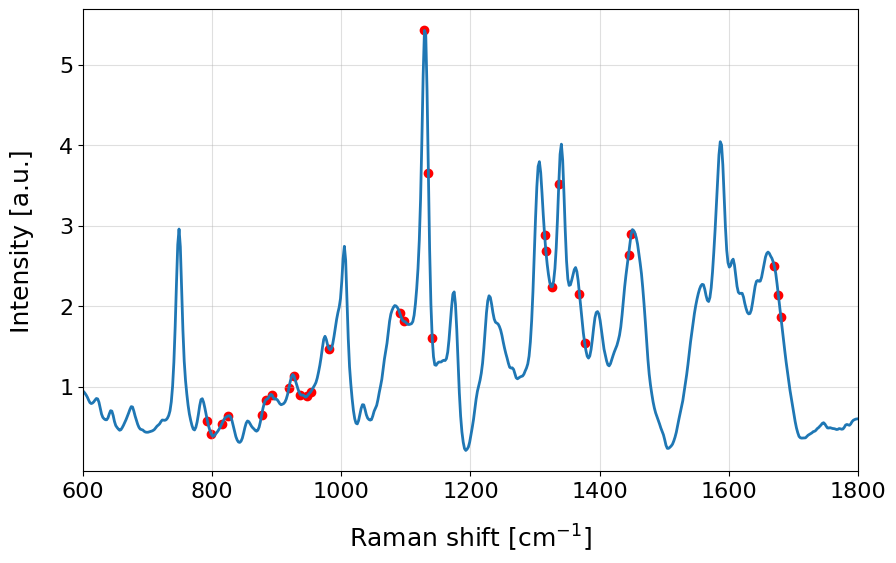

In [ ]:
columns_to_keep = [1134.75, 1132.75, 1314.75, 936.75, 938.75, 940.75, 1316.75, 884.75, 886.75, 1094.75, 1096.75, 818.75, 820.75, 1374.75, 1376.75, 948.75, 950.75, 952.75, 950.75, 1068.75, 796.75,  798.75,  794.75,1440.75, 1444.75, 974.75, 1674.75,1676.75, 1678.75]

columns_to_keep = [792.75, 798.75 , 814.75, 824.75, 876.75, 882.75, 892.75,918.75, 926.75, 936.75,946.75,952.75, 980.75,1090.75,1096.75, 1128.75, 1134.75, 1140.75, 1314.75,1336.75, 1316.75, 1326.75,1368.75, 1376.75, 1444.75, 1448.75,1670.75, 1676.75,1680.75]


filtered_data_reduced2 = filtered_data_reduced[columns_to_keep]

columns=  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date']



fig, ax = plt.subplots(figsize=(10, 6))
alphaVal = 1
linethick=2

plt.plot(reduced_ramanshifts, filtered_data_reduced.mean(axis=0),lw=linethick, alpha=alphaVal)
plt.scatter(pd.DataFrame(columns_to_keep), filtered_data_reduced[columns_to_keep].mean(axis=0), color = 'red', s=25,lw=linethick, alpha=alphaVal)
plt.grid(alpha=0.4)
ax.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=18, labelpad=15)
ax.set_ylabel(r'Intensity [a.u.]', fontsize=18, labelpad=18)
plt.xticks(range(600, 2000, 200), fontsize=16)
plt.xlim([600, 1800])
plt.yticks(range(1, 6, 1), fontsize=16)
plt.savefig('fig19.svg', format='svg', dpi=300)
plt.show()


### Figure 20

Figure 20: Confusion matrix for the unseen data obtained from training a 1-D CNN model with the 28 most significant features trained by grouping K2 and K54 serotypes into a single class, ‘K2-K54’ (a), and only with K2 and K54 serotypes (b). The overall accuracies achieved were 97% and 91%, respectively.

In [ ]:
model = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/featureimportance_3classes_model.h5')
model_bin = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/featureimportance_2classes_model.h5')

5/5 [==============================] - 0s 5ms/step


<ipython-input-64-18dec4dd9c05>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_reduced2[columns] = filtered_data_reduced[columns]
<ipython-input-64-18dec4dd9c05>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_reduced2[columns] = filtered_data_reduced[columns]
<ipython-input-64-18dec4dd9c05>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

test accuracy: 0.966
10/10 [==============================] - 0s 3ms/step
Class 0 - Accuracy: 0.98, Recall: 1.00, Precision: 0.86,Specificity: 0.98, F1-Score: 0.93, AUC: 0.9988
Class 1 - Accuracy: 0.97, Recall: 0.95, Precision: 1.00,Specificity: 1.00, F1-Score: 0.97, AUC: 0.9989
Class 2 - Accuracy: 0.99, Recall: 1.00, Precision: 0.94,Specificity: 0.98, F1-Score: 0.97, AUC: 1.0000
4/4 [==============================] - 0s 5ms/step
test accuracy: 0.907
7/7 [==============================] - 0s 4ms/step
Class 0 - Accuracy: 0.91, Recall: 0.88, Precision: 0.94,Specificity: 0.94, F1-Score: 0.91, AUC: 0.9319
Class 1 - Accuracy: 0.91, Recall: 0.94, Precision: 0.88,Specificity: 0.88, F1-Score: 0.91, AUC: 0.9319


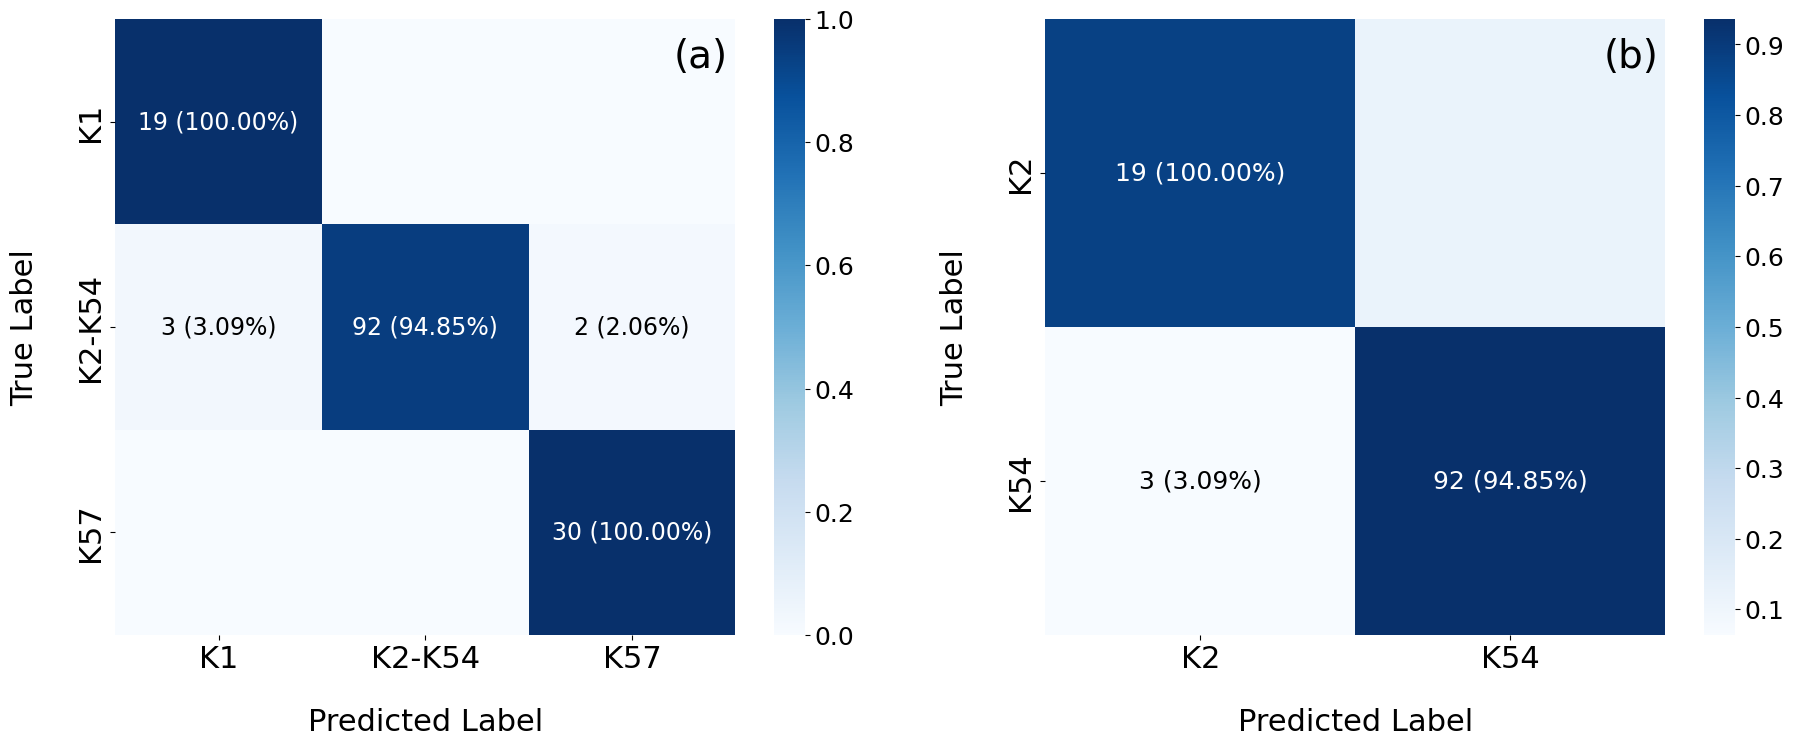

In [ ]:
#columns_to_keep = [1134.75, 1132.75, 1314.75, 936.75, 938.75, 940.75, 1316.75, 884.75, 886.75, 1094.75, 1096.75, 818.75, 820.75, 1374.75, 1376.75, 948.75, 950.75, 952.75, 950.75, 1068.75, 796.75,  798.75,  794.75,1440.75, 1444.75, 974.75, 1674.75,1676.75, 1678.75]

# Creating a subplot with 2 axes
fig20, (ax20a, ax20b) = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))
ax20a.text(0.9, 0.97, '(a)', transform=ax20a.transAxes, fontsize=28, verticalalignment='top')
ax20b.text(0.9, 0.97, '(b)', transform=ax20b.transAxes, fontsize=28, verticalalignment='top')




filtered_data_reduced2 = filtered_data_reduced[columns_to_keep]

columns=  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date']

filtered_data_reduced2[columns] = filtered_data_reduced[columns]


'''fig, ax = plt.subplots(figsize=(10, 6))
alphaVal = 1
linethick=1.5

plt.plot(reduced_ramanshifts, filtered_data_reduced.iloc[:,:-9].mean(axis=0),lw=linethick, alpha=alphaVal)
plt.scatter(pd.DataFrame(columns_to_keep), filtered_data_reduced[columns_to_keep].mean(axis=0), color = 'red', s=17,lw=linethick, alpha=alphaVal)
plt.grid(alpha=0.4)
ax.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=15, labelpad=13)
ax.set_ylabel(r'Intensity [a.u.]', fontsize=15, labelpad=13)
plt.xticks(range(600, 2000, 200), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([600, 1800])
plt.yticks(range(1, 6, 1), fontsize=12)
plt.yticks(fontsize=14)
plt.savefig('fig19.svg', format='svg', dpi=300)
plt.show()
'''


filtered_data = filtered_data_reduced2
ramanshifts = columns_to_keep


feature_steps_list = []
results = []


columns = ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date']

# group k2 - k54 into a new column
filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2-K54' if x == 'K2' else ('K2-K54' if x == 'K54' else x))


# binary data contains only the spectra of k2 - k54
binary_classes = ['K2-K54', 'K54-K2']
binary_data = filtered_data[filtered_data['fenotype_grouped'].isin(binary_classes)]

# i separate spectra from specific isolates measued on different days as "unseens" (ensuring that an adequate n of spectra remain in the train/val dataset for that isolate)
conditions = [
(filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
(filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
#(filtered_data['isolate'] == 'kpC3') & (filtered_data['date'] == '310523')
]

final_condition = conditions[0]
for condition in conditions[1:]:
    final_condition = final_condition | condition


unseens = filtered_data[final_condition]
# train/val dataset
filtered_data2 = filtered_data[~final_condition]


columns_to_drop =  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date', 'fenotype_grouped']



label = 'fenotype_grouped'


# balanceo
all_classes = filtered_data2[label].unique()

minority_class_size = filtered_data2[label].value_counts().min()

balanced_binary_data_trainval = pd.DataFrame()
balanced_trainval_data = pd.DataFrame()


for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]

    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()



X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()


num_classes_grouped = len(all_classes)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_val)
y_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)


calcular = [
            {'que': 'test', 'X': X_test, 'y': y_test}]

class_accuracies = {'test': []}

for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

    #plt.title(f"{calcular[i]['que']} Confusion Matrix")

    sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', ax=ax20a, xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
                ax20a.text(j + 0.5, i + 0.5, text, ha='center', va='center', color=text_color, fontsize=17)

    ax20a.set_xlabel('Predicted Label', fontsize=20, labelpad=20)
    ax20a.set_ylabel('True Label', fontsize=20, labelpad=22)
    plt.xticks( fontsize=15)
    plt.yticks(fontsize=15)
    cbar = sns_heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)





y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)

class_accuracies[calcular[0]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]

y_pred_int_np = np.argmax(y_pred, axis=1)
y_test_int_np = np.argmax(y_test, axis=1)


class_metrics = []

for i in range(num_classes_grouped):
    tp = cm[i, i]  # True Positive
    fn = cm[i, :].sum() - tp  # False Negative
    tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp  # True Negative
    fp = cm[:, i].sum() - tp  # False Positive

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Handle division by zero
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0  # Handle division by zero
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle division by zero
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0  # Handle division by zero

    # Create one-hot encoded y_true_class for the current class
    y_true_class = np.zeros((len(y_test_int_np),))
    y_true_class[y_test_int_np == i] = 1

    # Probability scores for the current class
    y_score_class = y_pred[:, i]

    # Calculate AUC
    auc = roc_auc_score(y_true_class, y_score_class)

    class_metrics.append({
        'Class': i,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1_score,
        'AUC': auc
    })

for metrics in class_metrics:
    print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
          f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f},"
          f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f}, "
          f"AUC: {metrics['AUC']:.4f}")


if 'K2-K54' in binary_data['fenotype_grouped'].values or 'K54-K2' in binary_data['fenotype_grouped'].values:
    all_classes_bin = 2

    conditions = [
    (binary_data['isolate'] == 'kp382') & (binary_data['date'] == 120723),
    (binary_data['isolate'] == 'Kp188') & (binary_data['date'] == 120723),
    ]

    final_condition = conditions[0]
    for condition in conditions[1:]:
        final_condition = final_condition | condition

    binary_data_unseens = binary_data[final_condition]
    binary_data_trainval = binary_data[~final_condition]


    label = 'fenotype'

    all_classes_ = ['K2', 'K54']

    # balanceo
    minority_class_size = binary_data_trainval[label].value_counts().min()
    balanced_binary_data_trainval = pd.DataFrame()
    for class_name in all_classes_:
        class_samples = binary_data[binary_data[label] == class_name]

        if class_samples.shape[0] > minority_class_size:
            reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, reduced_samples])
        else:
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, class_samples])

    balanced_y_trainval = balanced_binary_data_trainval[label]
    balanced_binary_data_trainval = balanced_binary_data_trainval.drop(columns=columns_to_drop).copy()



    X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(balanced_binary_data_trainval, balanced_y_trainval, test_size=0.20, random_state=1000)

    y_test_bin = binary_data_unseens['fenotype']
    X_test_bin = binary_data_unseens.drop(columns=columns_to_drop)


    le = LabelEncoder()
    y_train_encoded_bin = le.fit_transform(y_train_bin)
    y_train_bin = tf.keras.utils.to_categorical(y_train_encoded_bin, num_classes=2)
    y_test_encoded_bin = le.transform(y_test_bin)
    y_test_bin = tf.keras.utils.to_categorical(y_test_encoded_bin, num_classes=2)
    y_val_encoded_bin = le.transform(y_val_bin)
    y_val_bin = tf.keras.utils.to_categorical(y_val_encoded_bin, num_classes=2)



    calcular_bin = [
                    {'que': 'test', 'X': X_test_bin, 'y': y_test_bin}]

    class_accuracies_bin = {'test': []}

    for i in range(len(calcular_bin)):
        y_pred_bin = model_bin.predict(calcular_bin[i]['X'])
        y_pred_int_bin = np.argmax(y_pred_bin, axis=1)
        y_true_int_bin = np.argmax(calcular_bin[i]['y'], axis=1)
        accuracy_bin = accuracy_score(y_true_int_bin, y_pred_int_bin)
        print(f"{calcular_bin[i]['que']} accuracy: {accuracy_bin:1.3f}")

        cm_bin = confusion_matrix(y_true_int_bin, y_pred_int_bin, labels=np.arange(all_classes_bin))
        cm_normalized_bin = cm_bin.astype('float') / cm_bin.sum(axis=1, keepdims=True)

        sns_heatmap = sns.heatmap(cm_normalized_bin, annot=False, fmt='.2%', cmap='Blues', ax= ax20b, xticklabels=le.inverse_transform(np.arange(all_classes_bin)), yticklabels=le.inverse_transform(np.arange(all_classes_bin)))

        for i in range(cm_bin.shape[0]):
            for j in range(cm_bin.shape[1]):
                value = cm[i, j]
                if value != 0 and not np.isnan(cm_normalized[i, j]):
                    text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                    text_color = "white" if cm_normalized_bin[i, j] > 0.5 else "black"
                    ax20b.text(j + 0.5, i + 0.5, text, ha='center', va='center', color=text_color, fontsize=18)
        ax20b.set_xlabel('Predicted Label', fontsize=20, labelpad=20)
        ax20b.set_ylabel('True Label', fontsize=20, labelpad=22)
        plt.xticks( fontsize=15)
        plt.yticks(fontsize=15)
        cbar = sns_heatmap.collections[0].colorbar
        cbar.ax.tick_params(labelsize=18)


        class_accuracies_bin[calcular_bin[0]['que']] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]

        y_pred_bin = model_bin.predict(X_test_bin)
        y_pred_int_bin = tf.argmax(y_pred_bin, axis=1)
        y_test_int_bin = tf.argmax(y_test_bin, axis=1)
        accuracy_test_bin = accuracy_score(y_test_int_bin, y_pred_int_bin)

        y_pred_train_bin = model_bin.predict(X_train_bin)
        y_pred_val_bin = model_bin.predict(X_val_bin)

        y_pred_train_int_bin = tf.argmax(y_pred_train_bin, axis=1)
        y_train_int_bin = tf.argmax(y_train_bin, axis=1)
        accuracy_train_bin = accuracy_score(y_train_int_bin, y_pred_train_int_bin)

        y_pred_val_int_bin = tf.argmax(y_pred_val_bin, axis=1)
        y_val_int_bin = tf.argmax(y_val_bin, axis=1)
        accuracy_val_bin = accuracy_score(y_val_int_bin, y_pred_val_int_bin)

        class_accuracies_bin['test'] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]


        y_pred_int_bin_np = np.argmax(y_pred_bin, axis=1)
        y_test_int_bin_np = np.argmax(y_test_bin, axis=1)

        cm = cm_bin
        class_metrics = []

        for i in range(all_classes_bin):
            tp = cm[i, i]  # True Positive
            fn = cm[i, :].sum() - tp  # False Negative
            tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp  # True Negative
            fp = cm[:, i].sum() - tp  # False Positive

            accuracy = (tp + tn) / (tp + tn + fp + fn)
            precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Handle division by zero
            recall = tp / (tp + fn) if (tp + fn) != 0 else 0  # Handle division by zero
            specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle division by zero
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0  # Handle division by zero

            # Create one-hot encoded y_true_class for the current class
            y_true_class = np.zeros((len(y_test_int_bin_np),))
            y_true_class[y_test_int_bin_np == i] = 1

            # Probability scores for the current class
            y_score_class = y_pred_bin[:, i]

            auc = roc_auc_score(y_true_class, y_score_class)

            class_metrics.append({
                'Class': i,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'Specificity': specificity,
                'F1-Score': f1_score,
                'AUC': auc
            })

        for metrics in class_metrics:
            print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
                  f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f},"
                  f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f}, "
                  f"AUC: {metrics['AUC']:.4f}")

for ax in [ax20a, ax20b]:
    ax.tick_params(axis='both', labelsize=22)
    ax.set_xlabel('Predicted Label', fontsize=22, labelpad=24)
    ax.set_ylabel('True Label', fontsize=22, labelpad=27)
fig20.savefig('fig20.svg', format='svg', dpi=300)
plt.show()


In [ ]:
model = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/featureimportance_3classes_model.h5')
model_bin = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/featureimportance_2classes_model.h5')

y-randomization

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 29, 64)            576       
                                                                 
 activation_21 (Activation)  (None, 29, 64)            0         
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 14, 64)            0         


<ipython-input-86-d8d045d6d65b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2-K54' if x == 'K2' else ('K2-K54' if x == 'K54' else x))


 g1D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 14, 64)            0         
                                                                 
 flatten_7 (Flatten)         (None, 896)               0         
                                                                 
 dense_20 (Dense)            (None, 128)               114816    
                                                                 
 activation_22 (Activation)  (None, 128)               0         
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 3)                 387       
                                                                 
 activation_23 (Activation)  (None, 3)                 0         
          

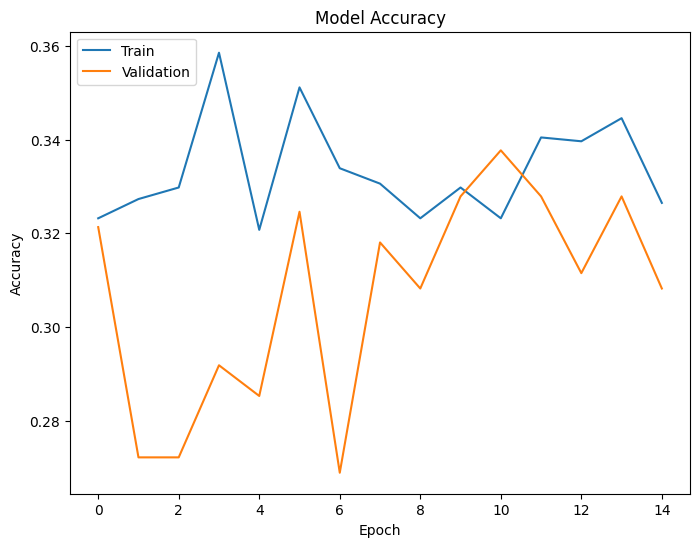

38/38 [==============================] - 1s 7ms/step
train accuracy: 0.363


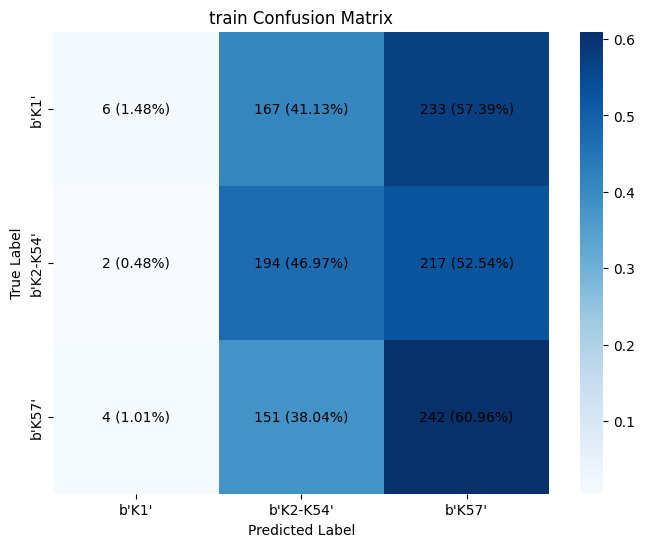

10/10 [==============================] - 0s 4ms/step
val accuracy: 0.308


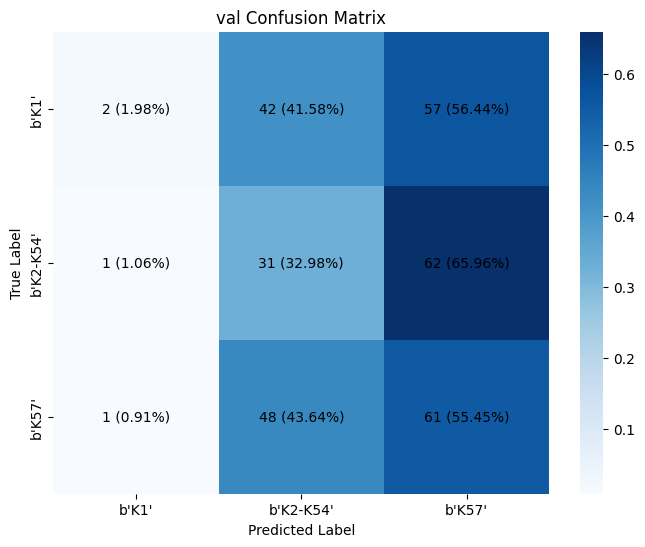

5/5 [==============================] - 0s 5ms/step
test accuracy: 0.384


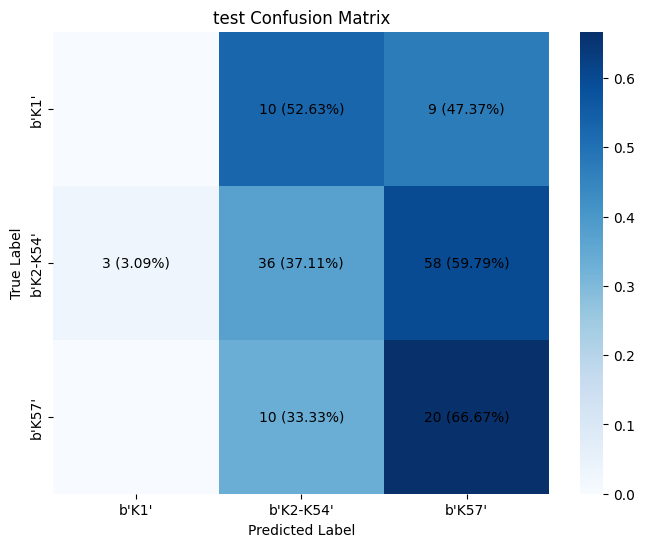

10/10 [==============================] - 0s 4ms/step
Epoch 1/15
28/28 - 3s - loss: 0.7328 - accuracy: 0.5067 - val_loss: 0.6983 - val_accuracy: 0.5223 - 3s/epoch - 103ms/step
Epoch 2/15
28/28 - 0s - loss: 0.7121 - accuracy: 0.5279 - val_loss: 0.6928 - val_accuracy: 0.5045 - 289ms/epoch - 10ms/step
Epoch 3/15
28/28 - 0s - loss: 0.7269 - accuracy: 0.4821 - val_loss: 0.7004 - val_accuracy: 0.5089 - 326ms/epoch - 12ms/step
Epoch 4/15
28/28 - 0s - loss: 0.7312 - accuracy: 0.4754 - val_loss: 0.6923 - val_accuracy: 0.5268 - 354ms/epoch - 13ms/step
Epoch 5/15
28/28 - 0s - loss: 0.7380 - accuracy: 0.4721 - val_loss: 0.6946 - val_accuracy: 0.5268 - 350ms/epoch - 12ms/step
Epoch 6/15
28/28 - 0s - loss: 0.7133 - accuracy: 0.5156 - val_loss: 0.6942 - val_accuracy: 0.5134 - 295ms/epoch - 11ms/step
Epoch 7/15
28/28 - 0s - loss: 0.7034 - accuracy: 0.5067 - val_loss: 0.6929 - val_accuracy: 0.5223 - 312ms/epoch - 11ms/step
Epoch 8/15
28/28 - 0s - loss: 0.7149 - accuracy: 0.4989 - val_loss: 0.6921 - val_

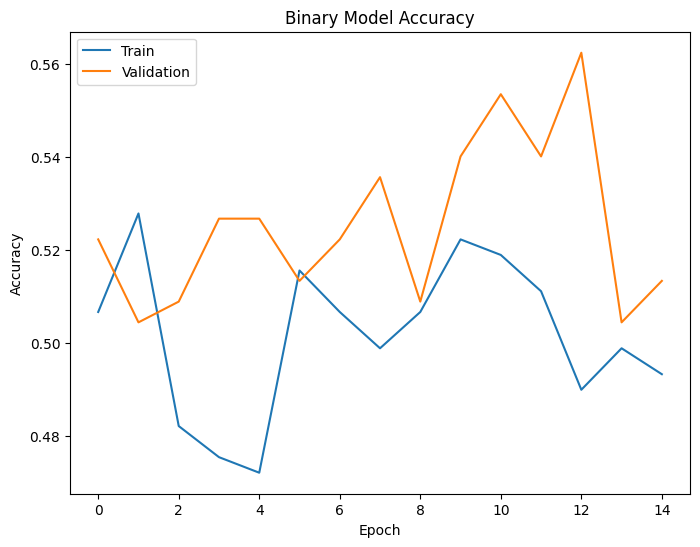

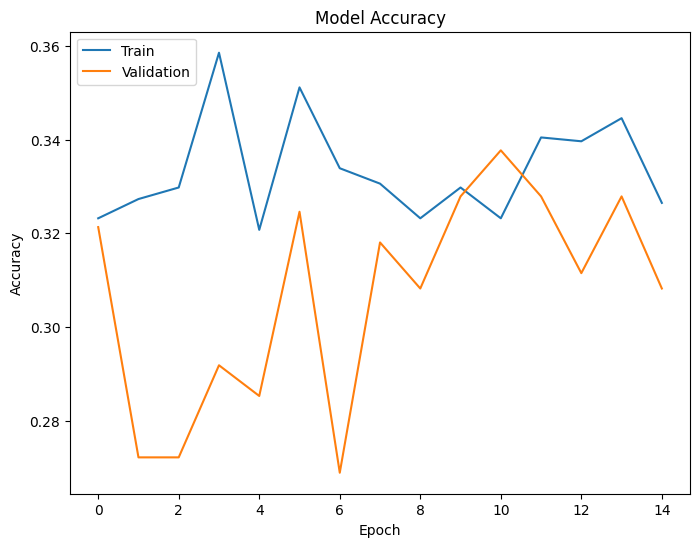

28/28 [==============================] - 0s 4ms/step
train accuracy: 0.504


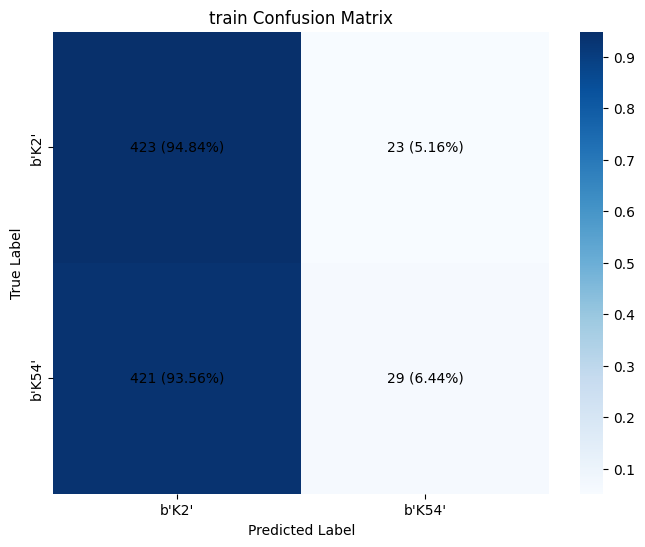

7/7 [==============================] - 0s 5ms/step
val accuracy: 0.513


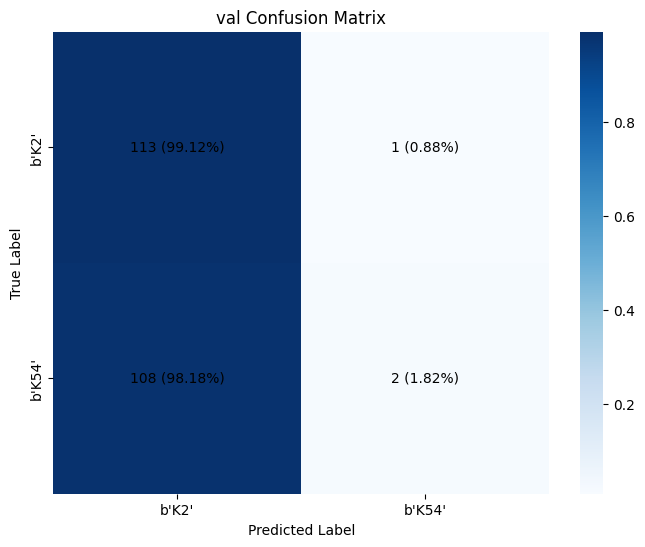

4/4 [==============================] - 0s 10ms/step
test accuracy: 0.536


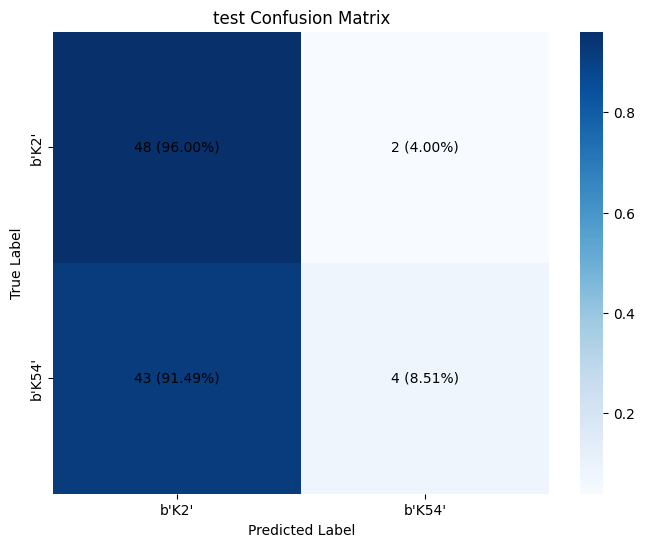

7/7 [==============================] - 0s 5ms/step


In [ ]:
filtered_data = filtered_data_reduced2
ramanshifts = columns_to_keep


feature_steps_list = []
results = []


columns = ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date']

# group k2 - k54 into a new column
filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2-K54' if x == 'K2' else ('K2-K54' if x == 'K54' else x))


# binary data contains only the spectra of k2 - k54
binary_classes = ['K2-K54', 'K54-K2']
binary_data = filtered_data[filtered_data['fenotype_grouped'].isin(binary_classes)]

# i separate spectra from specific isolates measued on different days as "unseens" (ensuring that an adequate n of spectra remain in the train/val dataset for that isolate)
conditions = [
(filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
(filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
#(filtered_data['isolate'] == 'kpC3') & (filtered_data['date'] == '310523')
]

final_condition = conditions[0]
for condition in conditions[1:]:
    final_condition = final_condition | condition


unseens = filtered_data[final_condition]
# train/val dataset
filtered_data2 = filtered_data[~final_condition]


columns_to_drop =  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date', 'fenotype_grouped']



label = 'fenotype_grouped'


# balanceo
all_classes = filtered_data2[label].unique()

minority_class_size = filtered_data2[label].value_counts().min()

balanced_binary_data_trainval = pd.DataFrame()
balanced_trainval_data = pd.DataFrame()


for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]

    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()



X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()




y_perm_train=tf.random.shuffle(y_train,seed=1000)
y_perm_val=tf.random.shuffle(y_val,seed=1000)
y_perm_test=tf.random.shuffle(y_test,seed=1000)


num_classes_grouped = len(all_classes)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_perm_train)
y_perm_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_perm_test)
y_perm_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_perm_val)
y_perm_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train.columns), 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes_grouped))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train.to_numpy(), y_perm_train, batch_size=32, epochs=15, verbose=2, validation_data=(X_val.to_numpy(), y_perm_val))

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

calcular = [{'que': 'train', 'X': X_train, 'y': y_perm_train},
            {'que': 'val', 'X': X_val, 'y': y_perm_val},
            {'que': 'test', 'X': X_test, 'y': y_perm_test}]

class_accuracies = {'train': [], 'val': [], 'test': []}

for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

    plt.figure(figsize=(8, 6))
    plt.title(f"{calcular[i]['que']} Confusion Matrix")
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_perm_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_perm_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_perm_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)

class_accuracies[calcular[2]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]




if 'K2-K54' in binary_data['fenotype_grouped'].values or 'K54-K2' in binary_data['fenotype_grouped'].values:
    all_classes_bin = 2

    conditions = [
    (binary_data['isolate'] == 'kp382') & (binary_data['date'] == 120723),
    (binary_data['isolate'] == 'Kp188') & (binary_data['date'] == 120723),
    ]

    final_condition = conditions[0]
    for condition in conditions[1:]:
        final_condition = final_condition | condition

    binary_data_unseens = binary_data[final_condition]
    binary_data_trainval = binary_data[~final_condition]


    label = 'fenotype'

    all_classes_ = ['K2', 'K54']

    # balanceo
    minority_class_size = binary_data_trainval[label].value_counts().min()
    balanced_binary_data_trainval = pd.DataFrame()
    for class_name in all_classes_:
        class_samples = binary_data[binary_data[label] == class_name]

        if class_samples.shape[0] > minority_class_size:
            reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, reduced_samples])
        else:
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, class_samples])

    balanced_y_trainval = balanced_binary_data_trainval[label]
    balanced_binary_data_trainval = balanced_binary_data_trainval.drop(columns=columns_to_drop).copy()



    X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(balanced_binary_data_trainval, balanced_y_trainval, test_size=0.20, random_state=1000)

    y_test_bin = binary_data_unseens['fenotype']
    X_test_bin = binary_data_unseens.drop(columns=columns_to_drop)


    y_train_bin=tf.random.shuffle(y_train_bin,seed=1000)
    y_val_bin=tf.random.shuffle(y_val_bin,seed=1000)
    y_test_bin=tf.random.shuffle(y_test_bin,seed=1000)


    le = LabelEncoder()
    y_train_encoded_bin = le.fit_transform(y_train_bin)
    y_train_bin = tf.keras.utils.to_categorical(y_train_encoded_bin, num_classes=2)
    y_test_encoded_bin = le.transform(y_test_bin)
    y_test_bin = tf.keras.utils.to_categorical(y_test_encoded_bin, num_classes=2)
    y_val_encoded_bin = le.transform(y_val_bin)
    y_val_bin = tf.keras.utils.to_categorical(y_val_encoded_bin, num_classes=2)

    binary_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    model_bin = tf.keras.models.Sequential(model.layers[:-1])  # Remove the last layer with 3 units
    model_bin.add(tf.keras.layers.Dense(2, activation='softmax'))  # Add new last layer with 2 units
    model_bin.compile(loss='categorical_crossentropy', optimizer=binary_optimizer, metrics=['accuracy'])

    binary_history = model_bin.fit(X_train_bin.to_numpy(), y_train_bin, batch_size=32, epochs=15, verbose=2, validation_data=(X_val_bin.to_numpy(), y_val_bin))

    plt.figure(figsize=(8, 6))
    plt.plot(binary_history.history['accuracy'])
    plt.plot(binary_history.history['val_accuracy'])
    plt.title('Binary Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    calcular_bin = [{'que': 'train', 'X': X_train_bin, 'y': y_train_bin},
                    {'que': 'val', 'X': X_val_bin, 'y': y_val_bin},
                    {'que': 'test', 'X': X_test_bin, 'y': y_test_bin}]

    class_accuracies_bin = {'train': [], 'val': [], 'test': []}

    for i in range(len(calcular_bin)):
        y_pred_bin = model_bin.predict(calcular_bin[i]['X'])
        y_pred_int_bin = np.argmax(y_pred_bin, axis=1)
        y_true_int_bin = np.argmax(calcular_bin[i]['y'], axis=1)
        accuracy_bin = accuracy_score(y_true_int_bin, y_pred_int_bin)
        print(f"{calcular_bin[i]['que']} accuracy: {accuracy_bin:1.3f}")

        cm_bin = confusion_matrix(y_true_int_bin, y_pred_int_bin, labels=np.arange(all_classes_bin))
        cm_normalized_bin = cm_bin.astype('float') / cm_bin.sum(axis=1, keepdims=True)

        plt.figure(figsize=(8, 6))
        plt.title(f"{calcular_bin[i]['que']} Confusion Matrix")
        sns.heatmap(cm_normalized_bin, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(all_classes_bin)), yticklabels=le.inverse_transform(np.arange(all_classes_bin)))

        for i in range(cm_bin.shape[0]):
            for j in range(cm_bin.shape[1]):
                value = cm_bin[i, j]
                if value != 0 and not np.isnan(cm_normalized_bin[i, j]):
                    text = f"{value} ({cm_normalized_bin[i, j] * 100:.2f}%)"
                    plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    class_accuracies_bin[calcular_bin[2]['que']] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]

    y_pred_bin = model_bin.predict(X_test_bin)
    y_pred_int_bin = tf.argmax(y_pred_bin, axis=1)
    y_test_int_bin = tf.argmax(y_test_bin, axis=1)
    accuracy_test_bin = accuracy_score(y_test_int_bin, y_pred_int_bin)

    y_pred_train_bin = model_bin.predict(X_train_bin)
    y_pred_val_bin = model_bin.predict(X_val_bin)

    y_pred_train_int_bin = tf.argmax(y_pred_train_bin, axis=1)
    y_train_int_bin = tf.argmax(y_train_bin, axis=1)
    accuracy_train_bin = accuracy_score(y_train_int_bin, y_pred_train_int_bin)

    y_pred_val_int_bin = tf.argmax(y_pred_val_bin, axis=1)
    y_val_int_bin = tf.argmax(y_val_bin, axis=1)
    accuracy_val_bin = accuracy_score(y_val_int_bin, y_pred_val_int_bin)

    class_accuracies_bin['test'] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]



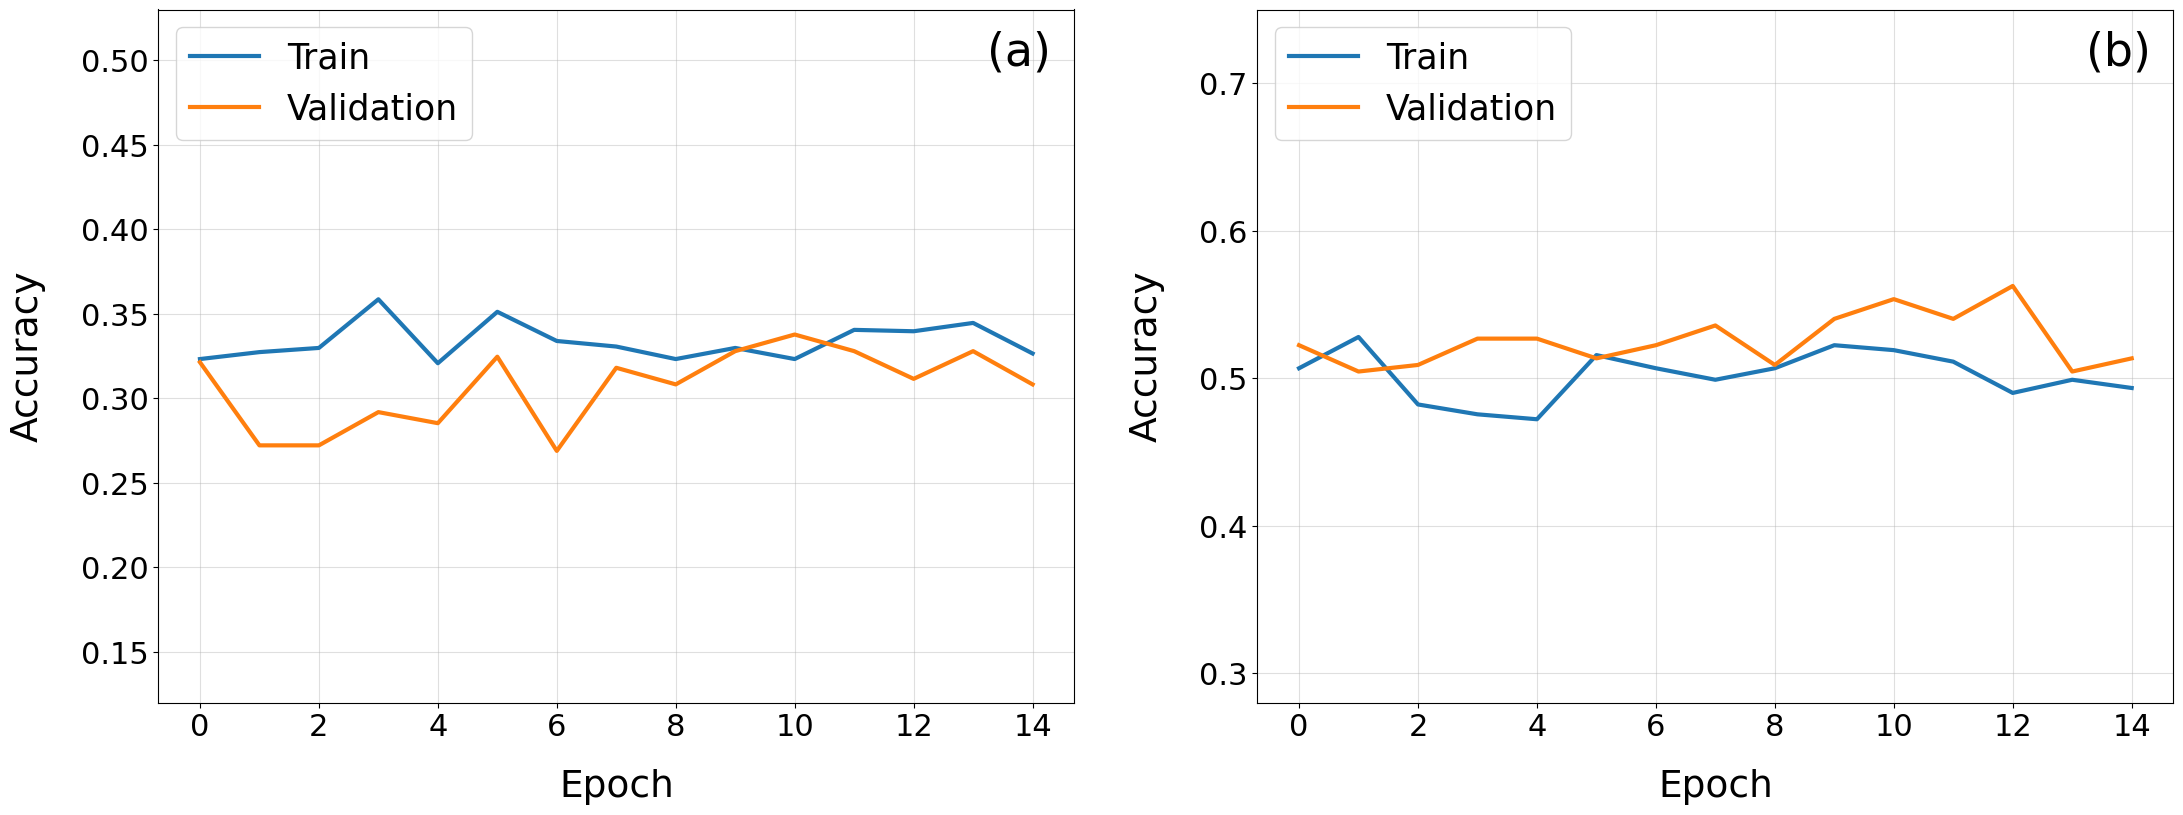

In [ ]:
fig21, (ax21a,ax21b) = plt.subplots(nrows=1, ncols=2, figsize=(26, 9))

alphaVal = 1
linethick = 3

# Plotting in ax14a
ax21a.set_ylim([0.12, 0.53])
ax21a.plot(history.history['accuracy'], lw=linethick, alpha=alphaVal)
ax21a.plot(history.history['val_accuracy'], lw=linethick, alpha=alphaVal)
ax21a.grid(alpha=0.4)
ax21a.set_ylabel('Accuracy', fontsize=27, labelpad=25)
ax21a.set_xlabel('Epoch', fontsize=27, labelpad=20)
ax21a.legend(['Train', 'Validation'], loc='upper left', prop={'size': 25})
ax21a.tick_params(axis='both', which='major', labelsize=22)
ax21a.text(0.905, 0.97, '(a)', transform=ax21a.transAxes, fontsize=33, verticalalignment='top')

# Plotting in ax14b
ax21b.set_ylim([0.28, 0.75])
ax21b.plot(binary_history.history['accuracy'], lw=linethick, alpha=alphaVal)
ax21b.plot(binary_history.history['val_accuracy'], lw=linethick, alpha=alphaVal)
ax21b.grid(alpha=0.4)
ax21b.set_ylabel('Accuracy', fontsize=27, labelpad=25)
ax21b.set_xlabel('Epoch', fontsize=27, labelpad=20)
ax21b.legend(['Train', 'Validation'], loc='upper left', prop={'size': 25})
ax21b.tick_params(axis='both', which='major', labelsize=22)
ax21b.text(0.905, 0.97, '(b)', transform=ax21b.transAxes, fontsize=33, verticalalignment='top')

# Save the combined figure
fig21.savefig('fig21.svg', format='svg', dpi=300)
plt.show()


### Figure 21

Figure 21: Y-randomization model training process for a 1-D CNN trained with 28 features, grouping K2 and K54 serotypes into a single class (a) and training only with K2 and K54 serotypes (b).

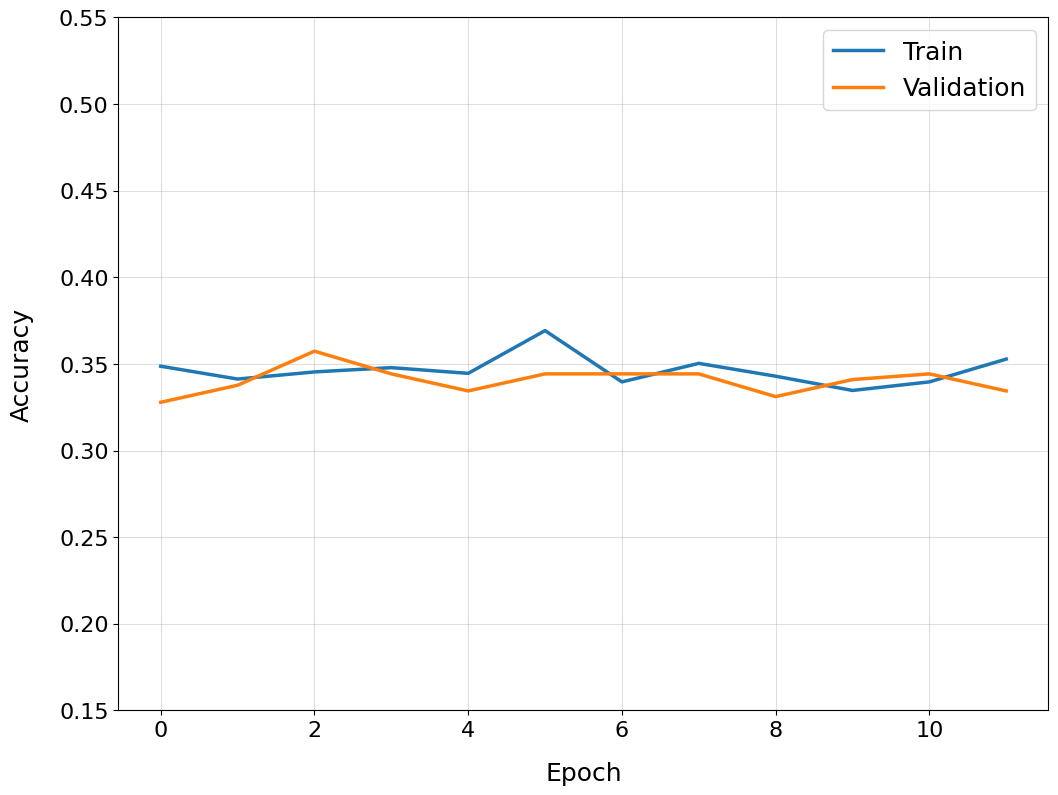

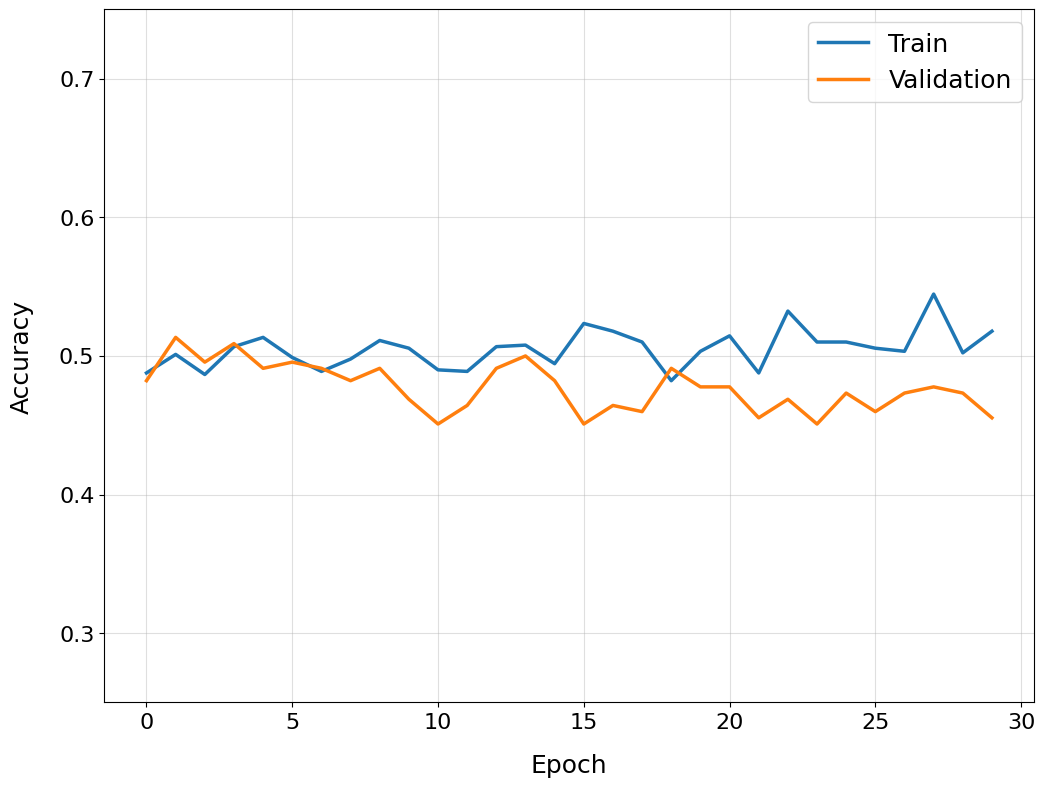

In [ ]:
alphaVal = 1
linethick=2.5

fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(history.history['accuracy'], lw=linethick, alpha=alphaVal)
ax.plot(history.history['val_accuracy'], lw=linethick, alpha=alphaVal)
#ax.set_title('Model Accuracy')
plt.grid(alpha=0.4)
ax.set_ylabel('Accuracy', fontsize=27, labelpad=18)
ax.set_xlabel('Epoch', fontsize=27, labelpad=15)
ax.set_ylim([0.15, 0.55])
plt.legend(['Train', 'Validation'], loc='upper right', prop={'size': 18})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('fig21a.svg', format='svg', dpi=300)
plt.show()


fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(binary_history.history['accuracy'], lw=linethick, alpha=alphaVal)
ax.plot(binary_history.history['val_accuracy'], lw=linethick, alpha=alphaVal)
#ax.set_title('Model Accuracy')
plt.grid(alpha=0.4)
ax.set_ylabel('Accuracy', fontsize=27, labelpad=25)
ax.set_xlabel('Epoch', fontsize=27, labelpad=20)
ax.set_ylim([0.25, 0.75])
plt.legend(['Train', 'Validation'], loc='upper right', prop={'size': 18})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('fig21b.svg', format='svg', dpi=300)
plt.show()



Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 29, 64)            576       
                                                                 
 activation_72 (Activation)  (None, 29, 64)            0         
                                                                 
 max_pooling1d_24 (MaxPooli  (None, 14, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_24 (Flatten)        (None, 896)               0         
                                                                 
 dense_59 (Dense)            (None, 128)               114816    
                                                                 
 activation_73 (Activation)  (None, 128)               0         
                                                     

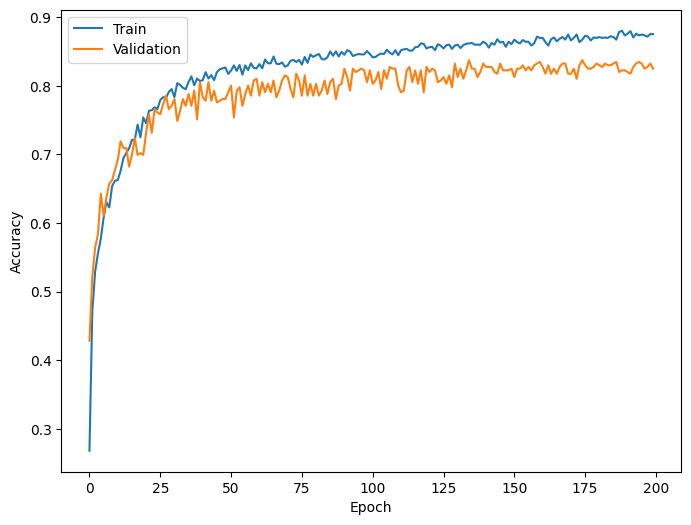

51/51 [==============================] - 1s 11ms/step
train accuracy: 0.878


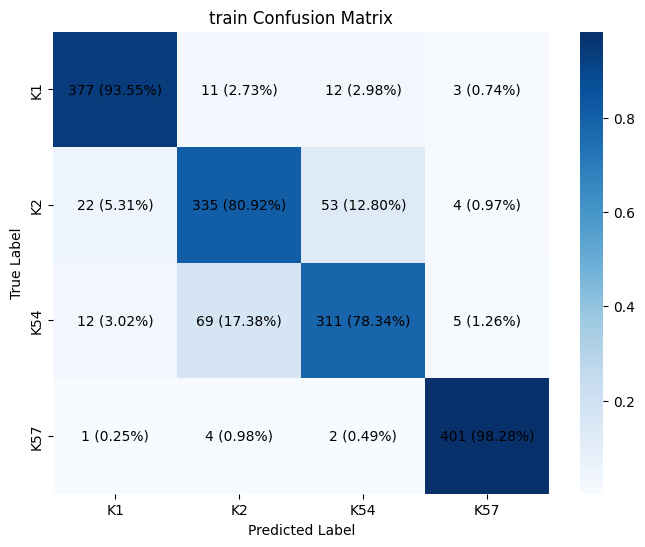

13/13 [==============================] - 0s 11ms/step
val accuracy: 0.825


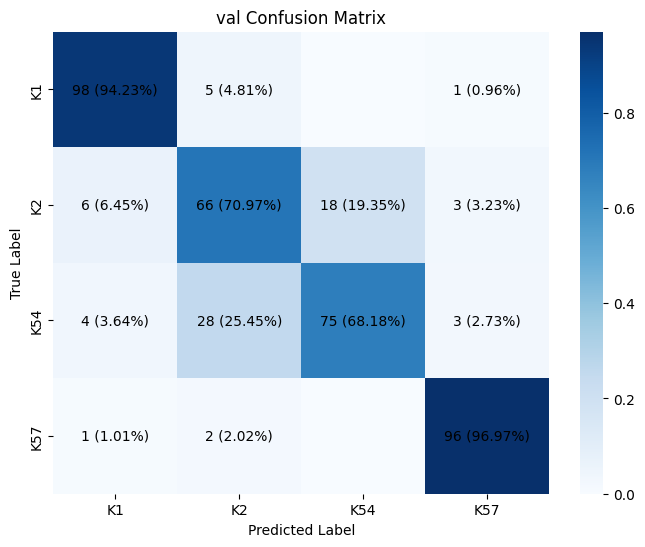

5/5 [==============================] - 0s 8ms/step
test accuracy: 0.908


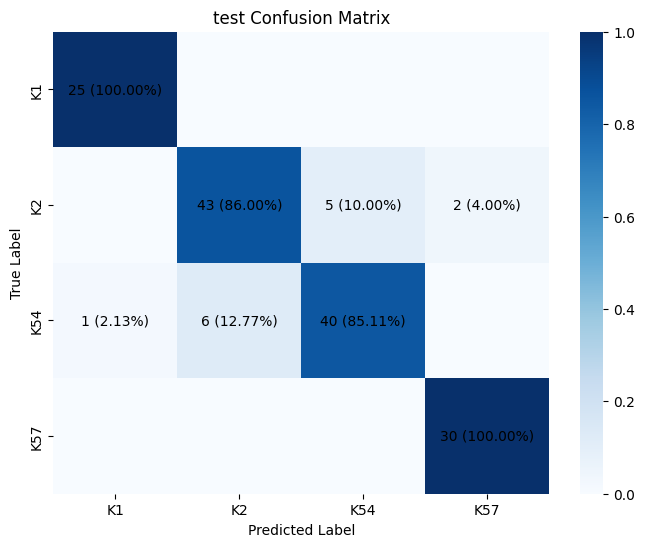

13/13 [==============================] - 0s 8ms/step


In [ ]:
label = 'fenotype'

columns_to_drop =  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date', 'fenotype_grouped']

filtered_data = filtered_data_reduced2
ramanshifts = columns_to_keep


conditions = [
(filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
(filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
(filtered_data['isolate'] == 'KpC3') & (filtered_data['date'] == 310523),
(filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723)
]


final_condition = conditions[0]
for condition in conditions[1:]:
    final_condition = final_condition | condition

unseens = filtered_data[final_condition]
filtered_data2 = filtered_data[~final_condition]


# balanceo
all_classes = filtered_data2[label].unique()

minority_class_size = filtered_data2[label].value_counts().min()

balanced_trainval_data = pd.DataFrame()


for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]

    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()



X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()


num_classes_grouped = len(all_classes)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_val)
y_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train.columns), 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))
#model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('relu'))
#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes_grouped))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'], run_eagerly=True)
history = model.fit(X_train.to_numpy(), y_train, batch_size=32, epochs=200, verbose=2, validation_data=(X_val.to_numpy(), y_val))

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

calcular = [{'que': 'train', 'X': X_train, 'y': y_train},
            {'que': 'val', 'X': X_val, 'y': y_val},
            {'que': 'test', 'X': X_test, 'y': y_test}]

class_accuracies = {'train': [], 'val': [], 'test': []}

for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

    plt.figure(figsize=(8, 6))
    plt.title(f"{calcular[i]['que']} Confusion Matrix")
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()




y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)

class_accuracies[calcular[2]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]



## 28 random features

In [ ]:
import random

inicio_rango = 600.75
fin_rango = 800.75
cantidad_valores = 28
random_values = [round(random.uniform(inicio_rango, fin_rango) // 2 * 2 + 0.75, 2) for _ in range(cantidad_valores)]
print(random_values)


[762.75, 684.75, 788.75, 640.75, 726.75, 766.75, 670.75, 762.75, 788.75, 786.75, 712.75, 666.75, 778.75, 756.75, 758.75, 736.75, 624.75, 734.75, 728.75, 600.75, 718.75, 720.75, 778.75, 642.75, 690.75, 616.75, 654.75, 708.75]


In [ ]:
filtered_data_reduced2 = filtered_data_reduced[random_values]

filtered_data_reduced2[columns_to_drop] = filtered_data_reduced[columns_to_drop]

<ipython-input-201-5a3726ee6ab8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_reduced2[columns] = filtered_data_reduced[columns]
<ipython-input-201-5a3726ee6ab8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_reduced2[columns] = filtered_data_reduced[columns]
<ipython-input-201-5a3726ee6ab8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 28, 64)            576       
                                                                 
 activation_90 (Activation)  (None, 28, 64)            0         
                                                                 
 max_pooling1d_30 (MaxPooli  (None, 14, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_60 (Dropout)        (None, 14, 64)            0         
                                                                 
 flatten_30 (Flatten)        (None, 896)               0         
                                                                 
 dense_78 (Dense)            (None, 128)               114816    
                                                     

<ipython-input-202-6dd5e89aa461>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2_K54' if x == 'K2' else ('K2_K54' if x == 'K54' else x))


Epoch 1/50
38/38 - 1s - loss: 1.0927 - accuracy: 0.3561 - val_loss: 1.0823 - val_accuracy: 0.3836 - 1s/epoch - 30ms/step
Epoch 2/50
38/38 - 0s - loss: 1.0771 - accuracy: 0.3947 - val_loss: 1.0663 - val_accuracy: 0.4918 - 204ms/epoch - 5ms/step
Epoch 3/50
38/38 - 0s - loss: 1.0587 - accuracy: 0.4630 - val_loss: 1.0502 - val_accuracy: 0.5311 - 197ms/epoch - 5ms/step
Epoch 4/50
38/38 - 0s - loss: 1.0495 - accuracy: 0.4942 - val_loss: 1.0333 - val_accuracy: 0.5705 - 208ms/epoch - 5ms/step
Epoch 5/50
38/38 - 0s - loss: 1.0330 - accuracy: 0.5230 - val_loss: 1.0152 - val_accuracy: 0.6033 - 195ms/epoch - 5ms/step
Epoch 6/50
38/38 - 0s - loss: 1.0167 - accuracy: 0.5469 - val_loss: 0.9951 - val_accuracy: 0.6098 - 192ms/epoch - 5ms/step
Epoch 7/50
38/38 - 0s - loss: 1.0056 - accuracy: 0.5485 - val_loss: 0.9752 - val_accuracy: 0.6164 - 334ms/epoch - 9ms/step
Epoch 8/50
38/38 - 0s - loss: 0.9806 - accuracy: 0.6077 - val_loss: 0.9551 - val_accuracy: 0.6164 - 395ms/epoch - 10ms/step
Epoch 9/50
38/38 

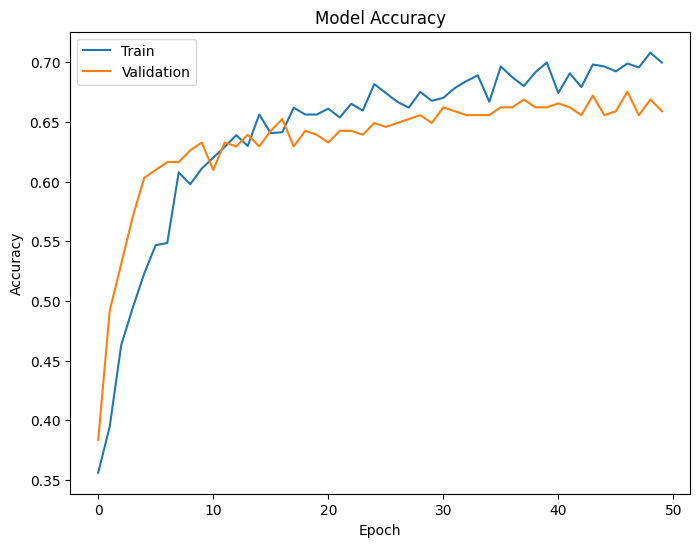

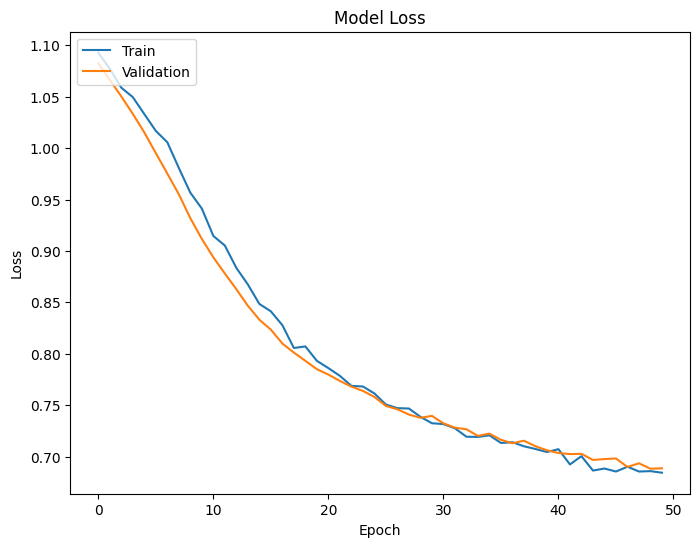

38/38 [==============================] - 0s 2ms/step
train accuracy: 0.718


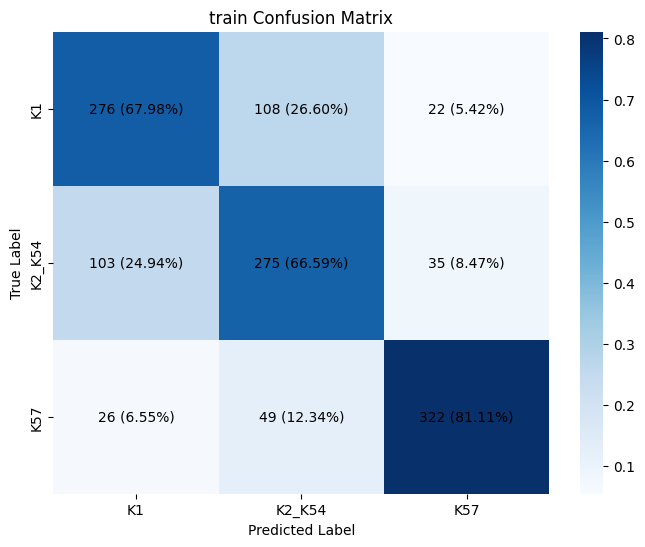

10/10 [==============================] - 0s 2ms/step
val accuracy: 0.659


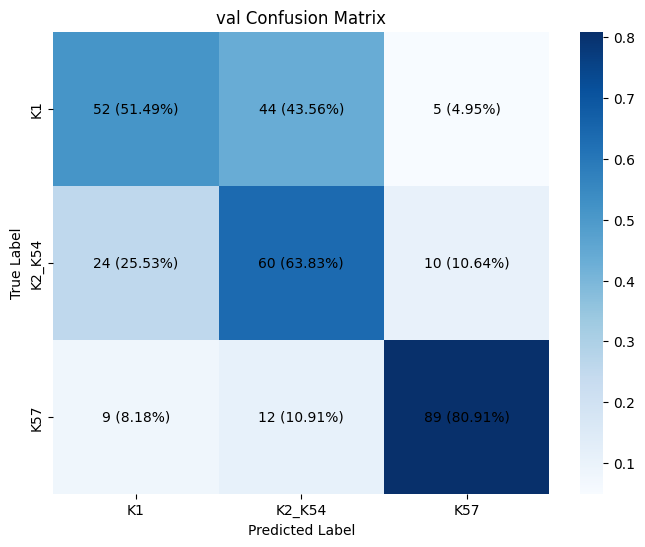

5/5 [==============================] - 0s 3ms/step
test accuracy: 0.541


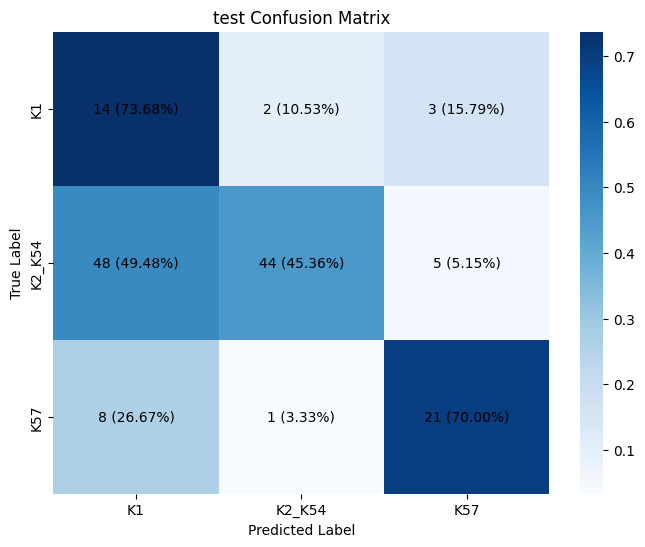

10/10 [==============================] - 0s 2ms/step
Class 0 - Accuracy: 0.58, Recall: 0.74, Precision: 0.20,Specificity: 0.56, F1-Score: 0.31, AUC: 0.6432
Class 1 - Accuracy: 0.62, Recall: 0.45, Precision: 0.94,Specificity: 0.94, F1-Score: 0.61, AUC: 0.8698
Class 2 - Accuracy: 0.88, Recall: 0.70, Precision: 0.72,Specificity: 0.93, F1-Score: 0.71, AUC: 0.9397
Epoch 1/50
28/28 - 1s - loss: 0.7468 - accuracy: 0.5279 - val_loss: 0.7000 - val_accuracy: 0.5893 - 1s/epoch - 43ms/step
Epoch 2/50
28/28 - 0s - loss: 0.7293 - accuracy: 0.5324 - val_loss: 0.6896 - val_accuracy: 0.5714 - 176ms/epoch - 6ms/step
Epoch 3/50
28/28 - 0s - loss: 0.7345 - accuracy: 0.5179 - val_loss: 0.6852 - val_accuracy: 0.5848 - 154ms/epoch - 6ms/step
Epoch 4/50
28/28 - 0s - loss: 0.7068 - accuracy: 0.5424 - val_loss: 0.6814 - val_accuracy: 0.6027 - 160ms/epoch - 6ms/step
Epoch 5/50
28/28 - 0s - loss: 0.7023 - accuracy: 0.5547 - val_loss: 0.6759 - val_accuracy: 0.5804 - 155ms/epoch - 6ms/step
Epoch 6/50
28/28 - 0s - l

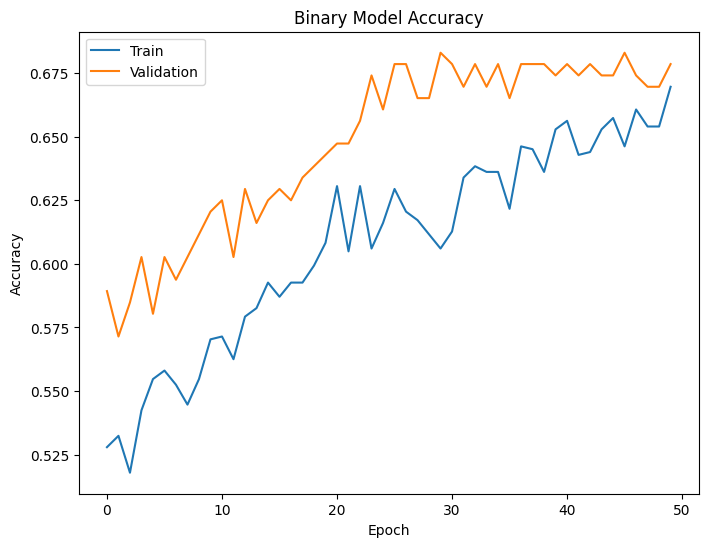

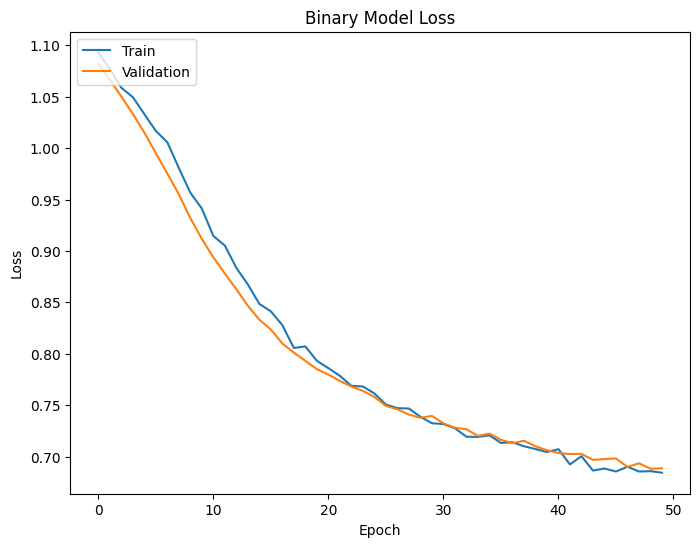

28/28 [==============================] - 0s 3ms/step
train accuracy: 0.662


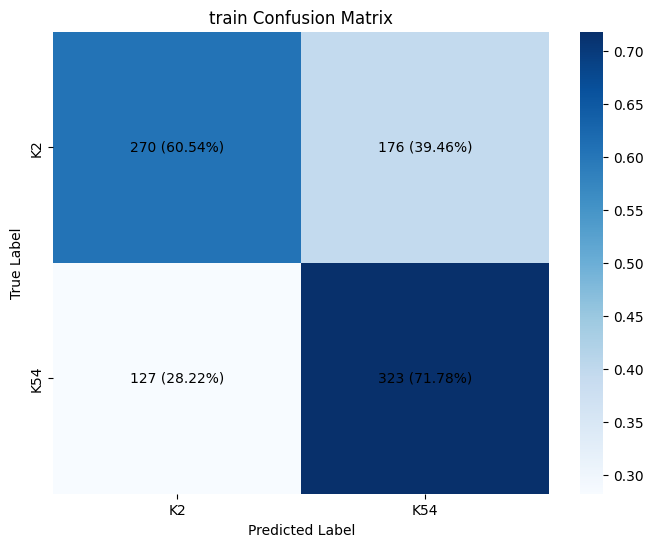

7/7 [==============================] - 0s 3ms/step
Class 0 - Accuracy: 0.66, Recall: 0.61, Precision: 0.68,Specificity: 0.72, F1-Score: 0.64, AUC: 0.7094
Class 1 - Accuracy: 0.66, Recall: 0.72, Precision: 0.65,Specificity: 0.61, F1-Score: 0.68, AUC: 0.7094
7/7 [==============================] - 0s 4ms/step
val accuracy: 0.679


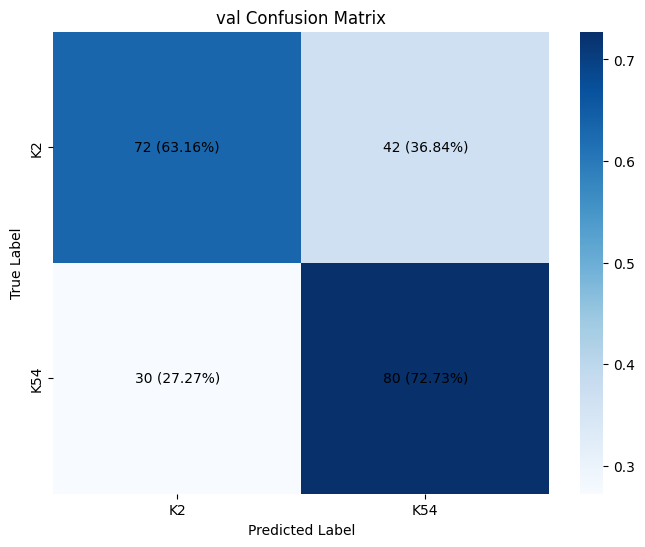

7/7 [==============================] - 0s 4ms/step
Class 0 - Accuracy: 0.68, Recall: 0.63, Precision: 0.71,Specificity: 0.73, F1-Score: 0.67, AUC: 0.7094
Class 1 - Accuracy: 0.68, Recall: 0.73, Precision: 0.66,Specificity: 0.63, F1-Score: 0.69, AUC: 0.7094
4/4 [==============================] - 0s 6ms/step
test accuracy: 0.608


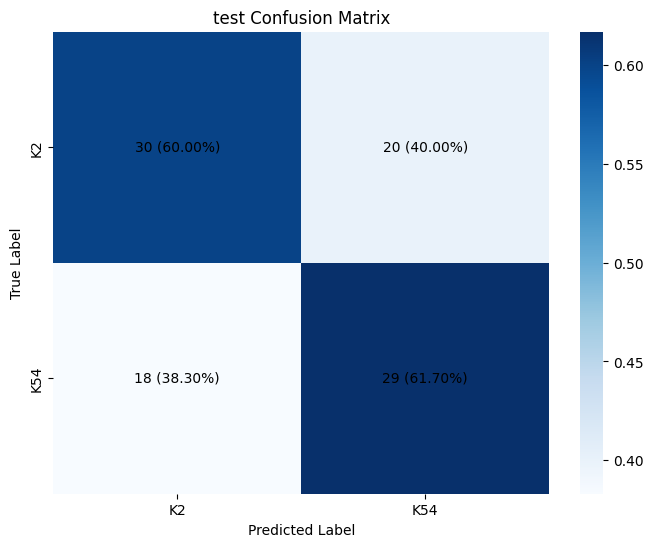

7/7 [==============================] - 0s 3ms/step
Class 0 - Accuracy: 0.61, Recall: 0.60, Precision: 0.62,Specificity: 0.62, F1-Score: 0.61, AUC: 0.7094
Class 1 - Accuracy: 0.61, Recall: 0.62, Precision: 0.59,Specificity: 0.60, F1-Score: 0.60, AUC: 0.7094


In [ ]:
filtered_data = filtered_data_reduced2
ramanshifts = random_values


feature_steps_list = []

# group k2 - k54 into a new column
filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2_K54' if x == 'K2' else ('K2_K54' if x == 'K54' else x))


# binary data contains only the spectra of k2 - k54
binary_classes = ['K2_K54', 'K54_K2']
binary_data = filtered_data[filtered_data['fenotype_grouped'].isin(binary_classes)]

# i separate spectra from specific isolates measued on different days as "unseens" (ensuring that an adequate n of spectra remain in the train/val dataset for that isolate)
conditions = [
(filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
(filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
#(filtered_data['isolate'] == 'kpC3') & (filtered_data['date'] == '310523')
]

final_condition = conditions[0]
for condition in conditions[1:]:
    final_condition = final_condition | condition


unseens = filtered_data[final_condition]
# train/val dataset
filtered_data2 = filtered_data[~final_condition]


columns_to_drop =  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date', 'fenotype_grouped']



label = 'fenotype_grouped'


# balanceo
all_classes = filtered_data2[label].unique()

minority_class_size = filtered_data2[label].value_counts().min()

balanced_binary_data_trainval = pd.DataFrame()
balanced_trainval_data = pd.DataFrame()


for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]

    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()



X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()


num_classes_grouped = len(all_classes)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_val)
y_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train.columns), 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes_grouped))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train.to_numpy(), y_train, batch_size=32, epochs=50, verbose=2, validation_data=(X_val.to_numpy(), y_val))

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

calcular = [{'que': 'train', 'X': X_train, 'y': y_train},
            {'que': 'val', 'X': X_val, 'y': y_val},
            {'que': 'test', 'X': X_test, 'y': y_test}]

class_accuracies = {'train': [], 'val': [], 'test': []}

for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

    plt.figure(figsize=(8, 6))
    plt.title(f"{calcular[i]['que']} Confusion Matrix")
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)

class_accuracies[calcular[2]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]

y_pred_int_np = np.argmax(y_pred, axis=1)
y_test_int_np = np.argmax(y_test, axis=1)


class_metrics = []

for i in range(num_classes_grouped):
    tp = cm[i, i]  # True Positive
    fn = cm[i, :].sum() - tp  # False Negative
    tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp  # True Negative
    fp = cm[:, i].sum() - tp  # False Positive

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Handle division by zero
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0  # Handle division by zero
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle division by zero
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0  # Handle division by zero

    # Create one-hot encoded y_true_class for the current class
    y_true_class = np.zeros((len(y_test_int_np),))
    y_true_class[y_test_int_np == i] = 1

    # Probability scores for the current class
    y_score_class = y_pred[:, i]

    # Calculate AUC
    auc = roc_auc_score(y_true_class, y_score_class)

    class_metrics.append({
        'Class': i,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1_score,
        'AUC': auc
    })

for metrics in class_metrics:
    print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
          f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f},"
          f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f}, "
          f"AUC: {metrics['AUC']:.4f}")


if 'K2_K54' in binary_data['fenotype_grouped'].values or 'K54_K2' in binary_data['fenotype_grouped'].values:
    all_classes_bin = 2

    conditions = [
    (binary_data['isolate'] == 'kp382') & (binary_data['date'] == 120723),
    (binary_data['isolate'] == 'Kp188') & (binary_data['date'] == 120723),
    ]

    final_condition = conditions[0]
    for condition in conditions[1:]:
        final_condition = final_condition | condition

    binary_data_unseens = binary_data[final_condition]
    binary_data_trainval = binary_data[~final_condition]


    label = 'fenotype'

    all_classes_ = ['K2', 'K54']

    # balanceo
    minority_class_size = binary_data_trainval[label].value_counts().min()
    balanced_binary_data_trainval = pd.DataFrame()
    for class_name in all_classes_:
        class_samples = binary_data[binary_data[label] == class_name]

        if class_samples.shape[0] > minority_class_size:
            reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, reduced_samples])
        else:
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, class_samples])

    balanced_y_trainval = balanced_binary_data_trainval[label]
    balanced_binary_data_trainval = balanced_binary_data_trainval.drop(columns=columns_to_drop).copy()



    X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(balanced_binary_data_trainval, balanced_y_trainval, test_size=0.20, random_state=1000)

    y_test_bin = binary_data_unseens['fenotype']
    X_test_bin = binary_data_unseens.drop(columns=columns_to_drop)


    le = LabelEncoder()
    y_train_encoded_bin = le.fit_transform(y_train_bin)
    y_train_bin = tf.keras.utils.to_categorical(y_train_encoded_bin, num_classes=2)
    y_test_encoded_bin = le.transform(y_test_bin)
    y_test_bin = tf.keras.utils.to_categorical(y_test_encoded_bin, num_classes=2)
    y_val_encoded_bin = le.transform(y_val_bin)
    y_val_bin = tf.keras.utils.to_categorical(y_val_encoded_bin, num_classes=2)

    binary_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    model_bin = tf.keras.models.Sequential(model.layers[:-1])  # Remove the last layer with 3 units
    model_bin.add(tf.keras.layers.Dense(2, activation='softmax'))  # Add new last layer with 2 units
    model_bin.compile(loss='categorical_crossentropy', optimizer=binary_optimizer, metrics=['accuracy'])

    binary_history = model_bin.fit(X_train_bin.to_numpy(), y_train_bin, batch_size=32, epochs=50, verbose=2, validation_data=(X_val_bin.to_numpy(), y_val_bin))

    plt.figure(figsize=(8, 6))
    plt.plot(binary_history.history['accuracy'])
    plt.plot(binary_history.history['val_accuracy'])
    plt.title('Binary Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Binary Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    calcular_bin = [{'que': 'train', 'X': X_train_bin, 'y': y_train_bin},
                    {'que': 'val', 'X': X_val_bin, 'y': y_val_bin},
                    {'que': 'test', 'X': X_test_bin, 'y': y_test_bin}]

    class_accuracies_bin = {'train': [], 'val': [], 'test': []}

    for i in range(len(calcular_bin)):
        y_pred_bin = model_bin.predict(calcular_bin[i]['X'])
        y_pred_int_bin = np.argmax(y_pred_bin, axis=1)
        y_true_int_bin = np.argmax(calcular_bin[i]['y'], axis=1)
        accuracy_bin = accuracy_score(y_true_int_bin, y_pred_int_bin)
        print(f"{calcular_bin[i]['que']} accuracy: {accuracy_bin:1.3f}")

        cm_bin = confusion_matrix(y_true_int_bin, y_pred_int_bin, labels=np.arange(all_classes_bin))
        cm_normalized_bin = cm_bin.astype('float') / cm_bin.sum(axis=1, keepdims=True)

        plt.figure(figsize=(8, 6))
        plt.title(f"{calcular_bin[i]['que']} Confusion Matrix")
        sns.heatmap(cm_normalized_bin, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(all_classes_bin)), yticklabels=le.inverse_transform(np.arange(all_classes_bin)))

        for i in range(cm_bin.shape[0]):
            for j in range(cm_bin.shape[1]):
                value = cm_bin[i, j]
                if value != 0 and not np.isnan(cm_normalized_bin[i, j]):
                    text = f"{value} ({cm_normalized_bin[i, j] * 100:.2f}%)"
                    plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        class_accuracies_bin[calcular_bin[2]['que']] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]

        y_pred_bin = model_bin.predict(X_test_bin)
        y_pred_int_bin = tf.argmax(y_pred_bin, axis=1)
        y_test_int_bin = tf.argmax(y_test_bin, axis=1)
        accuracy_test_bin = accuracy_score(y_test_int_bin, y_pred_int_bin)

        y_pred_train_bin = model_bin.predict(X_train_bin)
        y_pred_val_bin = model_bin.predict(X_val_bin)

        y_pred_train_int_bin = tf.argmax(y_pred_train_bin, axis=1)
        y_train_int_bin = tf.argmax(y_train_bin, axis=1)
        accuracy_train_bin = accuracy_score(y_train_int_bin, y_pred_train_int_bin)

        y_pred_val_int_bin = tf.argmax(y_pred_val_bin, axis=1)
        y_val_int_bin = tf.argmax(y_val_bin, axis=1)
        accuracy_val_bin = accuracy_score(y_val_int_bin, y_pred_val_int_bin)

        class_accuracies_bin['test'] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]


        y_pred_int_bin_np = np.argmax(y_pred_bin, axis=1)
        y_test_int_bin_np = np.argmax(y_test_bin, axis=1)

        cm = cm_bin
        class_metrics = []

        for i in range(all_classes_bin):
            tp = cm[i, i]  # True Positive
            fn = cm[i, :].sum() - tp  # False Negative
            tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp  # True Negative
            fp = cm[:, i].sum() - tp  # False Positive

            accuracy = (tp + tn) / (tp + tn + fp + fn)
            precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Handle division by zero
            recall = tp / (tp + fn) if (tp + fn) != 0 else 0  # Handle division by zero
            specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle division by zero
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0  # Handle division by zero

            # Create one-hot encoded y_true_class for the current class
            y_true_class = np.zeros((len(y_test_int_bin_np),))
            y_true_class[y_test_int_bin_np == i] = 1

            # Probability scores for the current class
            y_score_class = y_pred_bin[:, i]

            auc = roc_auc_score(y_true_class, y_score_class)

            class_metrics.append({
                'Class': i,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'Specificity': specificity,
                'F1-Score': f1_score,
                'AUC': auc
            })

        for metrics in class_metrics:
            print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
                  f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f},"
                  f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f}, "
                  f"AUC: {metrics['AUC']:.4f}")

y-randomization

<ipython-input-65-f31bfadfa15e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2_K54' if x == 'K2' else ('K2_K54' if x == 'K54' else x))


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 28, 64)            576       
                                                                 
 activation_21 (Activation)  (None, 28, 64)            0         
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 14, 64)            0         
 g1D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 14, 64)            0         
                                                                 
 flatten_7 (Flatten)         (None, 896)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               114816    
                                                     

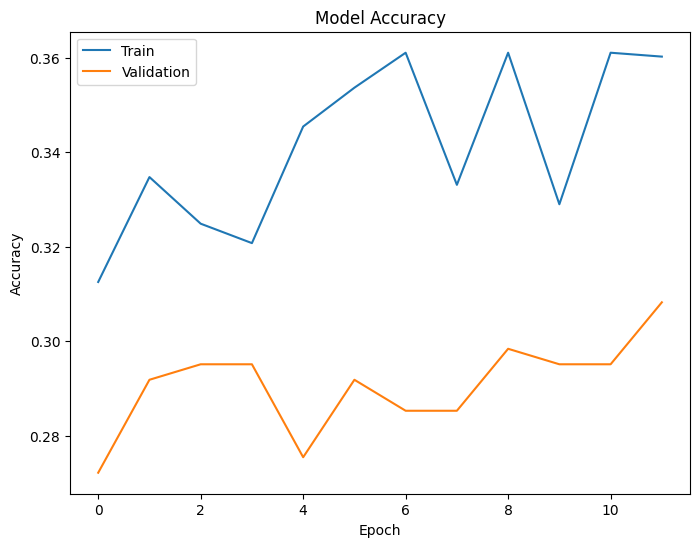

38/38 [==============================] - 0s 4ms/step
train accuracy: 0.378


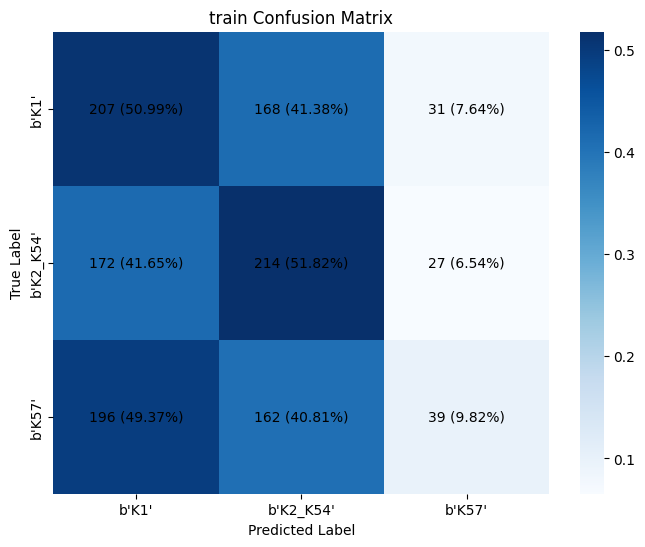

10/10 [==============================] - 0s 4ms/step
val accuracy: 0.308


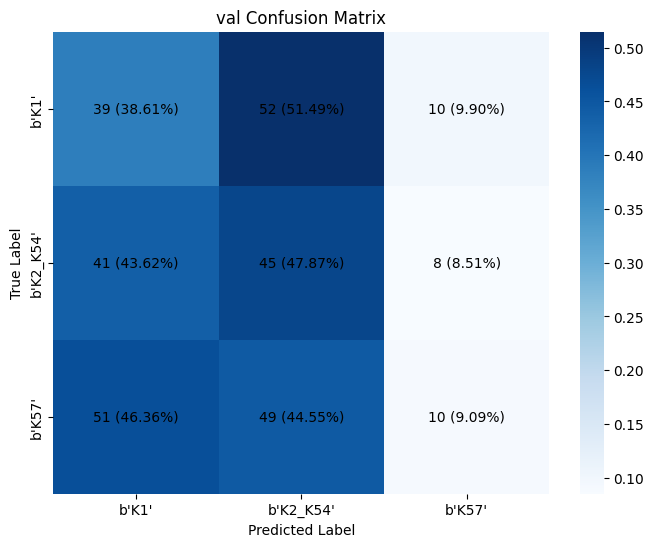

5/5 [==============================] - 0s 6ms/step
test accuracy: 0.288


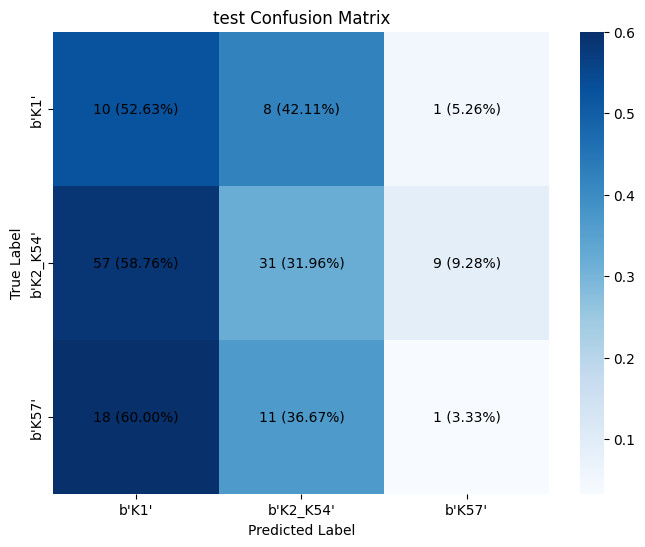

10/10 [==============================] - 0s 8ms/step
Epoch 1/30
28/28 - 6s - loss: 0.6929 - accuracy: 0.5089 - val_loss: 0.6932 - val_accuracy: 0.5179 - 6s/epoch - 216ms/step
Epoch 2/30
28/28 - 1s - loss: 0.6932 - accuracy: 0.5134 - val_loss: 0.6931 - val_accuracy: 0.5045 - 572ms/epoch - 20ms/step
Epoch 3/30
28/28 - 0s - loss: 0.6928 - accuracy: 0.5301 - val_loss: 0.6933 - val_accuracy: 0.5000 - 411ms/epoch - 15ms/step
Epoch 4/30
28/28 - 0s - loss: 0.6935 - accuracy: 0.5045 - val_loss: 0.6933 - val_accuracy: 0.5000 - 364ms/epoch - 13ms/step
Epoch 5/30
28/28 - 0s - loss: 0.6934 - accuracy: 0.4978 - val_loss: 0.6930 - val_accuracy: 0.4911 - 379ms/epoch - 14ms/step
Epoch 6/30
28/28 - 0s - loss: 0.6915 - accuracy: 0.5324 - val_loss: 0.6931 - val_accuracy: 0.5045 - 304ms/epoch - 11ms/step
Epoch 7/30
28/28 - 0s - loss: 0.6928 - accuracy: 0.5078 - val_loss: 0.6930 - val_accuracy: 0.5312 - 326ms/epoch - 12ms/step
Epoch 8/30
28/28 - 0s - loss: 0.6931 - accuracy: 0.5134 - val_loss: 0.6932 - val_

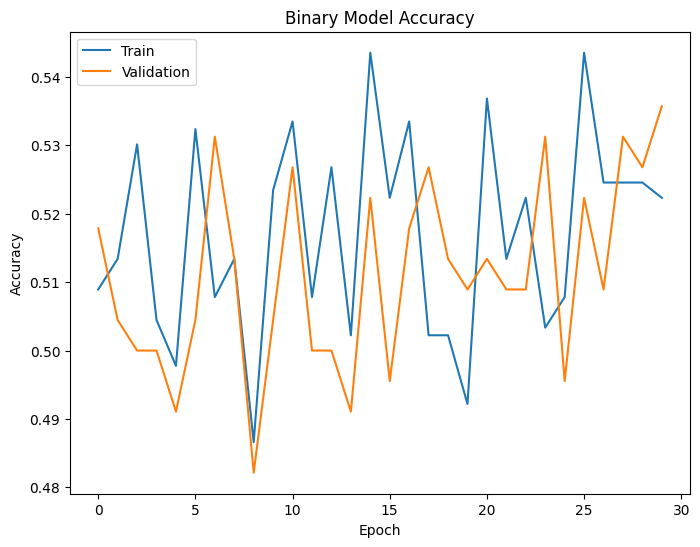

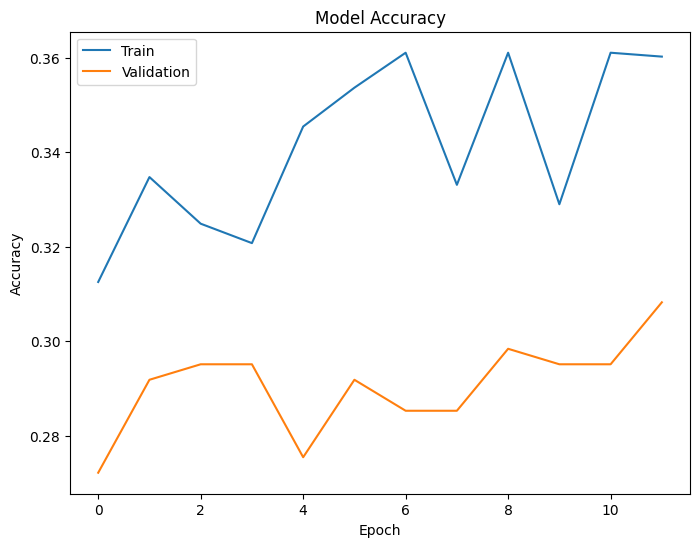

28/28 [==============================] - 0s 5ms/step
train accuracy: 0.579


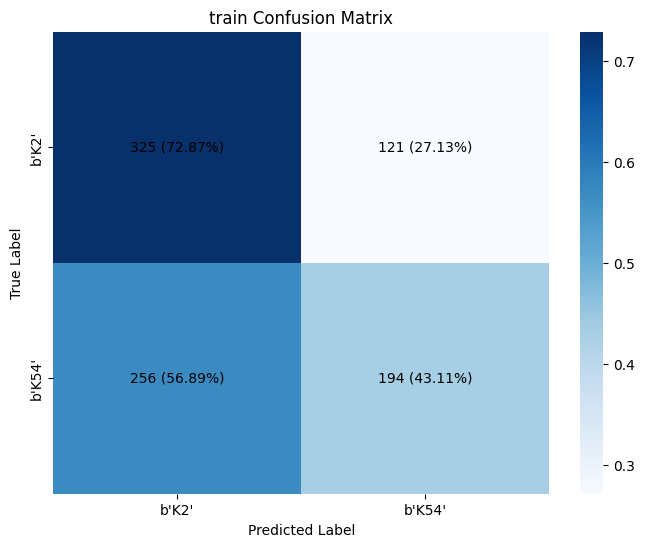

7/7 [==============================] - 0s 6ms/step
val accuracy: 0.536


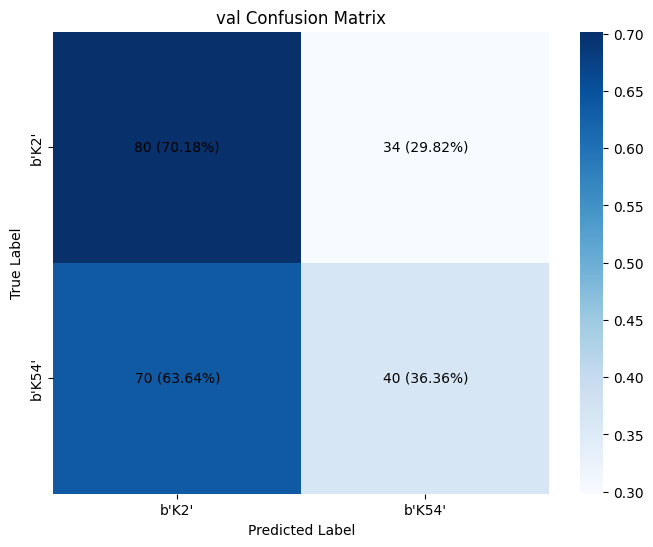

4/4 [==============================] - 0s 8ms/step
test accuracy: 0.505


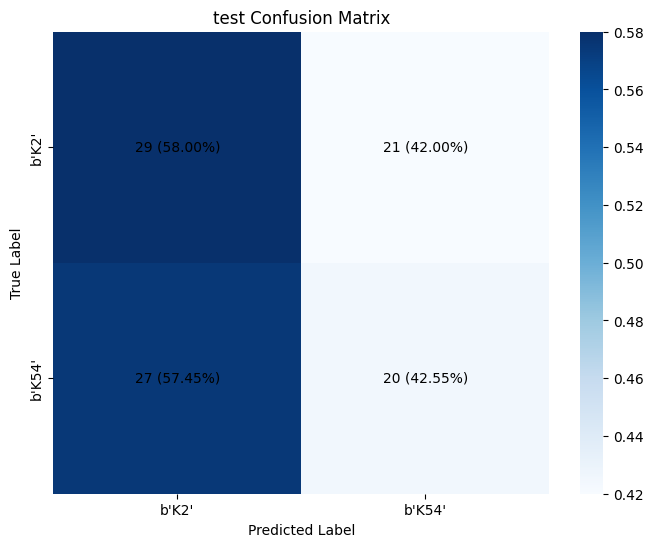

7/7 [==============================] - 0s 5ms/step


In [ ]:
filtered_data = filtered_data_reduced2
ramanshifts = random_values


feature_steps_list = []

# group k2 - k54 into a new column
filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2_K54' if x == 'K2' else ('K2_K54' if x == 'K54' else x))


# binary data contains only the spectra of k2 - k54
binary_classes = ['K2_K54', 'K54_K2']
binary_data = filtered_data[filtered_data['fenotype_grouped'].isin(binary_classes)]

# i separate spectra from specific isolates measued on different days as "unseens" (ensuring that an adequate n of spectra remain in the train/val dataset for that isolate)
conditions = [
(filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
(filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
#(filtered_data['isolate'] == 'kpC3') & (filtered_data['date'] == '310523')
]

final_condition = conditions[0]
for condition in conditions[1:]:
    final_condition = final_condition | condition


unseens = filtered_data[final_condition]
# train/val dataset
filtered_data2 = filtered_data[~final_condition]


columns_to_drop =  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date', 'fenotype_grouped']



label = 'fenotype_grouped'


# balanceo
all_classes = filtered_data2[label].unique()

minority_class_size = filtered_data2[label].value_counts().min()

balanced_binary_data_trainval = pd.DataFrame()
balanced_trainval_data = pd.DataFrame()


for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]

    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()



X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()




y_perm_train=tf.random.shuffle(y_train,seed=1000)
y_perm_val=tf.random.shuffle(y_val,seed=1000)
y_perm_test=tf.random.shuffle(y_test,seed=1000)


num_classes_grouped = len(all_classes)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_perm_train)
y_perm_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_perm_test)
y_perm_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_perm_val)
y_perm_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train.columns), 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes_grouped))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train.to_numpy(), y_perm_train, batch_size=32, epochs=12, verbose=2, validation_data=(X_val.to_numpy(), y_perm_val))

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

calcular = [{'que': 'train', 'X': X_train, 'y': y_perm_train},
            {'que': 'val', 'X': X_val, 'y': y_perm_val},
            {'que': 'test', 'X': X_test, 'y': y_perm_test}]

class_accuracies = {'train': [], 'val': [], 'test': []}

for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

    plt.figure(figsize=(8, 6))
    plt.title(f"{calcular[i]['que']} Confusion Matrix")
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_perm_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_perm_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_perm_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)

class_accuracies[calcular[2]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]




if 'K2_K54' in binary_data['fenotype_grouped'].values or 'K54_K2' in binary_data['fenotype_grouped'].values:
    all_classes_bin = 2

    conditions = [
    (binary_data['isolate'] == 'kp382') & (binary_data['date'] == 120723),
    (binary_data['isolate'] == 'Kp188') & (binary_data['date'] == 120723),
    ]

    final_condition = conditions[0]
    for condition in conditions[1:]:
        final_condition = final_condition | condition

    binary_data_unseens = binary_data[final_condition]
    binary_data_trainval = binary_data[~final_condition]


    label = 'fenotype'

    all_classes_ = ['K2', 'K54']

    # balanceo
    minority_class_size = binary_data_trainval[label].value_counts().min()
    balanced_binary_data_trainval = pd.DataFrame()
    for class_name in all_classes_:
        class_samples = binary_data[binary_data[label] == class_name]

        if class_samples.shape[0] > minority_class_size:
            reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, reduced_samples])
        else:
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, class_samples])

    balanced_y_trainval = balanced_binary_data_trainval[label]
    balanced_binary_data_trainval = balanced_binary_data_trainval.drop(columns=columns_to_drop).copy()



    X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(balanced_binary_data_trainval, balanced_y_trainval, test_size=0.20, random_state=1000)

    y_test_bin = binary_data_unseens['fenotype']
    X_test_bin = binary_data_unseens.drop(columns=columns_to_drop)


    y_train_bin=tf.random.shuffle(y_train_bin,seed=1000)
    y_val_bin=tf.random.shuffle(y_val_bin,seed=1000)
    y_test_bin=tf.random.shuffle(y_test_bin,seed=1000)


    le = LabelEncoder()
    y_train_encoded_bin = le.fit_transform(y_train_bin)
    y_train_bin = tf.keras.utils.to_categorical(y_train_encoded_bin, num_classes=2)
    y_test_encoded_bin = le.transform(y_test_bin)
    y_test_bin = tf.keras.utils.to_categorical(y_test_encoded_bin, num_classes=2)
    y_val_encoded_bin = le.transform(y_val_bin)
    y_val_bin = tf.keras.utils.to_categorical(y_val_encoded_bin, num_classes=2)

    binary_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    model_bin = tf.keras.models.Sequential(model.layers[:-1])  # Remove the last layer with 3 units
    model_bin.add(tf.keras.layers.Dense(2, activation='softmax'))  # Add new last layer with 2 units
    model_bin.compile(loss='categorical_crossentropy', optimizer=binary_optimizer, metrics=['accuracy'])

    binary_history = model_bin.fit(X_train_bin.to_numpy(), y_train_bin, batch_size=32, epochs=30, verbose=2, validation_data=(X_val_bin.to_numpy(), y_val_bin))

    plt.figure(figsize=(8, 6))
    plt.plot(binary_history.history['accuracy'])
    plt.plot(binary_history.history['val_accuracy'])
    plt.title('Binary Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    calcular_bin = [{'que': 'train', 'X': X_train_bin, 'y': y_train_bin},
                    {'que': 'val', 'X': X_val_bin, 'y': y_val_bin},
                    {'que': 'test', 'X': X_test_bin, 'y': y_test_bin}]

    class_accuracies_bin = {'train': [], 'val': [], 'test': []}

    for i in range(len(calcular_bin)):
        y_pred_bin = model_bin.predict(calcular_bin[i]['X'])
        y_pred_int_bin = np.argmax(y_pred_bin, axis=1)
        y_true_int_bin = np.argmax(calcular_bin[i]['y'], axis=1)
        accuracy_bin = accuracy_score(y_true_int_bin, y_pred_int_bin)
        print(f"{calcular_bin[i]['que']} accuracy: {accuracy_bin:1.3f}")

        cm_bin = confusion_matrix(y_true_int_bin, y_pred_int_bin, labels=np.arange(all_classes_bin))
        cm_normalized_bin = cm_bin.astype('float') / cm_bin.sum(axis=1, keepdims=True)

        plt.figure(figsize=(8, 6))
        plt.title(f"{calcular_bin[i]['que']} Confusion Matrix")
        sns.heatmap(cm_normalized_bin, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(all_classes_bin)), yticklabels=le.inverse_transform(np.arange(all_classes_bin)))

        for i in range(cm_bin.shape[0]):
            for j in range(cm_bin.shape[1]):
                value = cm_bin[i, j]
                if value != 0 and not np.isnan(cm_normalized_bin[i, j]):
                    text = f"{value} ({cm_normalized_bin[i, j] * 100:.2f}%)"
                    plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    class_accuracies_bin[calcular_bin[2]['que']] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]

    y_pred_bin = model_bin.predict(X_test_bin)
    y_pred_int_bin = tf.argmax(y_pred_bin, axis=1)
    y_test_int_bin = tf.argmax(y_test_bin, axis=1)
    accuracy_test_bin = accuracy_score(y_test_int_bin, y_pred_int_bin)

    y_pred_train_bin = model_bin.predict(X_train_bin)
    y_pred_val_bin = model_bin.predict(X_val_bin)

    y_pred_train_int_bin = tf.argmax(y_pred_train_bin, axis=1)
    y_train_int_bin = tf.argmax(y_train_bin, axis=1)
    accuracy_train_bin = accuracy_score(y_train_int_bin, y_pred_train_int_bin)

    y_pred_val_int_bin = tf.argmax(y_pred_val_bin, axis=1)
    y_val_int_bin = tf.argmax(y_val_bin, axis=1)
    accuracy_val_bin = accuracy_score(y_val_int_bin, y_pred_val_int_bin)

    class_accuracies_bin['test'] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]


# 3.4. Comparison between hypermucoviscous (hmvKp) and non-mucoid (nmKp) isolates

## Figure 22

Figure 22: Mean spectra of hmvKp (orange) and nmKp (blue) isolates with their respective standard deviations (a) and the confusion matrix obtained by training the 1-D CNN model with dimensionality reduction to 600 features (b). The overall accuracy was 94%.

<ipython-input-15-399efc20a72f>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax22a.set_yticklabels(ax22a.get_yticks(), fontsize=22)


8/8 [==============================] - 0s 9ms/step


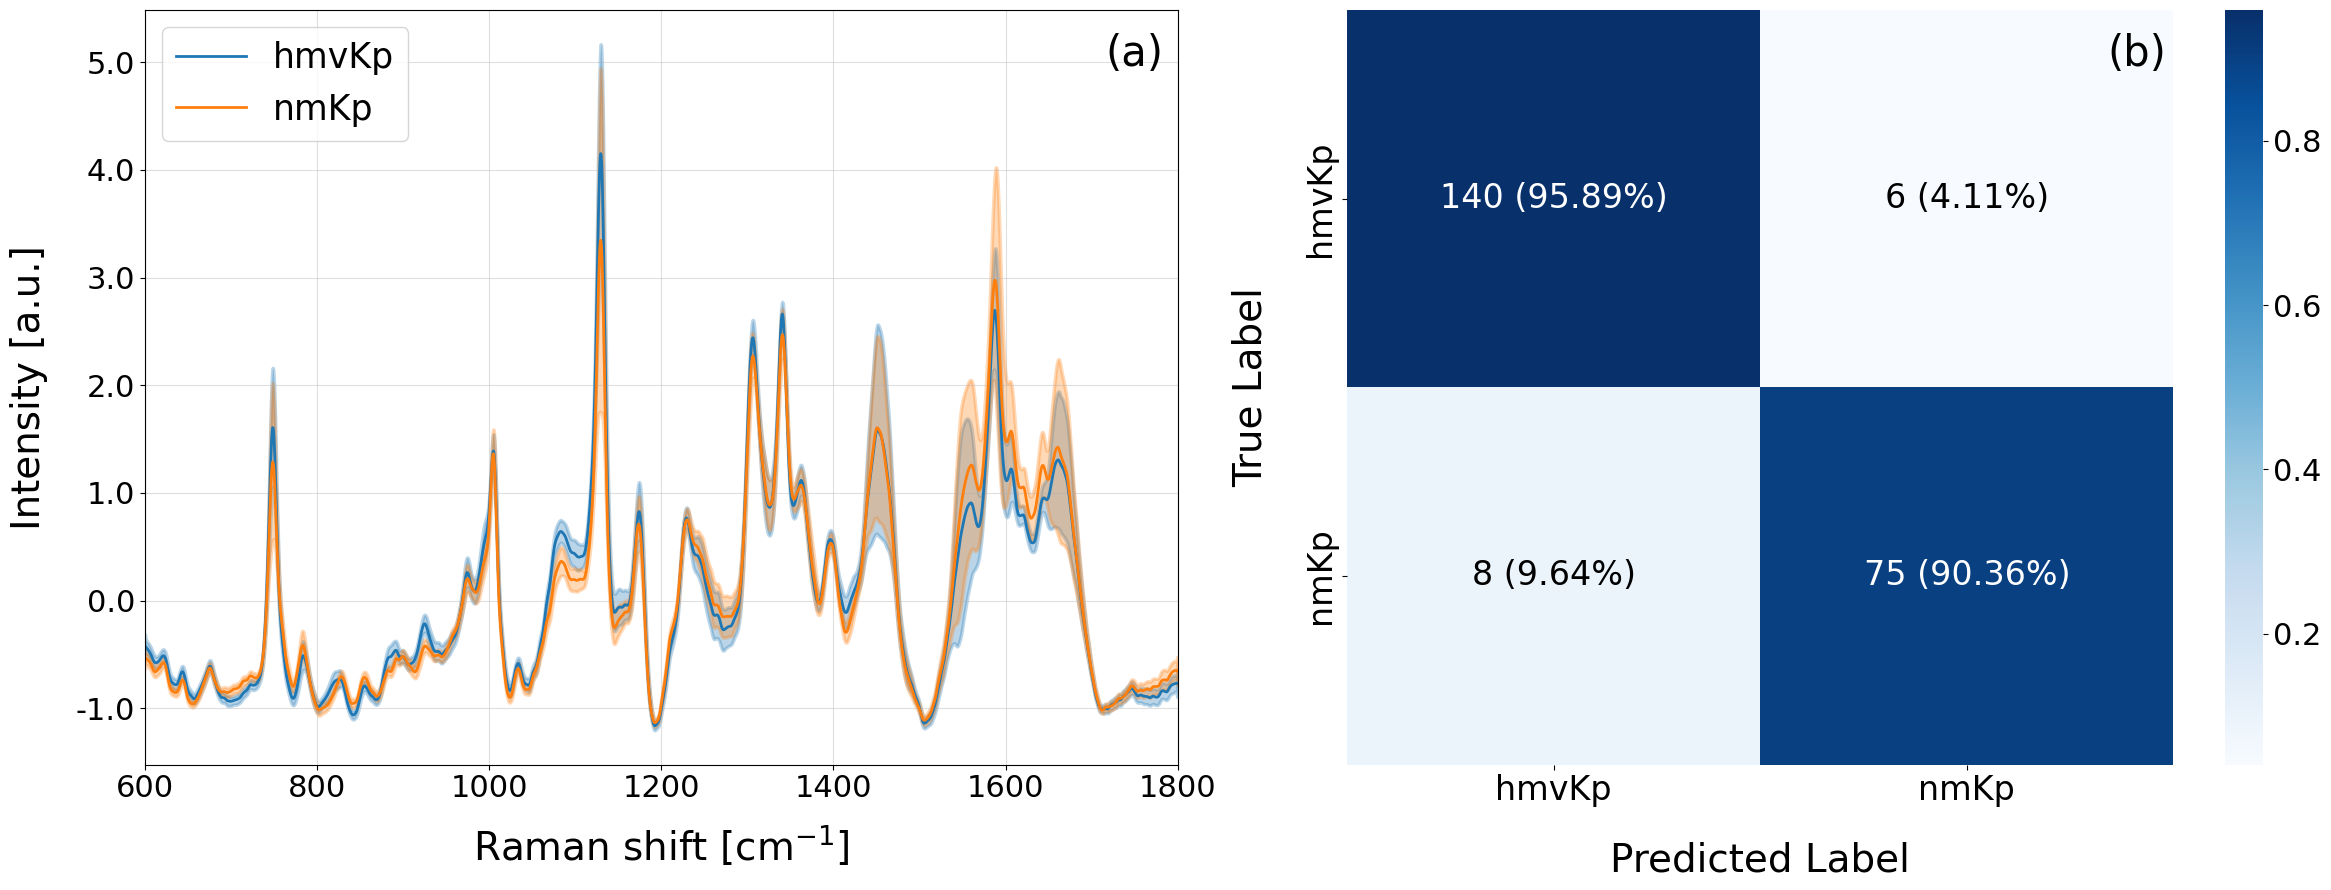

11/11 [==============================] - 0s 8ms/step
Class 0 - Accuracy: 0.94, Recall: 0.96, Precision: 0.95,Specificity: 0.90, F1-Score: 0.95 
Class 1 - Accuracy: 0.94, Recall: 0.90, Precision: 0.93,Specificity: 0.96, F1-Score: 0.91 


In [ ]:
filtered_data = spectra_without_small_range[spectra_without_small_range['date'] != 270623]

# Figure 22: Mean spectra of hmvKp (orange) and nmKp (blue) isolates (a) and the confusion matrix obtained by training the 1-D CNN model with dimensionality reduction to 600 features (b). The overall accuracy was 94%.

fig22, (ax22a, ax22b) = plt.subplots(1, 2, figsize=(24, 9))
ax22a.text(0.93, 0.97, '(a)', transform=ax22a.transAxes, fontsize=30, verticalalignment='top')
ax22b.text(0.92, 0.97, '(b)', transform=ax22b.transAxes, fontsize=30, verticalalignment='top')
alphaVal = 1
linethick = 2.5
# Calculate and plot mean spectra for 'mucoide' categories 'NM' and 'M'
espectros_NM = np.mean(filtered_data[filtered_data['mucoide'] == 'NM'].iloc[:, :-9], axis=0)
espectros_M = np.mean(filtered_data[filtered_data['mucoide'] == 'M'].iloc[:, :-9], axis=0)
ax22a.plot(ramanshifts, espectros_M, lw=2, color='C0', label='hmvKp')
ax22a.plot(ramanshifts, espectros_NM, lw=2, color='C1', label='nmKp')
# Calculate and plot variance of spectra
varianza_espectros_NM = filtered_data[filtered_data['mucoide'] == 'NM'].iloc[:, :-9].var(axis=0)
varianza_espectros_M = filtered_data[filtered_data['mucoide'] == 'M'].iloc[:, :-9].var(axis=0)
ax22a.fill_between(ramanshifts, espectros_M - varianza_espectros_M, espectros_M + varianza_espectros_M, lw=linethick, alpha=0.3, color='C0')
ax22a.fill_between(ramanshifts, espectros_NM - varianza_espectros_NM, espectros_NM + varianza_espectros_NM, lw=linethick, alpha=0.3, color='C1')

ax22a.legend(loc='upper left', prop={'size': 25})
ax22a.grid(alpha=0.4)
ax22a.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=28, labelpad=15)
ax22a.set_ylabel(r'Intensity [a.u.]', fontsize=28, labelpad=20)
ax22a.set_xlim([600, 1800])
ax22a.set_xticks(range(600, 2000, 200))
ax22a.set_xticklabels(range(600, 2000, 200), fontsize=22)
ax22a.set_yticklabels(ax22a.get_yticks(), fontsize=22)



# Load the pre-trained model
model = load_model('/content/drive/MyDrive/klebsiellas/190124_model_mucoid_nonmucoid_600features.h5')

# Define the data and label
filtered_data = filtered_data_reduced
label = 'mucoide'

# Data balancing (undersampling)
all_classes = filtered_data2[label].unique()
minority_class_size = filtered_data2[label].value_counts().min()
balanced_trainval_data = pd.DataFrame()
for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]
    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()

# Splitting data into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()

# Encoding class labels
num_classes_grouped = len(all_classes)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_val)
y_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

# Predictions and confusion matrix calculation
y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_int, y_pred_int, labels=np.arange(num_classes_grouped))
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums


# Plotting the confusion matrix
sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues',
                          xticklabels=le.inverse_transform(np.arange(num_classes_grouped)),
                          yticklabels=le.inverse_transform(np.arange(num_classes_grouped)),
                          ax=ax22b, annot_kws={'size': 18})

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        if value != 0 and not np.isnan(cm_normalized[i, j]):
            text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"

            # Elegir el color del texto basado en el valor de fondo
            text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
            plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=24)


ax22b.set_xlabel('Predicted Label', fontsize=28, labelpad=25)
ax22b.set_ylabel('True Label', fontsize=28, labelpad=25)
plt.xticks(np.arange(num_classes_grouped) + 0.5, ['hmvKp', 'nmKp'], fontsize=24, ha='center')
plt.yticks(np.arange(num_classes_grouped) + 0.5, ['hmvKp', 'nmKp'], fontsize=24, va='center')
cbar = sns_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
plt.tight_layout()
plt.show()


y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)


calcular = [{'que': 'train', 'X': X_train, 'y': y_train},
            {'que': 'val', 'X': X_val, 'y': y_val},
            {'que': 'test', 'X': X_test, 'y': y_test}]

class_accuracies = {'train': [], 'val': [], 'test': []}


class_accuracies[calcular[2]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]


y_pred_int_np = np.argmax(y_pred, axis=1)
y_test_int_np = np.argmax(y_test, axis=1)

# Calculate the performance metrics
class_metrics = []
for i in range(num_classes_grouped):
    # True Positive, False Negative, True Negative, False Positive
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp
    fp = cm[:, i].sum() - tp

    # Calculating Accuracy, Precision, Recall, Specificity, and F1-Score
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Avoid division by zero
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # One-hot encode true labels for current class
    y_true_class = np.zeros((len(y_test_int),))
    y_true_class[y_test_int == i] = 1

    # Probability scores for current class
    y_score_class = y_pred[:, i]

    # Append metrics for the class
    class_metrics.append({
        'Class': i,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1_score,
    })

# Print the calculated metrics for each class
for metrics in class_metrics:
    print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
          f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f},"
          f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f} ")

fig22.savefig('fig22.svg', dpi=300)

y-randomization

In [ ]:
# Initialize empty lists to store feature steps and results
feature_steps_list = []
results = []

# Data separation based on specific isolates and measurement dates
# Ensuring an adequate number of spectra remain in the training/validation dataset for each isolate
conditions = [
    (filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
    (filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
    (filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723),
    (filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
    (filtered_data['isolate'] == 'kpC3') & (filtered_data['date'] == '310523')
]

# Combine conditions using a logical OR operation
final_condition = np.logical_or.reduce(conditions)

# Define unseen dataset and training/validation dataset
unseens = filtered_data[final_condition]
filtered_data2 = filtered_data[~final_condition]


# Label for classification
label = 'mucoide'

# Class balancing
all_classes = filtered_data2[label].unique()
minority_class_size = filtered_data2[label].value_counts().min()
balanced_trainval_data = pd.DataFrame()

for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]
    reduced_samples = class_samples.sample(n=min(minority_class_size, len(class_samples)), random_state=1000)
    balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000
)

# Preparing the test set
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()

# Permutation of labels for training, validation, and test sets
y_perm_train = tf.random.shuffle(y_train, seed=1000)
y_perm_val = tf.random.shuffle(y_val, seed=1000)
y_perm_test = tf.random.shuffle(y_test, seed=1000)

# Encoding labels
num_classes_grouped = len(all_classes)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_perm_train)
y_perm_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_perm_val)
y_perm_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_perm_test)
y_perm_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)

# Model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train.columns), 1)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes_grouped, activation='softmax')
])

model.summary()

# Model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model training
history = model.fit(
    X_train.to_numpy(), y_perm_train, batch_size=32, epochs=12, verbose=2, validation_data=(X_val.to_numpy(), y_perm_val)
)

# Plotting training history
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Function to evaluate and plot model performance
def evaluate_and_plot(model, data, label_encoder):
    class_accuracies = {}
    for dataset in data:
        X, y, dataset_name = dataset['X'], dataset['y'], dataset['que']
        y_pred = model.predict(X)
        y_pred_int = tf.argmax(y_pred, axis=1)
        y_true_int = tf.argmax(y, axis=1)
        accuracy = accuracy_score(y_true_int, y_pred_int)
        print(f"{dataset_name} accuracy: {accuracy:.3f}")

        cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
        cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

        plt.figure(figsize=(8, 6))
        plt.title(f"{dataset_name} Confusion Matrix")
        sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues',
                    xticklabels=label_encoder.inverse_transform(np.arange(num_classes_grouped)),
                    yticklabels=label_encoder.inverse_transform(np.arange(num_classes_grouped)))

        # Annotating values in the confusion matrix
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                value = cm[i, j]
                if value != 0 and not np.isnan(cm_normalized[i, j]):
                    text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                    plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        class_accuracies[dataset_name] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]

    return class_accuracies

# Evaluating the model
evaluation_data = [
    {'que': 'train', 'X': X_train, 'y': y_perm_train},
    {'que': 'val', 'X': X_val, 'y': y_perm_val},
    {'que': 'test', 'X': X_test, 'y': y_perm_test}
]

class_accuracies = evaluate_and_plot(model, evaluation_data, le)

# Displaying per-class accuracies
for dataset_name, accuracies in class_accuracies.items():
    print(f"{dataset_name} per-class accuracies: {accuracies}")

## saliency

In [ ]:
# Load preprocessed dataset and trained model
filtered_data = filtered_data_reduced
model = load_model('/content/drive/MyDrive/klebsiellas/190124_model_mucoid_nonmucoid_600features.h5')

# Define label and columns to drop from the dataset
label = 'mucoide'
columns_to_drop = ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date']


# Balance the dataset
all_classes = filtered_data2[label].unique()
minority_class_size = filtered_data2[label].value_counts().min()
balanced_trainval_data = pd.DataFrame()

for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]
    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
    else:
        reduced_samples = class_samples
    balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data.drop(columns=columns_to_drop, inplace=True)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop)

# Saliency analysis
original_output = model.predict(X_test.values)
output_diff_data = []
total_iterations = len([filtered_data2[column].mean() for column in reduced_ramanshifts])

for idx in range(total_iterations):
    if idx < 4:
        selected_indices = list(range(idx, idx + 5))
    elif idx > total_iterations - 5:
        selected_indices = list(range(idx - 4, idx + 1))
    else:
        selected_indices = list(range(idx - 4, idx + 5))

    modified_test_data = X_test.copy()
    column_means = filtered_data2.mean(axis=0, numeric_only=True)
    min_mean = column_means.min()
    modified_test_data.iloc[:, selected_indices] = min_mean

    modified_probabilities = model.predict(modified_test_data.values)
    output_difference = np.abs(modified_probabilities - original_output)
    output_difference_mean = np.mean(output_difference, axis=0)
    output_diff_data.append({'feature': X_test.columns[idx], 'output_difference': output_difference_mean})

# Convert list to DataFrame
output_diff_df = pd.DataFrame(output_diff_data)
output_diff_df['feature'] = pd.to_numeric(output_diff_df['feature'])
output_diff_df['average_output_difference'] = output_diff_df['output_difference'].apply(lambda x: np.mean(x))
output_diff_df_ = output_diff_df[['feature', 'average_output_difference']]

# Plotting the saliency analysis results
plt.figure(figsize=(10, 6))
plt.plot(output_diff_df_['feature'], output_diff_df_['average_output_difference'], color='blue')
plt.xlabel('Raman shift [cm$^{-1}$]', fontsize=12)
plt.ylabel('Average Output Difference', fontsize=12)
plt.title('Model Saliency Analysis: Feature Impact on Predictions', fontsize=14)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()
plt.close()

# Save the saliency analysis results to a file
output_diff_df_.to_csv('/content/drive/MyDrive/klebsiellas/310124_output_diff_saliency_M_NM_600features.csv', index=False)

## Figure 23

Figure 23: Saliency of the 1-D CNN model trained to classify hmvKp and nmKp isolates. A continuous dashed line represents a saliency value of 0.18 (a). Features with a saliency value greater than 0.2 are marked in red, along with the mean spectrum of the entire dataset (b).

In [ ]:
# Sort the DataFrame by the 'feature' column in ascending order
output_diff_df_ = output_diff_df_.sort_values(by='feature', ascending=True)

# Create a subplot with 2 horizontal plots
fig23, (ax23a, ax23b) = plt.subplots(1, 2, figsize=(24, 8))

# Add subplot labels
ax23a.text(0.91, 0.97, '(a)', transform=ax23a.transAxes, fontsize=30, verticalalignment='top')
ax23b.text(0.91, 0.97, '(b)', transform=ax23b.transAxes, fontsize=30, verticalalignment='top')

# Plotting parameters
alphaVal = 1
linethick = 2.5

# Plotting the first subplot
ax23a.plot(output_diff_df_.iloc[:, 0], output_diff_df_.iloc[:, 1], color='C0', lw=linethick, alpha=alphaVal)
ax23a.grid(alpha=0.4)
ax23a.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=25, labelpad=15)
ax23a.set_ylabel(r'Intensity [a.u.]', fontsize=25, labelpad=20)
ax23a.set_xlim([600, 1800])
ax23a.set_xticks(range(600, 2000, 200))
ax23a.set_xticklabels(range(600, 2000, 200), fontsize=20)
ax23a.axhline(y=0.17, color='red', linestyle='--', alpha=0.5, lw=2)

# Ensure that y-tick labels are consistent with ax22a (assuming ax22a exists in your code)
yticklabels_ax22a = [item.get_text() for item in ax22a.get_yticklabels()]

# Set the same y-tick labels for ax23a
ax23a.set_yticklabels(yticklabels_ax22a, fontsize=20)

# Sort output_diff_df_ by 'average_output_difference' in descending order
output_diff_df_ = output_diff_df_.sort_values(by='average_output_difference', ascending=False)

# Filter to retain rows with 'average_output_difference' greater than 0.18
output_diff_df_top28 = output_diff_df_[output_diff_df_['average_output_difference'] > 0.18]

# Retaining specific columns in filtered_data_reduced
columns = ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date']
filtered_data_reduced2 = filtered_data_reduced.copy()
filtered_data_reduced2[columns] = filtered_data_reduced[columns]

# Extracting features to keep based on output_diff_df_top28
columns_to_keep = output_diff_df_top28['feature'].values

# Plotting the second subplot
ax23b.plot(reduced_ramanshifts, filtered_data_reduced2.iloc[:, :-9].mean(axis=0), lw=linethick, alpha=alphaVal)
ax23b.scatter(pd.DataFrame(columns_to_keep), filtered_data_reduced2[columns_to_keep].mean(axis=0), color='red', s=17, lw=linethick, alpha=alphaVal)
ax23b.grid(alpha=0.4)
ax23b.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=25, labelpad=15)
ax23b.set_ylabel(r'Intensity [a.u.]', fontsize=25, labelpad=20)
ax23b.set_xlim([600, 1800])
ax23b.set_xticklabels(range(600, 2000, 200), fontsize=20)

# Ensure that y-tick labels are consistent with ax22a (assuming ax22a exists in your code)
ax23b.set_yticklabels(ax23b.get_yticks(), fontsize=20)

# Display the plot
plt.show()

# Save the figure in SVG format with a specified dpi
fig23.savefig('fig23.svg', dpi=300)